In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D
from keras.optimizers import SGD
from vis.utils import utils

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/malimg_paper_dataset_imgs"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:       Adialer.C	Number of images: 122
Label: 1	Family:       Agent.FYI	Number of images: 116
Label: 2	Family:       Allaple.A	Number of images: 2949
Label: 3	Family:       Allaple.L	Number of images: 1591
Label: 4	Family:   Alueron.gen!J	Number of images: 198
Label: 5	Family:       Autorun.K	Number of images: 106
Label: 6	Family:     C2LOP.gen!g	Number of images: 200
Label: 7	Family:         C2LOP.P	Number of images: 146
Label: 8	Family:  Dialplatform.B	Number of images: 177
Label: 9	Family:       Dontovo.A	Number of images: 162
Label:10	Family:        Fakerean	Number of images: 381
Label:11	Family:   Instantaccess	Number of images: 431
Label:12	Family:      Lolyda.AA1	Number of images: 213
Label:13	Family:      Lolyda.AA2	Number of images: 184
Label:14	Family:      Lolyda.AA3	Number of images: 123
Label:15	Family:       Lolyda.AT	Number of images: 159
Label:16	Family:     Malex.gen!J	Number of images: 136
Label:17	Family:   Obfuscator.AD	Number of images: 142
Label:18

In [4]:
X.shape

(9339, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (Xception notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = Xception(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [7]:
print("Extracting features from Xception layers ...")
bnfeatures = base_model.predict(X)

Extracting features from Xception layers ...


In [8]:
print(bnfeatures)

[[ 0.09388348  0.04388153  0.         ...,  0.          0.          0.        ]
 [ 0.17531636  0.05353614  0.01082568 ...,  0.          0.          0.00120005]
 [ 0.10424511  0.03545112  0.00399242 ...,  0.          0.          0.00131496]
 ..., 
 [ 0.63891053  0.43004024  0.29541007 ...,  0.04530464  0.00597155
   0.00227766]
 [ 0.63891053  0.43004024  0.29541007 ...,  0.04530464  0.00597155
   0.00227766]
 [ 0.63891053  0.43004024  0.29541007 ...,  0.04530464  0.00597155
   0.00227766]]


In [9]:
bnfeatures.shape

(9339, 2048)

In [10]:
# Adding a custom top layer to the model
predictions = Dense(num_classes, activation='softmax', name='predictions')(base_model.output)
model = Model(inputs=base_model.input, outputs=predictions)
#model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 111, 111, 32)  864         input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, 111, 111, 32)  128         block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, 111, 111, 32)  0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [11]:
# Creating the top model for pre-training
bottleneck_features = Input(shape=bnfeatures.shape[1:], name='bottleneck_features')
predictions = Dense(num_classes, activation='softmax', name='predictions')(bottleneck_features)
top_model = Model(inputs=bottleneck_features, outputs=predictions)
top_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
top_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bottleneck_features (InputLa (None, 2048)              0         
_________________________________________________________________
predictions (Dense)          (None, 25)                51225     
Total params: 51,225
Trainable params: 51,225
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [ ]:
# Fine-tuning the model (base_model + top layer) 
num_epochs=100
history = []
tophistory = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
checkpointer = ModelCheckpoint(filepath='malimg-xception-pretrained-finetune.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
init_weights = model.get_weights()
init_top_weights = top_model.get_weights()

In [ ]:
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    bnfeatures_train = bnfeatures[train_indices]
    Y_train = Y[train_indices]
    X_test = X[test_indices]
    bnfeatures_test = bnfeatures[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
  
    print("[%d] Pre-training the top model ..." %(i))

    top_model.set_weights(init_top_weights)

    y_prob = top_model.predict(bnfeatures_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Initial acurracy (top_model): %.4f" %(i,accuracy_score(y_test,y_pred)))
    
    start = time.time()
    h = top_model.fit(bnfeatures_train, Y_train, validation_data=(bnfeatures_test, Y_test), epochs=num_epochs, batch_size=64, verbose=1, callbacks=callbacks_list)
    end = time.time()
    tophistory.append(h)
    
    pretrained_top_weights = top_model.get_weights()
          
    y_prob = top_model.predict(bnfeatures_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Pre-trained acurracy (top_model): %.4f" %(i,accuracy_score(y_test,y_pred)))
   
    print("[%d] Fine-tuning the model ..." %(i))

    model.set_weights(init_weights)
    model.layers[-1].set_weights(init_top_weights)
    
    #y_prob = model.predict(X_test, verbose=0)  # Testing
    #y_pred = np.argmax(y_prob, axis=1)
    #print("[%d] Initial acurracy (model): %.4f" %(i,accuracy_score(y_test,y_pred)))
    
    model.layers[-1].set_weights(pretrained_top_weights)

    #y_prob = model.predict(X_test, verbose=0)  # Testing
    #y_pred = np.argmax(y_prob, axis=1)
    #print("[%d] Pre-trained acurracy (model): %.4f" %(i,accuracy_score(y_test,y_pred)))    
    
    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=32, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
        
    y_prob = model.predict(X_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

[0] Pre-training the top model ...
[0] Initial acurracy (top_model): 0.0148
Train on 8394 samples, validate on 945 samples
Epoch 1/100
8394/8394 [==============================] - 0s - loss: 0.8628 - acc: 0.7957 - val_loss: 0.3772 - val_acc: 0.9132
Epoch 2/100
8394/8394 [==============================] - 0s - loss: 0.2599 - acc: 0.9350 - val_loss: 0.2461 - val_acc: 0.9354
Epoch 3/100
8394/8394 [==============================] - 0s - loss: 0.1819 - acc: 0.9489 - val_loss: 0.2015 - val_acc: 0.9397
Epoch 4/100
8394/8394 [==============================] - 0s - loss: 0.1434 - acc: 0.9566 - val_loss: 0.1705 - val_acc: 0.9481
Epoch 5/100
8394/8394 [==============================] - 0s - loss: 0.1218 - acc: 0.9649 - val_loss: 0.1566 - val_acc: 0.9471
Epoch 6/100
8394/8394 [==============================] - 0s - loss: 0.1059 - acc: 0.9681 - val_loss: 0.1427 - val_acc: 0.9524
Epoch 7/100
8394/8394 [==============================] - 0s - loss: 0.0951 - acc: 0.9718 - val_loss: 0.1313 - val_acc: 0.

8394/8394 [==============================] - 0s - loss: 0.0087 - acc: 0.9990 - val_loss: 0.0716 - val_acc: 0.9799
Epoch 65/100
8394/8394 [==============================] - 0s - loss: 0.0083 - acc: 0.9996 - val_loss: 0.0729 - val_acc: 0.9767
Epoch 66/100
8394/8394 [==============================] - 0s - loss: 0.0080 - acc: 0.9995 - val_loss: 0.0726 - val_acc: 0.9767
Epoch 67/100
8394/8394 [==============================] - 0s - loss: 0.0084 - acc: 0.9994 - val_loss: 0.0728 - val_acc: 0.9788
Epoch 68/100
8394/8394 [==============================] - 0s - loss: 0.0078 - acc: 0.9994 - val_loss: 0.0737 - val_acc: 0.9778
Epoch 69/100
8394/8394 [==============================] - 0s - loss: 0.0073 - acc: 0.9993 - val_loss: 0.0752 - val_acc: 0.9778
Epoch 70/100
8394/8394 [==============================] - 0s - loss: 0.0074 - acc: 0.9993 - val_loss: 0.0758 - val_acc: 0.9767
Epoch 71/100
8394/8394 [==============================] - 0s - loss: 0.0071 - acc: 0.9996 - val_loss: 0.0759 - val_acc: 0.97

8394/8394 [==============================] - 132s - loss: 0.0054 - acc: 0.9985 - val_loss: 0.1084 - val_acc: 0.9788
Epoch 28/100
8394/8394 [==============================] - 128s - loss: 0.0042 - acc: 0.9990 - val_loss: 0.1064 - val_acc: 0.9799
Epoch 29/100
8394/8394 [==============================] - 131s - loss: 0.0038 - acc: 0.9989 - val_loss: 0.1060 - val_acc: 0.9788
Epoch 30/100
8394/8394 [==============================] - 135s - loss: 0.0032 - acc: 0.9995 - val_loss: 0.1048 - val_acc: 0.9799
Epoch 31/100
8394/8394 [==============================] - 127s - loss: 0.0038 - acc: 0.9993 - val_loss: 0.1090 - val_acc: 0.9810
Epoch 32/100
8394/8394 [==============================] - 124s - loss: 0.0037 - acc: 0.9994 - val_loss: 0.1060 - val_acc: 0.9820
Epoch 33/100
8394/8394 [==============================] - 125s - loss: 0.0027 - acc: 0.9995 - val_loss: 0.1047 - val_acc: 0.9799
Epoch 34/100
8394/8394 [==============================] - 125s - loss: 0.0038 - acc: 0.9987 - val_loss: 0.1016

8394/8394 [==============================] - 124s - loss: 5.5289e-04 - acc: 1.0000 - val_loss: 0.1049 - val_acc: 0.9831
Epoch 91/100
8394/8394 [==============================] - 130s - loss: 0.0026 - acc: 0.9995 - val_loss: 0.1064 - val_acc: 0.9820
Epoch 92/100
8394/8394 [==============================] - 125s - loss: 0.0011 - acc: 0.9999 - val_loss: 0.1100 - val_acc: 0.9831
Epoch 93/100
8394/8394 [==============================] - 125s - loss: 0.0010 - acc: 0.9998 - val_loss: 0.1081 - val_acc: 0.9820
Epoch 94/100
8394/8394 [==============================] - 125s - loss: 0.0012 - acc: 0.9996 - val_loss: 0.1061 - val_acc: 0.9820
Epoch 95/100
8394/8394 [==============================] - 127s - loss: 6.3789e-04 - acc: 1.0000 - val_loss: 0.1072 - val_acc: 0.9831
Epoch 96/100
8394/8394 [==============================] - 129s - loss: 8.4678e-04 - acc: 1.0000 - val_loss: 0.1073 - val_acc: 0.9820
Epoch 97/100
8394/8394 [==============================] - 130s - loss: 0.0010 - acc: 0.9998 - val_

8397/8397 [==============================] - 0s - loss: 0.0092 - acc: 0.9994 - val_loss: 0.0515 - val_acc: 0.9798
Epoch 54/100
8397/8397 [==============================] - 0s - loss: 0.0088 - acc: 0.9993 - val_loss: 0.0522 - val_acc: 0.9777
Epoch 55/100
8397/8397 [==============================] - 0s - loss: 0.0088 - acc: 0.9990 - val_loss: 0.0522 - val_acc: 0.9798
Epoch 56/100
8397/8397 [==============================] - 0s - loss: 0.0084 - acc: 0.9995 - val_loss: 0.0504 - val_acc: 0.9841
Epoch 57/100
8397/8397 [==============================] - 0s - loss: 0.0085 - acc: 0.9993 - val_loss: 0.0551 - val_acc: 0.9820
Epoch 58/100
8397/8397 [==============================] - 0s - loss: 0.0087 - acc: 0.9990 - val_loss: 0.0513 - val_acc: 0.9756
Epoch 59/100
8397/8397 [==============================] - 0s - loss: 0.0081 - acc: 0.9993 - val_loss: 0.0512 - val_acc: 0.9830
Epoch 60/100
8397/8397 [==============================] - 0s - loss: 0.0076 - acc: 0.9996 - val_loss: 0.0530 - val_acc: 0.98

8397/8397 [==============================] - 121s - loss: 0.0133 - acc: 0.9963 - val_loss: 0.2941 - val_acc: 0.9639
Epoch 17/100
8397/8397 [==============================] - 122s - loss: 0.0126 - acc: 0.9967 - val_loss: 0.2991 - val_acc: 0.9660
Epoch 18/100
8397/8397 [==============================] - 123s - loss: 0.0103 - acc: 0.9968 - val_loss: 0.2995 - val_acc: 0.9650
Epoch 19/100
8397/8397 [==============================] - 122s - loss: 0.0074 - acc: 0.9983 - val_loss: 0.2909 - val_acc: 0.9628
Epoch 20/100
8397/8397 [==============================] - 123s - loss: 0.0086 - acc: 0.9980 - val_loss: 0.2878 - val_acc: 0.9607
Epoch 21/100
8397/8397 [==============================] - 122s - loss: 0.0094 - acc: 0.9974 - val_loss: 0.2934 - val_acc: 0.9618
Epoch 22/100
8397/8397 [==============================] - 121s - loss: 0.0069 - acc: 0.9987 - val_loss: 0.2863 - val_acc: 0.9607
Epoch 23/100
8397/8397 [==============================] - 122s - loss: 0.0077 - acc: 0.9979 - val_loss: 0.3085

8397/8397 [==============================] - 126s - loss: 0.0042 - acc: 0.9995 - val_loss: 0.3110 - val_acc: 0.9660
Epoch 80/100
8397/8397 [==============================] - 125s - loss: 0.0016 - acc: 0.9996 - val_loss: 0.3121 - val_acc: 0.9682
Epoch 81/100
8397/8397 [==============================] - 128s - loss: 0.0027 - acc: 0.9990 - val_loss: 0.3101 - val_acc: 0.9692
Epoch 82/100
8397/8397 [==============================] - 121s - loss: 0.0010 - acc: 0.9999 - val_loss: 0.3070 - val_acc: 0.9692
Epoch 83/100
8397/8397 [==============================] - 122s - loss: 0.0017 - acc: 0.9998 - val_loss: 0.2984 - val_acc: 0.9660
Epoch 84/100
8397/8397 [==============================] - 121s - loss: 0.0032 - acc: 0.9993 - val_loss: 0.3121 - val_acc: 0.9692
Epoch 85/100
8397/8397 [==============================] - 122s - loss: 0.0017 - acc: 0.9998 - val_loss: 0.3164 - val_acc: 0.9660
Epoch 86/100
8397/8397 [==============================] - 131s - loss: 8.9491e-04 - acc: 0.9999 - val_loss: 0.

8401/8401 [==============================] - 0s - loss: 0.0137 - acc: 0.9977 - val_loss: 0.0551 - val_acc: 0.9755
Epoch 42/100
8401/8401 [==============================] - 0s - loss: 0.0132 - acc: 0.9977 - val_loss: 0.0575 - val_acc: 0.9765
Epoch 43/100
8401/8401 [==============================] - 0s - loss: 0.0126 - acc: 0.9977 - val_loss: 0.0580 - val_acc: 0.9744
Epoch 44/100
8401/8401 [==============================] - 0s - loss: 0.0123 - acc: 0.9981 - val_loss: 0.0563 - val_acc: 0.9755
Epoch 45/100
8401/8401 [==============================] - 0s - loss: 0.0122 - acc: 0.9974 - val_loss: 0.0552 - val_acc: 0.9797
Epoch 46/100
8401/8401 [==============================] - 0s - loss: 0.0116 - acc: 0.9985 - val_loss: 0.0536 - val_acc: 0.9797
Epoch 47/100
8401/8401 [==============================] - 0s - loss: 0.0113 - acc: 0.9980 - val_loss: 0.0551 - val_acc: 0.9787
Epoch 48/100
8401/8401 [==============================] - 0s - loss: 0.0107 - acc: 0.9987 - val_loss: 0.0541 - val_acc: 0.97

8401/8401 [==============================] - 124s - loss: 0.1354 - acc: 0.9668 - val_loss: 0.1546 - val_acc: 0.9606
Epoch 5/100
8401/8401 [==============================] - 124s - loss: 0.0988 - acc: 0.9764 - val_loss: 0.1175 - val_acc: 0.9701
Epoch 6/100
8401/8401 [==============================] - 123s - loss: 0.0710 - acc: 0.9800 - val_loss: 0.1417 - val_acc: 0.9670
Epoch 7/100
8401/8401 [==============================] - 123s - loss: 0.0584 - acc: 0.9849 - val_loss: 0.1318 - val_acc: 0.9701
Epoch 8/100
8401/8401 [==============================] - 123s - loss: 0.0487 - acc: 0.9860 - val_loss: 0.0965 - val_acc: 0.9733
Epoch 9/100
8401/8401 [==============================] - 122s - loss: 0.0363 - acc: 0.9893 - val_loss: 0.1098 - val_acc: 0.9744
Epoch 10/100
8401/8401 [==============================] - 123s - loss: 0.0278 - acc: 0.9914 - val_loss: 0.0962 - val_acc: 0.9744
Epoch 11/100
8401/8401 [==============================] - 123s - loss: 0.0249 - acc: 0.9939 - val_loss: 0.0834 - va

8401/8401 [==============================] - 123s - loss: 8.1806e-04 - acc: 0.9998 - val_loss: 0.1071 - val_acc: 0.9819
Epoch 68/100
8401/8401 [==============================] - 123s - loss: 0.0017 - acc: 0.9999 - val_loss: 0.1126 - val_acc: 0.9829
Epoch 69/100
8401/8401 [==============================] - 124s - loss: 0.0017 - acc: 0.9995 - val_loss: 0.0998 - val_acc: 0.9829
Epoch 70/100
8401/8401 [==============================] - 124s - loss: 0.0012 - acc: 0.9998 - val_loss: 0.1009 - val_acc: 0.9808
Epoch 71/100
8401/8401 [==============================] - 124s - loss: 0.0018 - acc: 0.9998 - val_loss: 0.1009 - val_acc: 0.9797
Epoch 72/100
8401/8401 [==============================] - 124s - loss: 0.0015 - acc: 0.9995 - val_loss: 0.0945 - val_acc: 0.9797
Epoch 73/100
8401/8401 [==============================] - 124s - loss: 0.0012 - acc: 0.9998 - val_loss: 0.0965 - val_acc: 0.9797
Epoch 74/100
8401/8401 [==============================] - 124s - loss: 0.0010 - acc: 0.9999 - val_loss: 0.

8403/8403 [==============================] - 0s - loss: 0.0194 - acc: 0.9965 - val_loss: 0.0599 - val_acc: 0.9808
Epoch 30/100
8403/8403 [==============================] - 0s - loss: 0.0188 - acc: 0.9969 - val_loss: 0.0585 - val_acc: 0.9829
Epoch 31/100
8403/8403 [==============================] - 0s - loss: 0.0190 - acc: 0.9951 - val_loss: 0.0583 - val_acc: 0.9818
Epoch 32/100
8403/8403 [==============================] - 0s - loss: 0.0174 - acc: 0.9967 - val_loss: 0.0566 - val_acc: 0.9818
Epoch 33/100
8403/8403 [==============================] - 0s - loss: 0.0177 - acc: 0.9961 - val_loss: 0.0554 - val_acc: 0.9818
Epoch 34/100
8403/8403 [==============================] - 0s - loss: 0.0166 - acc: 0.9964 - val_loss: 0.0570 - val_acc: 0.9840
Epoch 35/100
8403/8403 [==============================] - 0s - loss: 0.0158 - acc: 0.9968 - val_loss: 0.0553 - val_acc: 0.9818
Epoch 36/100
8403/8403 [==============================] - 0s - loss: 0.0163 - acc: 0.9967 - val_loss: 0.0584 - val_acc: 0.98

8403/8403 [==============================] - 0s - loss: 0.0036 - acc: 0.9999 - val_loss: 0.0609 - val_acc: 0.9861
Epoch 94/100
8403/8403 [==============================] - 0s - loss: 0.0038 - acc: 0.9998 - val_loss: 0.0598 - val_acc: 0.9840
Epoch 95/100
8403/8403 [==============================] - 0s - loss: 0.0037 - acc: 0.9996 - val_loss: 0.0636 - val_acc: 0.9840
Epoch 96/100
8403/8403 [==============================] - 0s - loss: 0.0035 - acc: 1.0000 - val_loss: 0.0600 - val_acc: 0.9850
Epoch 97/100
8403/8403 [==============================] - 0s - loss: 0.0035 - acc: 0.9999 - val_loss: 0.0602 - val_acc: 0.9850
Epoch 98/100
8403/8403 [==============================] - 0s - loss: 0.0036 - acc: 0.9998 - val_loss: 0.0627 - val_acc: 0.9829
Epoch 99/100
8403/8403 [==============================] - 0s - loss: 0.0034 - acc: 1.0000 - val_loss: 0.0631 - val_acc: 0.9818
Epoch 100/100
8403/8403 [==============================] - 0s - loss: 0.0034 - acc: 0.9998 - val_loss: 0.0624 - val_acc: 0.9

8403/8403 [==============================] - 121s - loss: 0.0014 - acc: 0.9995 - val_loss: 0.3027 - val_acc: 0.9669
Epoch 56/100
8403/8403 [==============================] - 121s - loss: 0.0028 - acc: 0.9993 - val_loss: 0.3091 - val_acc: 0.9669
Epoch 57/100
8403/8403 [==============================] - 120s - loss: 0.0024 - acc: 0.9994 - val_loss: 0.3153 - val_acc: 0.9669
Epoch 58/100
8403/8403 [==============================] - 121s - loss: 0.0012 - acc: 0.9999 - val_loss: 0.3115 - val_acc: 0.9669
Epoch 59/100
8403/8403 [==============================] - 121s - loss: 0.0034 - acc: 0.9994 - val_loss: 0.3144 - val_acc: 0.9669
Epoch 60/100
8403/8403 [==============================] - 120s - loss: 0.0026 - acc: 0.9993 - val_loss: 0.3110 - val_acc: 0.9679
Epoch 61/100
8403/8403 [==============================] - 121s - loss: 0.0032 - acc: 0.9994 - val_loss: 0.3114 - val_acc: 0.9669
Epoch 62/100
8403/8403 [==============================] - 120s - loss: 0.0014 - acc: 0.9998 - val_loss: 0.3110

8404/8404 [==============================] - 0s - loss: 0.0311 - acc: 0.9925 - val_loss: 0.0640 - val_acc: 0.9765
Epoch 18/100
8404/8404 [==============================] - 0s - loss: 0.0291 - acc: 0.9932 - val_loss: 0.0670 - val_acc: 0.9786
Epoch 19/100
8404/8404 [==============================] - 0s - loss: 0.0287 - acc: 0.9936 - val_loss: 0.0596 - val_acc: 0.9807
Epoch 20/100
8404/8404 [==============================] - 0s - loss: 0.0264 - acc: 0.9937 - val_loss: 0.0592 - val_acc: 0.9786
Epoch 21/100
8404/8404 [==============================] - 0s - loss: 0.0261 - acc: 0.9938 - val_loss: 0.0591 - val_acc: 0.9786
Epoch 22/100
8404/8404 [==============================] - 0s - loss: 0.0253 - acc: 0.9945 - val_loss: 0.0592 - val_acc: 0.9775
Epoch 23/100
8404/8404 [==============================] - 0s - loss: 0.0240 - acc: 0.9944 - val_loss: 0.0583 - val_acc: 0.9807
Epoch 24/100
8404/8404 [==============================] - 0s - loss: 0.0237 - acc: 0.9948 - val_loss: 0.0613 - val_acc: 0.97

8404/8404 [==============================] - 0s - loss: 0.0047 - acc: 0.9999 - val_loss: 0.0643 - val_acc: 0.9818
Epoch 82/100
8404/8404 [==============================] - 0s - loss: 0.0047 - acc: 0.9999 - val_loss: 0.0643 - val_acc: 0.9786
Epoch 83/100
8404/8404 [==============================] - 0s - loss: 0.0044 - acc: 0.9999 - val_loss: 0.0669 - val_acc: 0.9775
Epoch 84/100
8404/8404 [==============================] - 0s - loss: 0.0043 - acc: 0.9999 - val_loss: 0.0655 - val_acc: 0.9840
Epoch 85/100
8404/8404 [==============================] - 0s - loss: 0.0045 - acc: 0.9998 - val_loss: 0.0658 - val_acc: 0.9786
Epoch 86/100
8404/8404 [==============================] - 0s - loss: 0.0042 - acc: 0.9999 - val_loss: 0.0648 - val_acc: 0.9775
Epoch 87/100
8404/8404 [==============================] - 0s - loss: 0.0039 - acc: 1.0000 - val_loss: 0.0643 - val_acc: 0.9807
Epoch 88/100
8404/8404 [==============================] - 0s - loss: 0.0040 - acc: 0.9999 - val_loss: 0.0661 - val_acc: 0.97

8404/8404 [==============================] - 120s - loss: 0.0019 - acc: 0.9996 - val_loss: 0.0914 - val_acc: 0.9807
Epoch 45/100
8404/8404 [==============================] - 121s - loss: 0.0032 - acc: 0.9992 - val_loss: 0.0881 - val_acc: 0.9818
Epoch 46/100
8404/8404 [==============================] - 121s - loss: 0.0042 - acc: 0.9987 - val_loss: 0.0916 - val_acc: 0.9818
Epoch 47/100
8404/8404 [==============================] - 120s - loss: 0.0022 - acc: 0.9994 - val_loss: 0.0907 - val_acc: 0.9807
Epoch 48/100
8404/8404 [==============================] - 121s - loss: 0.0017 - acc: 0.9998 - val_loss: 0.0951 - val_acc: 0.9797
Epoch 49/100
8404/8404 [==============================] - 120s - loss: 0.0018 - acc: 0.9998 - val_loss: 0.0928 - val_acc: 0.9818
Epoch 50/100
8404/8404 [==============================] - 121s - loss: 0.0023 - acc: 0.9995 - val_loss: 0.0937 - val_acc: 0.9818
Epoch 51/100
8404/8404 [==============================] - 120s - loss: 0.0032 - acc: 0.9992 - val_loss: 0.0936

8404/8404 [==============================] - 0s - loss: 0.0707 - acc: 0.9814 - val_loss: 0.1175 - val_acc: 0.9647
Epoch 6/100
8404/8404 [==============================] - 0s - loss: 0.0621 - acc: 0.9837 - val_loss: 0.1232 - val_acc: 0.9615
Epoch 7/100
8404/8404 [==============================] - 0s - loss: 0.0561 - acc: 0.9862 - val_loss: 0.1103 - val_acc: 0.9647
Epoch 8/100
8404/8404 [==============================] - 0s - loss: 0.0520 - acc: 0.9868 - val_loss: 0.1089 - val_acc: 0.9690
Epoch 9/100
8404/8404 [==============================] - 0s - loss: 0.0479 - acc: 0.9875 - val_loss: 0.0980 - val_acc: 0.9668
Epoch 10/100
8404/8404 [==============================] - 0s - loss: 0.0451 - acc: 0.9883 - val_loss: 0.1000 - val_acc: 0.9722
Epoch 11/100
8404/8404 [==============================] - 0s - loss: 0.0423 - acc: 0.9889 - val_loss: 0.0969 - val_acc: 0.9711
Epoch 12/100
8404/8404 [==============================] - 0s - loss: 0.0396 - acc: 0.9906 - val_loss: 0.0936 - val_acc: 0.9733
E

8404/8404 [==============================] - 0s - loss: 0.0062 - acc: 0.9996 - val_loss: 0.0923 - val_acc: 0.9754
Epoch 70/100
8404/8404 [==============================] - 0s - loss: 0.0061 - acc: 0.9996 - val_loss: 0.0904 - val_acc: 0.9754
Epoch 71/100
8404/8404 [==============================] - 0s - loss: 0.0057 - acc: 0.9995 - val_loss: 0.0929 - val_acc: 0.9775
Epoch 72/100
8404/8404 [==============================] - 0s - loss: 0.0056 - acc: 0.9996 - val_loss: 0.0922 - val_acc: 0.9754
Epoch 73/100
8404/8404 [==============================] - 0s - loss: 0.0054 - acc: 0.9998 - val_loss: 0.0963 - val_acc: 0.9765
Epoch 74/100
8404/8404 [==============================] - 0s - loss: 0.0056 - acc: 0.9995 - val_loss: 0.0928 - val_acc: 0.9754
Epoch 75/100
8404/8404 [==============================] - 0s - loss: 0.0052 - acc: 0.9999 - val_loss: 0.0927 - val_acc: 0.9775
Epoch 76/100
8404/8404 [==============================] - 0s - loss: 0.0051 - acc: 0.9998 - val_loss: 0.0972 - val_acc: 0.97

8404/8404 [==============================] - 120s - loss: 0.0047 - acc: 0.9989 - val_loss: 0.0863 - val_acc: 0.9786
Epoch 33/100
8404/8404 [==============================] - 120s - loss: 0.0054 - acc: 0.9989 - val_loss: 0.0863 - val_acc: 0.9797
Epoch 34/100
8404/8404 [==============================] - 121s - loss: 0.0069 - acc: 0.9986 - val_loss: 0.0841 - val_acc: 0.9797
Epoch 35/100
8404/8404 [==============================] - 120s - loss: 0.0070 - acc: 0.9985 - val_loss: 0.0903 - val_acc: 0.9786
Epoch 36/100
8404/8404 [==============================] - 120s - loss: 0.0064 - acc: 0.9981 - val_loss: 0.0900 - val_acc: 0.9797
Epoch 37/100
8404/8404 [==============================] - 121s - loss: 0.0043 - acc: 0.9989 - val_loss: 0.0876 - val_acc: 0.9797
Epoch 38/100
8404/8404 [==============================] - 120s - loss: 0.0041 - acc: 0.9992 - val_loss: 0.0866 - val_acc: 0.9797
Epoch 39/100
8404/8404 [==============================] - 121s - loss: 0.0039 - acc: 0.9989 - val_loss: 0.0845

8404/8404 [==============================] - 120s - loss: 9.5436e-04 - acc: 0.9999 - val_loss: 0.0928 - val_acc: 0.9743
Epoch 96/100
8404/8404 [==============================] - 120s - loss: 7.8996e-04 - acc: 0.9998 - val_loss: 0.0950 - val_acc: 0.9754
Epoch 97/100
8404/8404 [==============================] - 120s - loss: 0.0016 - acc: 0.9994 - val_loss: 0.0934 - val_acc: 0.9754
Epoch 98/100
8404/8404 [==============================] - 120s - loss: 0.0022 - acc: 0.9995 - val_loss: 0.1002 - val_acc: 0.9765
Epoch 99/100
8404/8404 [==============================] - 120s - loss: 8.2663e-04 - acc: 0.9999 - val_loss: 0.0970 - val_acc: 0.9765
Epoch 100/100
8404/8404 [==============================] - 121s - loss: 9.2067e-04 - acc: 0.9999 - val_loss: 0.0963 - val_acc: 0.9765
[5] Test acurracy: 0.9765 (12096.7140 s)
[6] Pre-training the top model ...
[6] Initial acurracy (top_model): 0.0129
Train on 8408 samples, validate on 931 samples
Epoch 1/100
8408/8408 [==============================] - 0

8408/8408 [==============================] - 0s - loss: 0.0084 - acc: 0.9989 - val_loss: 0.0485 - val_acc: 0.9860
Epoch 59/100
8408/8408 [==============================] - 0s - loss: 0.0085 - acc: 0.9989 - val_loss: 0.0506 - val_acc: 0.9828
Epoch 60/100
8408/8408 [==============================] - 0s - loss: 0.0079 - acc: 0.9994 - val_loss: 0.0446 - val_acc: 0.9850
Epoch 61/100
8408/8408 [==============================] - 0s - loss: 0.0081 - acc: 0.9989 - val_loss: 0.0506 - val_acc: 0.9860
Epoch 62/100
8408/8408 [==============================] - 0s - loss: 0.0079 - acc: 0.9989 - val_loss: 0.0462 - val_acc: 0.9871
Epoch 63/100
8408/8408 [==============================] - 0s - loss: 0.0077 - acc: 0.9995 - val_loss: 0.0502 - val_acc: 0.9860
Epoch 64/100
8408/8408 [==============================] - 0s - loss: 0.0069 - acc: 0.9996 - val_loss: 0.0528 - val_acc: 0.9860
Epoch 65/100
8408/8408 [==============================] - 0s - loss: 0.0069 - acc: 0.9992 - val_loss: 0.0530 - val_acc: 0.98

8408/8408 [==============================] - 121s - loss: 0.0096 - acc: 0.9981 - val_loss: 0.2746 - val_acc: 0.9678
Epoch 22/100
8408/8408 [==============================] - 121s - loss: 0.0086 - acc: 0.9981 - val_loss: 0.2734 - val_acc: 0.9678
Epoch 23/100
8408/8408 [==============================] - 121s - loss: 0.0075 - acc: 0.9977 - val_loss: 0.2723 - val_acc: 0.9656
Epoch 24/100
8408/8408 [==============================] - 120s - loss: 0.0072 - acc: 0.9986 - val_loss: 0.2743 - val_acc: 0.9646
Epoch 25/100
8408/8408 [==============================] - 120s - loss: 0.0072 - acc: 0.9977 - val_loss: 0.2733 - val_acc: 0.9646
Epoch 26/100
8408/8408 [==============================] - 120s - loss: 0.0065 - acc: 0.9987 - val_loss: 0.2755 - val_acc: 0.9656
Epoch 27/100
8408/8408 [==============================] - 121s - loss: 0.0043 - acc: 0.9989 - val_loss: 0.2766 - val_acc: 0.9646
Epoch 28/100
8408/8408 [==============================] - 121s - loss: 0.0063 - acc: 0.9987 - val_loss: 0.2736

8408/8408 [==============================] - 121s - loss: 8.6273e-04 - acc: 0.9998 - val_loss: 0.1599 - val_acc: 0.9699
Epoch 85/100
8408/8408 [==============================] - 120s - loss: 9.1627e-04 - acc: 0.9999 - val_loss: 0.2263 - val_acc: 0.9689
Epoch 86/100
8408/8408 [==============================] - 120s - loss: 0.0011 - acc: 0.9998 - val_loss: 0.2548 - val_acc: 0.9689
Epoch 87/100
8408/8408 [==============================] - 120s - loss: 9.6808e-04 - acc: 0.9999 - val_loss: 0.2561 - val_acc: 0.9689
Epoch 88/100
8408/8408 [==============================] - 121s - loss: 0.0552 - acc: 0.9839 - val_loss: 0.3146 - val_acc: 0.9635
Epoch 89/100
8408/8408 [==============================] - 121s - loss: 0.0188 - acc: 0.9941 - val_loss: 0.2978 - val_acc: 0.9635
Epoch 90/100
8408/8408 [==============================] - 120s - loss: 0.0124 - acc: 0.9957 - val_loss: 0.3009 - val_acc: 0.9667
Epoch 91/100
8408/8408 [==============================] - 120s - loss: 0.0068 - acc: 0.9982 - val_

8410/8410 [==============================] - 0s - loss: 0.0116 - acc: 0.9979 - val_loss: 0.0407 - val_acc: 0.9839
Epoch 48/100
8410/8410 [==============================] - 0s - loss: 0.0112 - acc: 0.9986 - val_loss: 0.0404 - val_acc: 0.9828
Epoch 49/100
8410/8410 [==============================] - 0s - loss: 0.0103 - acc: 0.9989 - val_loss: 0.0408 - val_acc: 0.9849
Epoch 50/100
8410/8410 [==============================] - 0s - loss: 0.0099 - acc: 0.9992 - val_loss: 0.0395 - val_acc: 0.9839
Epoch 51/100
8410/8410 [==============================] - 0s - loss: 0.0099 - acc: 0.9989 - val_loss: 0.0404 - val_acc: 0.9871
Epoch 52/100
8410/8410 [==============================] - 0s - loss: 0.0097 - acc: 0.9992 - val_loss: 0.0405 - val_acc: 0.9860
Epoch 53/100
8410/8410 [==============================] - 0s - loss: 0.0093 - acc: 0.9990 - val_loss: 0.0459 - val_acc: 0.9828
Epoch 54/100
8410/8410 [==============================] - 0s - loss: 0.0096 - acc: 0.9986 - val_loss: 0.0431 - val_acc: 0.98

8410/8410 [==============================] - 120s - loss: 0.0317 - acc: 0.9913 - val_loss: 0.0904 - val_acc: 0.9656
Epoch 11/100
8410/8410 [==============================] - 121s - loss: 0.0245 - acc: 0.9925 - val_loss: 0.0892 - val_acc: 0.9677
Epoch 12/100
8410/8410 [==============================] - 120s - loss: 0.0175 - acc: 0.9954 - val_loss: 0.0750 - val_acc: 0.9752
Epoch 13/100
8410/8410 [==============================] - 120s - loss: 0.0218 - acc: 0.9935 - val_loss: 0.0806 - val_acc: 0.9742
Epoch 14/100
8410/8410 [==============================] - 121s - loss: 0.0169 - acc: 0.9964 - val_loss: 0.0752 - val_acc: 0.9774
Epoch 15/100
8410/8410 [==============================] - 121s - loss: 0.0149 - acc: 0.9963 - val_loss: 0.0704 - val_acc: 0.9763
Epoch 16/100
8410/8410 [==============================] - 120s - loss: 0.0135 - acc: 0.9961 - val_loss: 0.0687 - val_acc: 0.9774
Epoch 17/100
8410/8410 [==============================] - 120s - loss: 0.0118 - acc: 0.9968 - val_loss: 0.0887

8410/8410 [==============================] - 120s - loss: 6.5298e-04 - acc: 1.0000 - val_loss: 0.0641 - val_acc: 0.9839
Epoch 74/100
8410/8410 [==============================] - 121s - loss: 0.0013 - acc: 0.9998 - val_loss: 0.0673 - val_acc: 0.9828
Epoch 75/100
8410/8410 [==============================] - 121s - loss: 0.0025 - acc: 0.9993 - val_loss: 0.0673 - val_acc: 0.9817
Epoch 76/100
8410/8410 [==============================] - 121s - loss: 0.0016 - acc: 0.9994 - val_loss: 0.0628 - val_acc: 0.9839
Epoch 77/100
8410/8410 [==============================] - 121s - loss: 0.0011 - acc: 0.9998 - val_loss: 0.0655 - val_acc: 0.9828
Epoch 78/100
8410/8410 [==============================] - 120s - loss: 0.0020 - acc: 0.9998 - val_loss: 0.0663 - val_acc: 0.9828
Epoch 79/100
8410/8410 [==============================] - 121s - loss: 0.0015 - acc: 0.9996 - val_loss: 0.0676 - val_acc: 0.9817
Epoch 80/100
8410/8410 [==============================] - 121s - loss: 0.0024 - acc: 0.9993 - val_loss: 0.

8414/8414 [==============================] - 0s - loss: 0.0154 - acc: 0.9969 - val_loss: 0.0721 - val_acc: 0.9805
Epoch 36/100
8414/8414 [==============================] - 0s - loss: 0.0146 - acc: 0.9980 - val_loss: 0.0708 - val_acc: 0.9816
Epoch 37/100
8414/8414 [==============================] - 0s - loss: 0.0146 - acc: 0.9975 - val_loss: 0.0720 - val_acc: 0.9805
Epoch 38/100
8414/8414 [==============================] - 0s - loss: 0.0149 - acc: 0.9970 - val_loss: 0.0709 - val_acc: 0.9805
Epoch 39/100
8414/8414 [==============================] - 0s - loss: 0.0137 - acc: 0.9979 - val_loss: 0.0715 - val_acc: 0.9816
Epoch 40/100
8414/8414 [==============================] - 0s - loss: 0.0134 - acc: 0.9971 - val_loss: 0.0741 - val_acc: 0.9784
Epoch 41/100
8414/8414 [==============================] - 0s - loss: 0.0126 - acc: 0.9987 - val_loss: 0.0760 - val_acc: 0.9805
Epoch 42/100
8414/8414 [==============================] - 0s - loss: 0.0133 - acc: 0.9970 - val_loss: 0.0788 - val_acc: 0.98

8414/8414 [==============================] - 0s - loss: 0.0033 - acc: 0.9999 - val_loss: 0.0814 - val_acc: 0.9827
Epoch 100/100
8414/8414 [==============================] - 0s - loss: 0.0030 - acc: 1.0000 - val_loss: 0.0810 - val_acc: 0.9816
[8] Pre-trained acurracy (top_model): 0.9816
[8] Fine-tuning the model ...
Train on 8414 samples, validate on 925 samples
Epoch 1/100
8414/8414 [==============================] - 119s - loss: 2.3239 - acc: 0.5284 - val_loss: 1.6486 - val_acc: 0.6995
Epoch 2/100
8414/8414 [==============================] - 120s - loss: 0.5758 - acc: 0.8759 - val_loss: 0.2941 - val_acc: 0.9384
Epoch 3/100
8414/8414 [==============================] - 121s - loss: 0.2382 - acc: 0.9432 - val_loss: 0.2026 - val_acc: 0.9514
Epoch 4/100
8414/8414 [==============================] - 121s - loss: 0.1310 - acc: 0.9664 - val_loss: 0.1828 - val_acc: 0.9665
Epoch 5/100
8414/8414 [==============================] - 120s - loss: 0.0930 - acc: 0.9756 - val_loss: 0.1516 - val_acc: 0.9

8414/8414 [==============================] - 121s - loss: 0.0015 - acc: 0.9998 - val_loss: 0.1313 - val_acc: 0.9784
Epoch 62/100
8414/8414 [==============================] - 120s - loss: 0.0017 - acc: 0.9994 - val_loss: 0.1284 - val_acc: 0.9751
Epoch 63/100
8414/8414 [==============================] - 120s - loss: 8.2370e-04 - acc: 0.9999 - val_loss: 0.1342 - val_acc: 0.9751
Epoch 64/100
8414/8414 [==============================] - 120s - loss: 0.0035 - acc: 0.9990 - val_loss: 0.1413 - val_acc: 0.9762
Epoch 65/100
8414/8414 [==============================] - 120s - loss: 0.0024 - acc: 0.9992 - val_loss: 0.1365 - val_acc: 0.9762
Epoch 66/100
8414/8414 [==============================] - 121s - loss: 0.0012 - acc: 0.9998 - val_loss: 0.1341 - val_acc: 0.9741
Epoch 67/100
8414/8414 [==============================] - 121s - loss: 0.0011 - acc: 0.9999 - val_loss: 0.1315 - val_acc: 0.9762
Epoch 68/100
8414/8414 [==============================] - 120s - loss: 0.0013 - acc: 0.9999 - val_loss: 0.

8416/8416 [==============================] - 0s - loss: 0.0242 - acc: 0.9943 - val_loss: 0.0537 - val_acc: 0.9816
Epoch 24/100
8416/8416 [==============================] - 0s - loss: 0.0222 - acc: 0.9952 - val_loss: 0.0480 - val_acc: 0.9848
Epoch 25/100
8416/8416 [==============================] - 0s - loss: 0.0223 - acc: 0.9952 - val_loss: 0.0493 - val_acc: 0.9816
Epoch 26/100
8416/8416 [==============================] - 0s - loss: 0.0211 - acc: 0.9960 - val_loss: 0.0561 - val_acc: 0.9794
Epoch 27/100
8416/8416 [==============================] - 0s - loss: 0.0206 - acc: 0.9960 - val_loss: 0.0505 - val_acc: 0.9827
Epoch 28/100
8416/8416 [==============================] - 0s - loss: 0.0191 - acc: 0.9969 - val_loss: 0.0527 - val_acc: 0.9816
Epoch 29/100
8416/8416 [==============================] - 0s - loss: 0.0191 - acc: 0.9956 - val_loss: 0.0467 - val_acc: 0.9827
Epoch 30/100
8416/8416 [==============================] - 0s - loss: 0.0182 - acc: 0.9962 - val_loss: 0.0524 - val_acc: 0.98

8416/8416 [==============================] - 0s - loss: 0.0043 - acc: 1.0000 - val_loss: 0.0479 - val_acc: 0.9837
Epoch 88/100
8416/8416 [==============================] - 0s - loss: 0.0042 - acc: 0.9998 - val_loss: 0.0527 - val_acc: 0.9794
Epoch 89/100
8416/8416 [==============================] - 0s - loss: 0.0038 - acc: 1.0000 - val_loss: 0.0536 - val_acc: 0.9805
Epoch 90/100
8416/8416 [==============================] - 0s - loss: 0.0038 - acc: 0.9999 - val_loss: 0.0488 - val_acc: 0.9848
Epoch 91/100
8416/8416 [==============================] - 0s - loss: 0.0038 - acc: 1.0000 - val_loss: 0.0562 - val_acc: 0.9805
Epoch 92/100
8416/8416 [==============================] - 0s - loss: 0.0036 - acc: 1.0000 - val_loss: 0.0511 - val_acc: 0.9816
Epoch 93/100
8416/8416 [==============================] - 0s - loss: 0.0036 - acc: 1.0000 - val_loss: 0.0536 - val_acc: 0.9816
Epoch 94/100
8416/8416 [==============================] - 0s - loss: 0.0035 - acc: 0.9999 - val_loss: 0.0560 - val_acc: 0.97

In [33]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9756


In [34]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

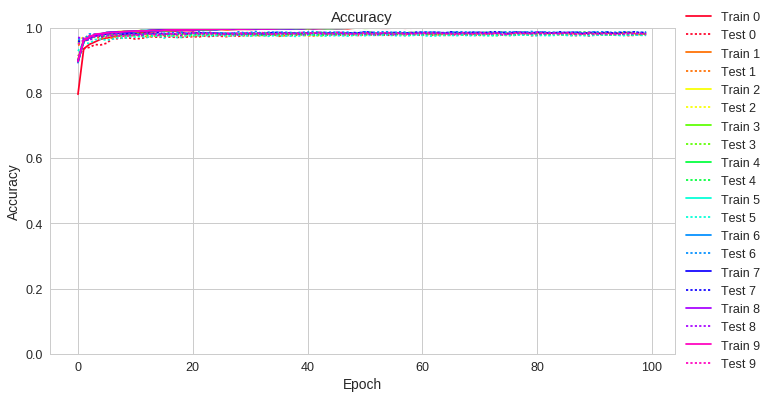

In [35]:
plot_acc(tophistory)

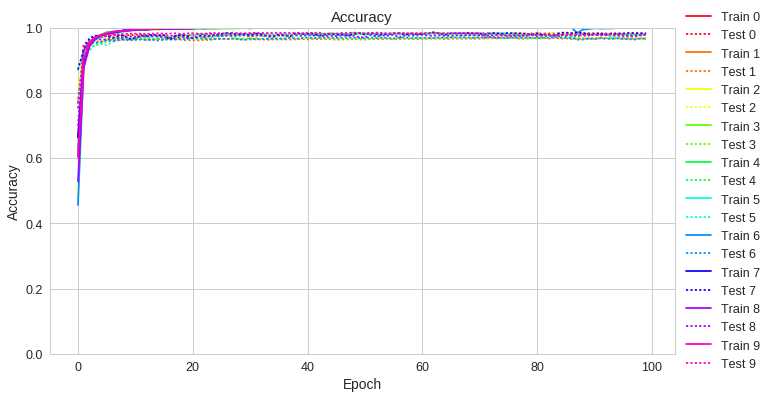

In [36]:
plot_acc(history)

In [37]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted')
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

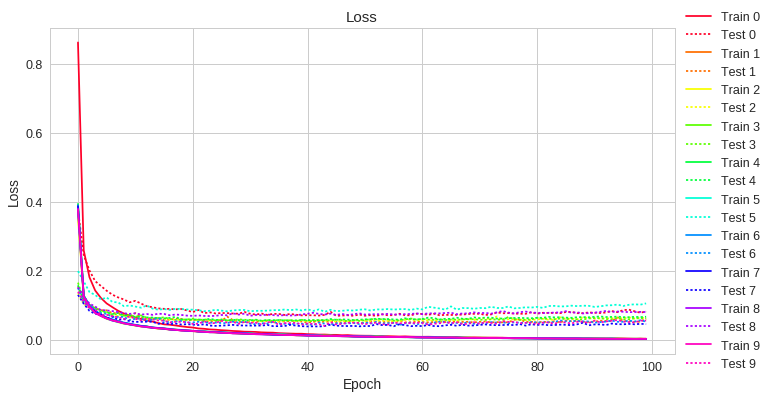

In [38]:
plot_loss(tophistory)

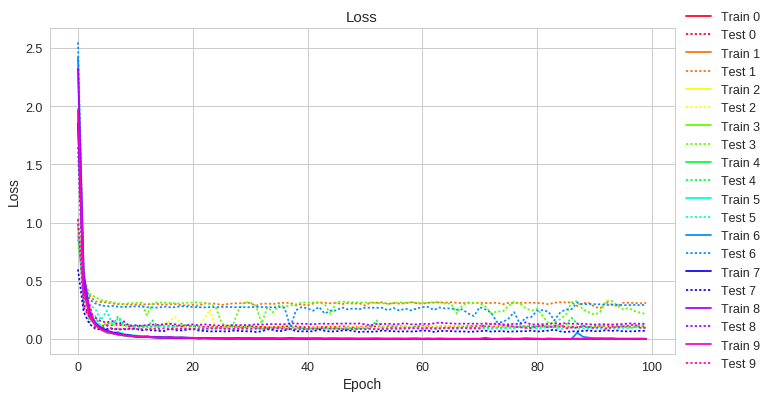

In [39]:
plot_loss(history)

Plotting the confusion matrix


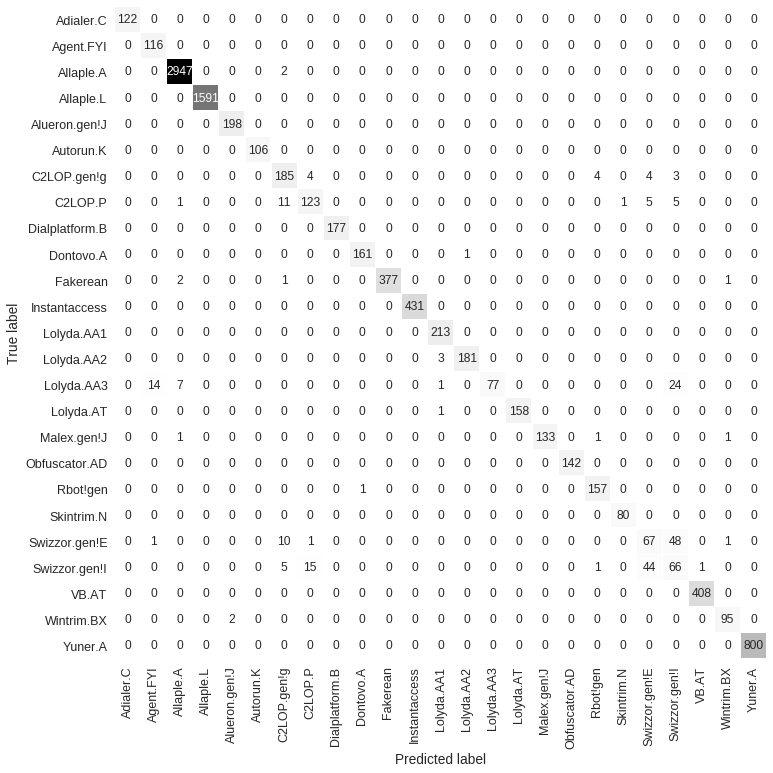

In [40]:
import seaborn as sns
plt.style.use('seaborn-whitegrid')

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(16, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 12}, linewidth = 0.2, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


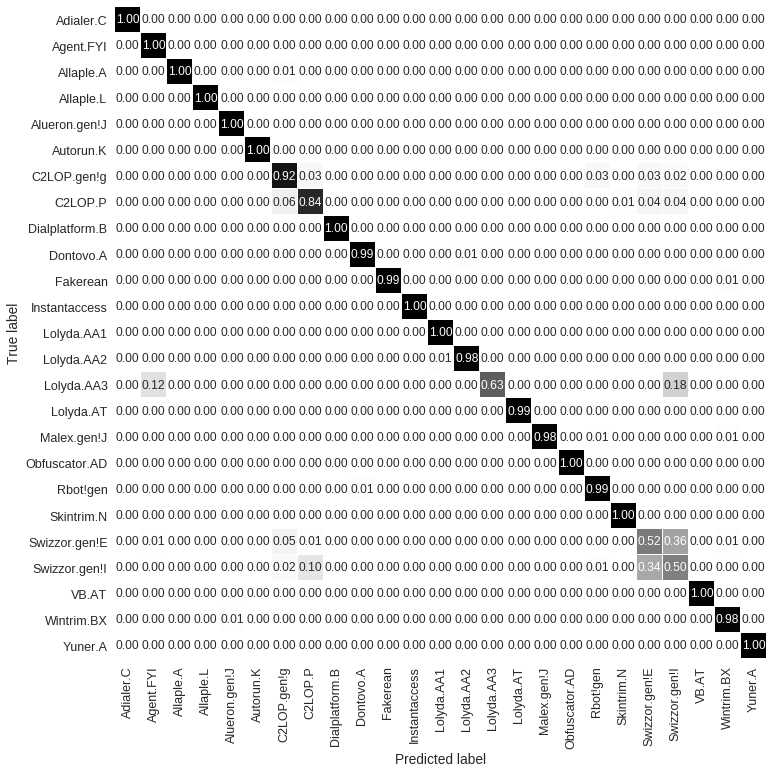

In [41]:
import seaborn as sns
plt.style.use('seaborn-whitegrid')

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(16, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 12}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [42]:
for h in tophistory:
    print(h.history)

{'acc': [0.79568739575887537, 0.93495353821319771, 0.94889206576125806, 0.95663569213266397, 0.96485584941624969, 0.96807243269001664, 0.9717655468191565, 0.97510126280676679, 0.98022396947362178, 0.98189182749583037, 0.98427448177269483, 0.98463187991422441, 0.98618060516578288, 0.98713366690493209, 0.98784846318799147, 0.98999285200876597, 0.98999285200876597, 0.98963545389563978, 0.9905885156063855, 0.99094591374791519, 0.99035025017869904, 0.99285203716940673, 0.99380509888015245, 0.99320943531093642, 0.99404336430783891, 0.99428162973552536, 0.99392423159399568, 0.99428162973552536, 0.99463902787705505, 0.99487729330474151, 0.99463902787705505, 0.99511555873242796, 0.99571122230164399, 0.99594948772933045, 0.99583035501548722, 0.99571122230164399, 0.99654515129854659, 0.99606862044317368, 0.99594948772933045, 0.99594948772933045, 0.99714081486776274, 0.99606862044317368, 0.99749821300929231, 0.99654515129854659, 0.99749821300929231, 0.99714081486776274, 0.99797474386466523, 0.9967

In [43]:
for h in history:
    print(h.history)

{'acc': [0.6633309506932582, 0.90290683818937112, 0.95413390517035979, 0.97152728140567179, 0.97843697879437697, 0.98522754348344055, 0.98665713602115579, 0.9873719323468203, 0.99261377174172027, 0.99309030261129494, 0.99440076244936859, 0.99344770075282451, 0.99487729331184238, 0.99440076244936859, 0.99702168215391951, 0.99809387657850845, 0.99749821300929231, 0.99773647843697877, 0.99678341669782955, 0.99809387657850845, 0.99761734572313554, 0.99845127472003814, 0.99773647843697877, 0.99880867286156783, 0.99821300934915858, 0.99833214200619491, 0.99845127472003814, 0.99904693828925428, 0.99892780557541105, 0.9995234691162237, 0.99928520371694063, 0.99940433643078386, 0.9995234691162237, 0.9986895401477246, 0.99892780557541105, 0.99952346914462709, 0.99904693828925428, 0.99928520368853724, 0.99976173457231354, 0.9986895401477246, 0.99940433643078386, 0.99952346914462709, 0.9995234691162237, 0.99928520371694063, 0.99988086728615677, 0.99940433643078386, 0.99928520371694063, 0.999285203

In [44]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

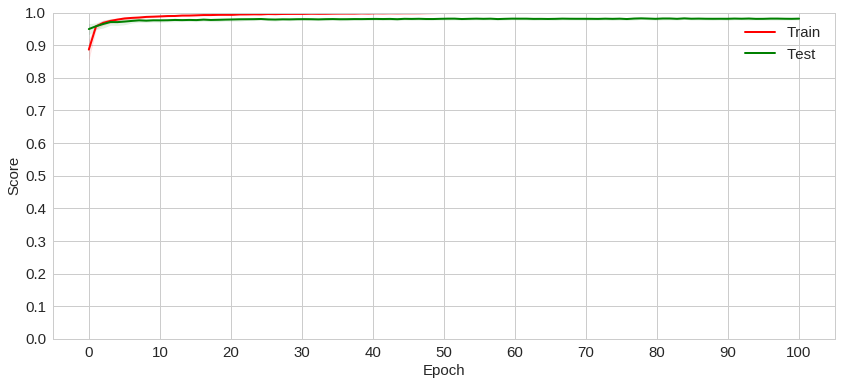

In [45]:
plot_mean_acc(tophistory)

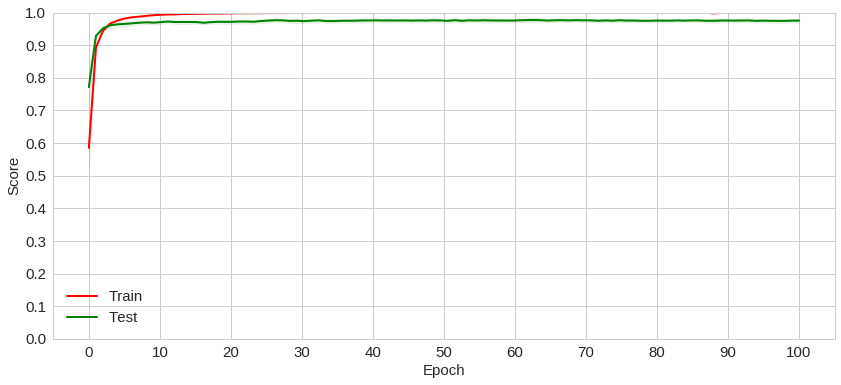

In [46]:
plot_mean_acc(history)

In [47]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

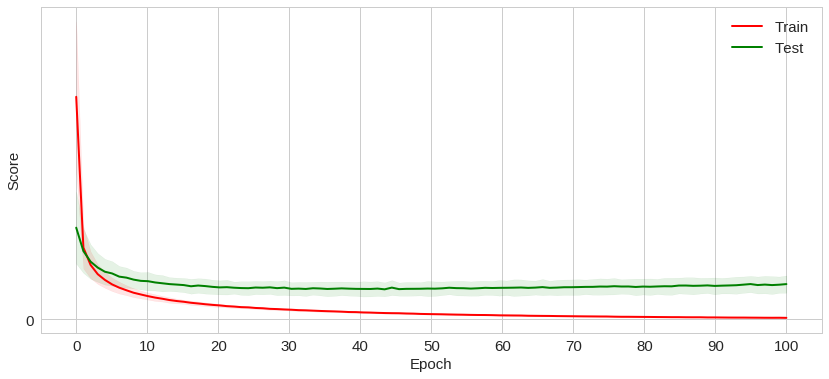

In [48]:
plot_mean_loss(tophistory)

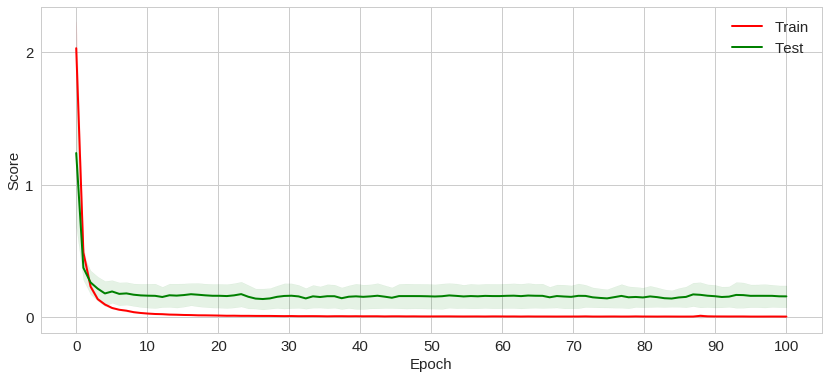

In [49]:
plot_mean_loss(history)

In [51]:
tophist = [{'acc': [0.79568739575887537, 0.93495353821319771, 0.94889206576125806, 0.95663569213266397, 0.96485584941624969, 0.96807243269001664, 0.9717655468191565, 0.97510126280676679, 0.98022396947362178, 0.98189182749583037, 0.98427448177269483, 0.98463187991422441, 0.98618060516578288, 0.98713366690493209, 0.98784846318799147, 0.98999285200876597, 0.98999285200876597, 0.98963545389563978, 0.9905885156063855, 0.99094591374791519, 0.99035025017869904, 0.99285203716940673, 0.99380509888015245, 0.99320943531093642, 0.99404336430783891, 0.99428162973552536, 0.99392423159399568, 0.99428162973552536, 0.99463902787705505, 0.99487729330474151, 0.99463902787705505, 0.99511555873242796, 0.99571122230164399, 0.99594948772933045, 0.99583035501548722, 0.99571122230164399, 0.99654515129854659, 0.99606862044317368, 0.99594948772933045, 0.99594948772933045, 0.99714081486776274, 0.99606862044317368, 0.99749821300929231, 0.99654515129854659, 0.99749821300929231, 0.99714081486776274, 0.99797474386466523, 0.99678341672623305, 0.99845127472003814, 0.99857040743388137, 0.99892780557541105, 0.99857040743388137, 0.9986895401477246, 0.99821300929235168, 0.99821300929235168, 0.9986895401477246, 0.9991660710030974, 0.99821300929235168, 0.99904693828925428, 0.9991660710030974, 0.99892780557541105, 0.99880867286156783, 0.99892780557541105, 0.99904693828925428, 0.99964260185847031, 0.99952346914462709, 0.99940433643078386, 0.99940433643078386, 0.99928520371694063, 0.99928520371694063, 0.99964260185847031, 0.99964260185847031, 0.99928520371694063, 0.99952346914462709, 0.99952346914462709, 0.99988086728615677, 0.99976173457231354, 0.99988086728615677, 0.99976173457231354, 0.99976173457231354, 0.99988086728615677, 1.0, 0.99964260185847031, 0.99988086728615677, 0.99964260185847031, 0.99988086728615677, 0.99988086728615677, 0.99976173457231354, 0.99976173457231354, 1.0, 0.99988086728615677, 1.0, 0.99988086728615677, 1.0, 0.99976173457231354, 0.99976173457231354, 1.0, 1.0, 0.99988086728615677, 0.99988086728615677], 'loss': [0.86277714050544685, 0.25994539965269875, 0.1819359590506906, 0.14338487090597501, 0.12177025252579933, 0.1059310575319183, 0.095082172770243986, 0.08466925840910941, 0.076796922057845746, 0.070995599036330209, 0.065062128599224514, 0.061255847804438282, 0.05607597959135327, 0.053316796744144232, 0.048955032962765162, 0.045300809544468315, 0.044174002644587963, 0.042032433245468626, 0.039589221132149195, 0.037537615601579602, 0.036098370685807742, 0.033393796403588999, 0.032404510037161806, 0.030502265532032162, 0.029796353865957186, 0.028403591054846963, 0.027495036704507019, 0.026116853611610789, 0.025366772924835464, 0.024109726325911244, 0.023784156316216287, 0.023303262821927025, 0.022068315704080438, 0.021514042387349223, 0.021189026159321108, 0.019842317132583283, 0.019216759847712296, 0.018595274420748452, 0.018054182002574297, 0.018076505007518867, 0.016970021367159156, 0.016605915925102716, 0.015668098003955678, 0.015747709368209784, 0.014862890879643341, 0.014843282689892283, 0.013802717457090117, 0.014176172207644193, 0.013036757048768872, 0.012588395744656235, 0.012320449956815246, 0.012229185150483567, 0.011689022889510348, 0.011045261686926315, 0.011059033906639593, 0.010560440964415876, 0.01003693586636103, 0.010461013161346285, 0.0096880431412337525, 0.0093074406534681894, 0.0091897621253216426, 0.0093587242743702823, 0.0090144368157958829, 0.0086771338286843799, 0.0083450901364006264, 0.0080113087236891901, 0.0084109453110670675, 0.0077971540431761976, 0.0073035141314569153, 0.0074155867349651322, 0.0071466461132234597, 0.0069035802736402635, 0.0069299925900667319, 0.0068621345822763051, 0.0065650299104704308, 0.0060931945642137319, 0.0060250844999362617, 0.0060258831434223314, 0.0057992371003153364, 0.0055782556521350559, 0.0053999161694801533, 0.0053898527121407904, 0.0053148941000728542, 0.0052804280015615991, 0.0049905366676355617, 0.0047883555285982331, 0.0048073057928725042, 0.0050562111942612023, 0.0044487341767577961, 0.0045097182090541761, 0.004508415538522958, 0.0042452747362002564, 0.0041390416756770477, 0.0040774685057749531, 0.0044617563694264095, 0.0040454331938036192, 0.0037229843897771532, 0.0035969869354382524, 0.0035498571797286369, 0.0035797017779576729], 'val_acc': [0.91322751322751328, 0.93544973544973542, 0.93968253968253967, 0.94814814814814818, 0.94708994708994709, 0.95238095238095233, 0.96613756613756618, 0.96613756613756618, 0.96931216931216935, 0.96825396825396826, 0.96507936507936509, 0.96719576719576716, 0.97037037037037033, 0.97248677248677251, 0.97037037037037033, 0.97142857142857142, 0.97142857142857142, 0.97037037037037033, 0.97037037037037033, 0.97142857142857142, 0.97248677248677251, 0.97142857142857142, 0.97460317460317458, 0.97248677248677251, 0.97566137566137567, 0.97354497354497349, 0.97248677248677251, 0.97566137566137567, 0.97354497354497349, 0.97566137566137567, 0.97566137566137567, 0.97671957671957677, 0.97671957671957677, 0.97566137566137567, 0.97883597883597884, 0.97566137566137567, 0.97671957671957677, 0.97566137566137567, 0.97671957671957677, 0.97777777777777775, 0.97566137566137567, 0.97566137566137567, 0.97671957671957677, 0.97671957671957677, 0.97777777777777775, 0.97883597883597884, 0.97671957671957677, 0.97671957671957677, 0.97777777777777775, 0.97566137566137567, 0.97883597883597884, 0.97777777777777775, 0.97671957671957677, 0.97777777777777775, 0.97671957671957677, 0.97777777777777775, 0.97989417989417993, 0.97777777777777775, 0.98095238095238091, 0.97671957671957677, 0.97777777777777775, 0.97883597883597884, 0.97671957671957677, 0.97989417989417993, 0.97671957671957677, 0.97671957671957677, 0.97883597883597884, 0.97777777777777775, 0.97777777777777775, 0.97671957671957677, 0.97671957671957677, 0.97883597883597884, 0.98095238095238091, 0.97671957671957677, 0.97777777777777775, 0.97883597883597884, 0.97671957671957677, 0.97989417989417993, 0.98095238095238091, 0.97566137566137567, 0.97671957671957677, 0.97883597883597884, 0.97883597883597884, 0.98095238095238091, 0.97883597883597884, 0.97777777777777775, 0.97671957671957677, 0.97566137566137567, 0.97989417989417993, 0.97460317460317458, 0.97777777777777775, 0.97777777777777775, 0.97777777777777775, 0.97883597883597884, 0.97989417989417993, 0.97777777777777775, 0.97566137566137567, 0.97671957671957677, 0.97883597883597884, 0.97883597883597884], 'val_loss': [0.37720839812090157, 0.24614889729748327, 0.20147295406571142, 0.17048332379766243, 0.1566171534950771, 0.14268997399501068, 0.13132591673306057, 0.1234010199311549, 0.11744442827329434, 0.10917353570934325, 0.11349818205470762, 0.10542759555712264, 0.0979354126349328, 0.094908821951381117, 0.091585483141834775, 0.090328858158102737, 0.090064171429664372, 0.088850664420339162, 0.089813325097833671, 0.085703685796923113, 0.080804043511549628, 0.086931012105689473, 0.077838701281755684, 0.08009996305776651, 0.076824086299412467, 0.078130201288750242, 0.078005204550803647, 0.076836061802884895, 0.076153163619773104, 0.081211955672888844, 0.076184219021409275, 0.07354214851936651, 0.07662707589093655, 0.072554273152398679, 0.075781969459007975, 0.075509947107700759, 0.07264705783534775, 0.075635828063995755, 0.073156672983218443, 0.071274345606151548, 0.071903060844769232, 0.071573067580413804, 0.070891320631992091, 0.07259201923749907, 0.08178789143958104, 0.070039842905545671, 0.070847628886500993, 0.071702887183646591, 0.070044510976643007, 0.07373018601229267, 0.070285706299051606, 0.072156527120664365, 0.069811672003072478, 0.074333682787609559, 0.071514152410247972, 0.072027021347761899, 0.076030227129973427, 0.07159355728537159, 0.071565724938009029, 0.075956387910991907, 0.075614581802470618, 0.072796276301667878, 0.076005438407057674, 0.071643876548851571, 0.072854394527526678, 0.072571199600432054, 0.072819811024545406, 0.073657432041548579, 0.075235549515241348, 0.075800471558363711, 0.075949181859916143, 0.072551841369556586, 0.074067039698271192, 0.079949745040130679, 0.077371547821657879, 0.077877882605408705, 0.076434044179164135, 0.076030177554015865, 0.075948066261557562, 0.080359295425042221, 0.076217726352991094, 0.078885492671138813, 0.078249516610669659, 0.07872424033660165, 0.077645376608646954, 0.081017250030608876, 0.08151258914297195, 0.077608456609557536, 0.077717853204126067, 0.079860976890589366, 0.07887369015425931, 0.078106488802571289, 0.079649341326279599, 0.083961121255249183, 0.080606981816750245, 0.086487487540665028, 0.087858573135873058, 0.083263000635445311, 0.078854834003402929, 0.082801779115145413]},
{'acc': [0.90044063355960458, 0.96105752054305105, 0.97213290460878887, 0.97582469929736815, 0.98035012514403541, 0.98249374786643628, 0.98523282124568301, 0.98511373109443845, 0.98797189472430635, 0.98749553411932833, 0.98916279623675119, 0.99023460769732818, 0.98999642729546267, 0.99130641895915206, 0.99166368941288552, 0.99130641895915206, 0.99285459092533046, 0.99321186137906392, 0.99440276289150886, 0.99333095153030848, 0.99368822198404194, 0.99511730379897578, 0.99499821364773133, 0.9940454924377754, 0.99476003334524232, 0.99547457435208586, 0.99356913183279738, 0.99583184470644281, 0.99678456591639875, 0.99595093485768726, 0.99607002500893171, 0.99666547576515419, 0.99630820531142072, 0.99607002500893171, 0.99738001667262122, 0.99726092652137666, 0.99654638561390974, 0.99714183637013221, 0.9984518280338216, 0.99773728712635468, 0.99761819707448673, 0.99821364773133259, 0.99857091818506605, 0.99833273788257715, 0.99857091828444267, 0.99833273788257715, 0.99833273798195366, 0.99797546742884369, 0.99869000833631061, 0.99928545909253308, 0.99869000833631061, 0.99916636894128852, 0.99940454924377753, 0.99928545909253308, 0.99904727879004407, 0.99952363939502198, 0.99928545909253308, 0.99904727879004407, 0.99928545909253308, 0.99964272954626654, 0.99940454924377753, 0.99892818863879962, 0.99940454924377753, 0.99940454924377753, 0.99940454924377753, 0.99988090984875555, 0.99988090984875555, 0.99964272954626654, 0.99952363939502198, 0.99976181969751099, 0.99988090984875555, 0.99976181969751099, 0.99952363939502198, 1.0, 0.99988090984875555, 0.99988090984875555, 0.99976181969751099, 0.99952363939502198, 0.99976181969751099, 1.0, 0.99940454924377753, 0.99976181969751099, 0.99976181969751099, 0.99964272954626654, 0.99976181969751099, 1.0, 0.99976181969751099, 1.0, 0.99988090984875555, 1.0, 0.99976181969751099, 0.99988090984875555, 1.0, 0.99976181969751099, 0.99988090984875555, 0.99988090984875555, 1.0, 1.0, 1.0, 1.0], 'loss': [0.36775416325823462, 0.12347659936230872, 0.094874797956111867, 0.079619292396068492, 0.070125879090542423, 0.063658635627233909, 0.057528258641704612, 0.053331670394249159, 0.048004854274843793, 0.046170011143902942, 0.04199782026537021, 0.039752557937610823, 0.037101630959071985, 0.035388712730421518, 0.033162899226184483, 0.032366238407678861, 0.03018081642949515, 0.028976046953718974, 0.027985131560666319, 0.027093483319771572, 0.025665322642312444, 0.024524171622393492, 0.023464114059337755, 0.023025311790943515, 0.022006411380898146, 0.02120852278831872, 0.021671791228990236, 0.020206611879445887, 0.018959055630858632, 0.018575071290893353, 0.017721011825203116, 0.017349701666965152, 0.017117114897009494, 0.016586404961295497, 0.015814989632199856, 0.015225370984528482, 0.015983340198548333, 0.014280325172191076, 0.013769130464085079, 0.013564344806973957, 0.013018178540715948, 0.012934909479894325, 0.012135931213769113, 0.011955123299343949, 0.011299941978476453, 0.011706053833224598, 0.011219272013574864, 0.011309699463488119, 0.010420501208779583, 0.0098818086988969305, 0.01041444717076646, 0.0095037434623360759, 0.0091614050781614401, 0.0088255410490168142, 0.0088148520783388647, 0.0084463145451301232, 0.0084748590116388977, 0.0086869257126822915, 0.008063092775531697, 0.0076004558657554976, 0.0076193836636667608, 0.0076732998174596544, 0.0072394471991168042, 0.0072324841674837751, 0.0068596668796083874, 0.0063573433483681803, 0.0064186610087703586, 0.0062630452258601163, 0.0062371701648401383, 0.0059301305963867755, 0.0060418957634423122, 0.0058633503736993959, 0.0058052964491952233, 0.0052688280833651938, 0.0056710713194736209, 0.0052485008641626699, 0.0051089012984583083, 0.0054807621976579171, 0.0051596127421577216, 0.0046564702910828464, 0.0051817508013082721, 0.0048354639588503948, 0.0045400564977771648, 0.004514303368965346, 0.0043745729558740372, 0.0040735757029744558, 0.0040783960410141233, 0.0038539000024401661, 0.0037710095100346097, 0.0037977539898615387, 0.003890775815113834, 0.0036390808428716096, 0.0034550118453072843, 0.0036271361840614046, 0.003490083925167115, 0.0035296304764956595, 0.0031279125939080855, 0.0031189020425085689, 0.0036852964334503991, 0.0029272692148413762], 'val_acc': [0.94585987261146498, 0.95435244161358812, 0.9713375796178344, 0.97027600849256901, 0.96815286624203822, 0.96815286624203822, 0.96921443736730362, 0.97452229299363058, 0.97558386411889597, 0.97558386411889597, 0.97664543524416136, 0.97558386411889597, 0.97239915074309979, 0.97239915074309979, 0.97664543524416136, 0.97664543524416136, 0.97558386411889597, 0.97558386411889597, 0.97452229299363058, 0.97770700636942676, 0.97346072186836519, 0.97558386411889597, 0.97558386411889597, 0.97876857749469215, 0.98195329087048833, 0.97770700636942676, 0.98089171974522293, 0.98089171974522293, 0.97770700636942676, 0.97876857749469215, 0.98301486199575372, 0.97664543524416136, 0.97452229299363058, 0.98301486199575372, 0.97876857749469215, 0.97346072186836519, 0.97558386411889597, 0.98195329087048833, 0.98089171974522293, 0.98089171974522293, 0.98407643312101911, 0.97558386411889597, 0.97983014861995754, 0.97876857749469215, 0.98301486199575372, 0.97664543524416136, 0.98301486199575372, 0.98301486199575372, 0.98195329087048833, 0.98195329087048833, 0.98195329087048833, 0.98407643312101911, 0.97983014861995754, 0.97770700636942676, 0.97983014861995754, 0.98407643312101911, 0.98195329087048833, 0.97558386411889597, 0.98301486199575372, 0.98195329087048833, 0.98407643312101911, 0.98195329087048833, 0.97770700636942676, 0.97770700636942676, 0.98089171974522293, 0.97983014861995754, 0.98195329087048833, 0.97876857749469215, 0.98301486199575372, 0.97983014861995754, 0.98195329087048833, 0.97983014861995754, 0.98301486199575372, 0.98301486199575372, 0.98407643312101911, 0.98195329087048833, 0.98301486199575372, 0.98301486199575372, 0.98195329087048833, 0.98089171974522293, 0.98301486199575372, 0.98407643312101911, 0.98195329087048833, 0.9851380042462845, 0.98195329087048833, 0.98407643312101911, 0.97983014861995754, 0.98407643312101911, 0.98089171974522293, 0.98407643312101911, 0.98195329087048833, 0.98301486199575372, 0.98407643312101911, 0.98195329087048833, 0.98301486199575372, 0.98407643312101911, 0.9851380042462845, 0.98195329087048833, 0.97876857749469215, 0.98195329087048833], 'val_loss': [0.15575240187805675, 0.11554193933298633, 0.10247718484285277, 0.09195662541374279, 0.086396048149991689, 0.085991196927561117, 0.07744798874937299, 0.078759836993969171, 0.07228603891063394, 0.067662689684556035, 0.077899973040679971, 0.065438977428840472, 0.062640206125068557, 0.06253677926514685, 0.063600278453557355, 0.059384709368449994, 0.058256685543971454, 0.062042715593444819, 0.061025656289134311, 0.057054773953816439, 0.057882943311251399, 0.058888604528331959, 0.053743877092222121, 0.05466254414385481, 0.055402936274482374, 0.055112062624187039, 0.067530919589110172, 0.057574508219340424, 0.052747861252832692, 0.051879863539461495, 0.053246702942522657, 0.052358698450827738, 0.054555586236183021, 0.05522251148725961, 0.050588299381900619, 0.053047145507248976, 0.053729658955292907, 0.054865364097019226, 0.055682138445927523, 0.053332942229499865, 0.05081560036301961, 0.052759265561979622, 0.052717519656116353, 0.052622292527924996, 0.053249692784586716, 0.052222068521892158, 0.050733337313779124, 0.054137559245526393, 0.051240277789274105, 0.049144060402117953, 0.050752777394427344, 0.054409417723683191, 0.0515443673251086, 0.05219679964422555, 0.052249290042896926, 0.050379695103235839, 0.055084553045950307, 0.051269687303132326, 0.051232240787255447, 0.053015577087313283, 0.052222922181111471, 0.051268849316109449, 0.052114894159949895, 0.053019272258422179, 0.051961999573777458, 0.054638665205934488, 0.051710270635446046, 0.052354129455561477, 0.052810304145666821, 0.050842501957480142, 0.052662545293033214, 0.053621214825019581, 0.050992473539122188, 0.051837250582909417, 0.0509619188620479, 0.05140038368393738, 0.058594307530679512, 0.059460638488782275, 0.052129989847717086, 0.052822700854402722, 0.050521211696704878, 0.053142458230825272, 0.051035756361794374, 0.054445513484970127, 0.050919046593564159, 0.056495411577430599, 0.054423116745104451, 0.055612172617098998, 0.052637102344815966, 0.052548257182161925, 0.053185695189042925, 0.055761844833311529, 0.055257625739026997, 0.054679248958618198, 0.065266360881442512, 0.055359009448614369, 0.054399462359672662, 0.052684608068398552, 0.053129309617338118, 0.061986638166523805]},
{'acc': [0.9026306393373269, 0.96107606237352694, 0.97250327342692588, 0.97690751101059403, 0.97940721342697301, 0.98404951791453399, 0.98464468516362391, 0.987977621711701, 0.98857278895369594, 0.99000119033448397, 0.98928698977179907, 0.99119152481847395, 0.99047732412807998, 0.990715391152587, 0.992262825854065, 0.99273895964766101, 0.99309605999285799, 0.99238185930246403, 0.99345316033805497, 0.99369122723485304, 0.99464349482204495, 0.99428639447684797, 0.99404832758005002, 0.99523866206403999, 0.99547672896083794, 0.99559576240923697, 0.99535769551243902, 0.99619092965123202, 0.99583382930603503, 0.99607189620283298, 0.99595286275443395, 0.99607189620283298, 0.99619092965123202, 0.99630996309963105, 0.99726223068682296, 0.99642899654802997, 0.997857397928818, 0.99797643137721703, 0.99738126413522199, 0.99761933103202005, 0.99773836448041897, 0.99773836448041897, 0.99773836448041897, 0.99809546482561595, 0.99738126413522199, 0.99845256517081304, 0.99797643137721703, 0.99869063206761099, 0.99892869896440895, 0.99904773241280798, 0.99869063206761099, 0.99845256517081304, 0.99857159861921196, 0.99904773241280798, 0.99904773241280798, 0.99892869896440895, 0.99928579930960604, 0.99892869896440895, 0.99952386620640399, 0.99845256517081304, 0.99952386620640399, 0.99916676586120701, 0.99952386620640399, 0.99988096655160097, 0.99964289965480302, 0.99952386620640399, 0.99964289965480302, 0.99940483275800496, 0.99952386620640399, 0.99904773241280798, 0.99964289965480302, 0.99940483275800496, 0.99976193310320205, 1.0, 0.99940483275800496, 0.99976193310320205, 0.99988096655160097, 0.99976193310320205, 0.99964289965480302, 1.0, 0.99964289965480302, 0.99964289965480302, 0.99988096655160097, 0.99988096655160097, 0.99976193310320205, 0.99976193310320205, 0.99988096655160097, 0.99976193310320205, 0.99976193310320205, 0.99928579930960604, 0.99988096655160097, 0.99976193310320205, 0.99988096655160097, 0.99976193310320205, 0.99976193310320205, 0.99988096655160097, 1.0, 0.99988096655160097, 1.0, 1.0], 'loss': [0.35549115388964686, 0.12193134731798566, 0.093873760783697871, 0.081200074992915192, 0.069631171054138616, 0.061017547580542668, 0.056626211137462835, 0.051277339511677678, 0.047297308446945657, 0.044587102185532586, 0.041404803999547886, 0.039216205358597038, 0.037343899177651421, 0.035029486554720587, 0.033231626029342855, 0.031993633063180586, 0.030295918196876083, 0.03020273745565482, 0.028279384923838333, 0.026374468212503149, 0.025525576658631179, 0.024777165074963439, 0.023545907347412853, 0.023317824135632131, 0.022066824795029069, 0.021950308434818631, 0.021036422580142235, 0.019768634676461474, 0.019232942254582185, 0.018881333211053074, 0.018020158019211727, 0.017750482333105898, 0.017998551204556717, 0.016544405350885305, 0.016135438742800535, 0.016108524555286309, 0.014814599941289187, 0.014327124598630172, 0.013781522941417436, 0.013803392244894677, 0.013716924672484275, 0.01315017320497449, 0.012566554725370568, 0.012295432935952528, 0.012187103602852073, 0.011618633328743768, 0.011299004053694552, 0.01070454398296714, 0.010373222194554379, 0.010263215906988112, 0.010216027691804247, 0.010041441520749849, 0.010130523468376403, 0.0091548489766704148, 0.0089966572427925048, 0.0090898081733492755, 0.008332831476047322, 0.0084236864367888617, 0.0079201870815070827, 0.0083719709113726018, 0.0078840477635806865, 0.0075885598005859351, 0.0074527417174889109, 0.0069643636877638445, 0.0068152570236643222, 0.0067756757080476146, 0.0067689926595776414, 0.0066362737482104353, 0.006566138099590794, 0.0064844031140976269, 0.005948686568236535, 0.0059622141420965381, 0.0055777354564115538, 0.0053521497796459568, 0.0058530749363560662, 0.0053334262022727971, 0.0051714152060786138, 0.0052296321320497927, 0.005033163213453865, 0.0048419322036743276, 0.0049626292617001707, 0.0048111494354648281, 0.0044839671797008724, 0.0042973438755862627, 0.004546101458030128, 0.0045576412456673617, 0.0043736761890663511, 0.0043557600851881657, 0.0042951812906907565, 0.0043039516291418743, 0.0039701499072055512, 0.003691672949170732, 0.0038188112309075631, 0.0034834809447268976, 0.0035438992083095182, 0.0034791009671850687, 0.0033578457021357999, 0.0033466832635744852, 0.0033811923334726001, 0.0030715975976538445], 'val_acc': [0.95735607675906187, 0.97228144989339016, 0.96801705756929635, 0.97441364605543712, 0.97441364605543712, 0.97867803837953093, 0.97761194029850751, 0.97761194029850751, 0.97547974413646055, 0.97441364605543712, 0.97441364605543712, 0.97761194029850751, 0.97547974413646055, 0.97547974413646055, 0.97441364605543712, 0.97761194029850751, 0.97761194029850751, 0.97547974413646055, 0.97547974413646055, 0.97547974413646055, 0.97547974413646055, 0.97761194029850751, 0.97867803837953093, 0.97867803837953093, 0.98081023454157779, 0.97654584221748397, 0.9733475479744137, 0.97761194029850751, 0.97654584221748397, 0.97654584221748397, 0.97547974413646055, 0.97654584221748397, 0.97654584221748397, 0.97654584221748397, 0.97867803837953093, 0.97761194029850751, 0.97654584221748397, 0.97761194029850751, 0.97867803837953093, 0.97654584221748397, 0.97547974413646055, 0.97654584221748397, 0.97441364605543712, 0.97547974413646055, 0.97974413646055436, 0.97974413646055436, 0.97867803837953093, 0.97654584221748397, 0.97654584221748397, 0.97761194029850751, 0.97761194029850751, 0.97867803837953093, 0.97867803837953093, 0.97867803837953093, 0.98081023454157779, 0.97867803837953093, 0.97761194029850751, 0.97867803837953093, 0.97654584221748397, 0.98081023454157779, 0.97867803837953093, 0.97867803837953093, 0.97867803837953093, 0.97654584221748397, 0.97654584221748397, 0.97761194029850751, 0.98081023454157779, 0.97761194029850751, 0.97867803837953093, 0.98081023454157779, 0.97654584221748397, 0.97867803837953093, 0.97867803837953093, 0.97547974413646055, 0.97761194029850751, 0.97547974413646055, 0.97867803837953093, 0.98081023454157779, 0.97867803837953093, 0.97974413646055436, 0.97974413646055436, 0.98081023454157779, 0.97867803837953093, 0.97867803837953093, 0.97654584221748397, 0.97974413646055436, 0.97974413646055436, 0.97761194029850751, 0.97761194029850751, 0.97867803837953093, 0.98081023454157779, 0.97867803837953093, 0.97867803837953093, 0.97867803837953093, 0.97974413646055436, 0.97974413646055436, 0.98081023454157779, 0.97974413646055436, 0.98187633262260132, 0.98081023454157779], 'val_loss': [0.13548761291671663, 0.103392052482059, 0.094105335774579288, 0.079776090949074799, 0.080554771731530167, 0.077086087101812306, 0.069614600564942938, 0.06992649799312102, 0.072109874171107563, 0.065486662018337236, 0.06270849661055658, 0.062319365169193702, 0.060984998893763208, 0.060337878398295401, 0.059409509460602618, 0.058484633101710377, 0.059662259106379331, 0.058629984885994302, 0.058306632069016949, 0.058988756581600799, 0.058167517034293237, 0.058437717017104061, 0.059181319911088513, 0.056402136044485421, 0.057197331808316806, 0.059883146122820786, 0.055488225396798013, 0.054829055877295196, 0.05712328903249967, 0.053586686846675044, 0.05319083305492775, 0.058391227834681265, 0.053951332054194265, 0.057008204371062743, 0.053764995355814346, 0.053598380645117495, 0.055806827446473625, 0.057891531084884588, 0.054390503015162656, 0.056378477560812983, 0.055060701971468548, 0.057538511030483186, 0.058042828331955634, 0.056269228930023119, 0.055184473787476103, 0.053606913044754824, 0.055092724546023618, 0.054112467861700569, 0.054482871639494626, 0.058443871271391432, 0.055461590343625591, 0.055178122855087462, 0.056215699316550502, 0.055940861389763764, 0.055514267179680596, 0.054548691695820148, 0.054538580740162573, 0.058269615394315487, 0.058705958727149489, 0.057324258565926538, 0.057192025066384163, 0.056689933934526988, 0.057009623667323539, 0.054912890814160849, 0.056163615347303228, 0.058411585989962718, 0.056661079916519731, 0.058968681324425259, 0.061656249734485691, 0.057667374651360785, 0.063134515204646594, 0.062026717373654484, 0.060802526958187476, 0.068169806851942877, 0.057302002970780579, 0.060210520153066445, 0.05916303693834913, 0.059333685686430042, 0.057766667151951973, 0.057716146745598135, 0.059483612248859459, 0.061575860778566201, 0.058820609033634855, 0.058490017443297876, 0.065907765953761355, 0.061575380412351367, 0.061751897942600227, 0.05960593818311035, 0.065877714450489719, 0.063446474825864213, 0.061855284186757863, 0.06267006875708081, 0.062565441905431618, 0.062965841271383605, 0.063066718064428276, 0.062779296973798637, 0.065683293924358219, 0.062103517711220156, 0.064186321508529945, 0.06419998519013384]},
{'acc': [0.89444246112512971, 0.95715815785043823, 0.97191479243537604, 0.97655599190765208, 0.98119719147923357, 0.98191122218255389, 0.98441032964417474, 0.98512436034749495, 0.98786147809320868, 0.98952754968463641, 0.98774247292633588, 0.98845650362965609, 0.98869451386409613, 0.99107461620849702, 0.99107461620849702, 0.99143163160980985, 0.99107461620849702, 0.99226466738069741, 0.9938117339045579, 0.9938117339045579, 0.99369272878733783, 0.99369272883699067, 0.99309770320123769, 0.99547780554563847, 0.99488277995953822, 0.99535880047807124, 0.99583482089729858, 0.99666785671783886, 0.99654885160061879, 0.9969058669522789, 0.99512079019397837, 0.99666785671783886, 0.99607283113173861, 0.99642984648339883, 0.99678686183505893, 0.99666785671783886, 0.99773890277281918, 0.99642984648339883, 0.99761989770525195, 0.99797691300725933, 0.99773890277281918, 0.99857193859335946, 0.99797691300725933, 0.99678686183505893, 0.99797691300725933, 0.99773890277281918, 0.99761989765559922, 0.99857193859335946, 0.99833392835891943, 0.99904795911189248, 0.99797691300725933, 0.99857193859335946, 0.99833392835891943, 0.99880994882779961, 0.99904795906223964, 0.99916696417945972, 0.99904795906223964, 0.99916696417945972, 0.99904795906223964, 0.99892895394501968, 0.99869094371057954, 0.99928596934633251, 0.99940497441389975, 0.99952397953111982, 0.99952397953111982, 0.99976198976555997, 0.99976198976555997, 0.99940497441389975, 0.99892895394501968, 0.99964298464833989, 0.99892895399467241, 0.99892895394501968, 0.99928596929667979, 0.99940497441389975, 0.99928596929667979, 0.99988099488277993, 0.99976198976555997, 0.99928596929667979, 0.99988099488277993, 0.99976198976555997, 0.99988099488277993, 0.99988099488277993, 1.0, 0.99988099488277993, 0.99988099488277993, 0.99976198976555997, 0.99976198976555997, 1.0, 0.99964298464833989, 0.99976198976555997, 0.99988099488277993, 0.99988099488277993, 0.99988099488277993, 0.99976198976555997, 0.99964298464833989, 1.0, 0.99988099488277993, 0.99976198976555997, 1.0, 0.99976198976555997], 'loss': [0.39002770079071714, 0.12874404471941708, 0.095892517350762138, 0.080870497297027, 0.071666082104628784, 0.064132028609455716, 0.057794529813876339, 0.053676541673674992, 0.04917741603426716, 0.045425709702742179, 0.043311131079608621, 0.041156738615908128, 0.039525431384779465, 0.035558095398022849, 0.03440827121429467, 0.032995299580344611, 0.031544747361945465, 0.030005895016743969, 0.02842414787957516, 0.027348307094467009, 0.025985527347396929, 0.024841202430734746, 0.025114544598643044, 0.023147107448327348, 0.022914688215395617, 0.02182005416399295, 0.020843564131429394, 0.02012044547375513, 0.019417542281050661, 0.018806643664375157, 0.01902733299729158, 0.017430886499507026, 0.017683157541489979, 0.016614456289868674, 0.015815543959110775, 0.016324425466189309, 0.015038154297100991, 0.015256648458403894, 0.013999335345900032, 0.013432532255656398, 0.013049344529365533, 0.012817501811208462, 0.012565922103560667, 0.012552112139268023, 0.01233865418774522, 0.0121099951242119, 0.011537580127008441, 0.011347419496634086, 0.010980635990261124, 0.010343471222582508, 0.010404347328570679, 0.01011727800897624, 0.0098389764941750439, 0.0090653675116352996, 0.0090687481618200293, 0.0086278171209764973, 0.0085711183153224981, 0.0086691484627082604, 0.0082497055529174891, 0.0081404958283399012, 0.0083988199082975605, 0.0076627290867402921, 0.0078817413039558686, 0.0070254633405528351, 0.0068734184505974761, 0.0066529992893669589, 0.0064246266215040393, 0.0065304482195339721, 0.0069679095240084959, 0.0062011338003541893, 0.0066091959446395532, 0.0065566655209092772, 0.005815064102964544, 0.0058395544293787767, 0.0062976107960002739, 0.0052987085636490147, 0.0051866892966178366, 0.0053042461697730822, 0.0049151879425293477, 0.0051936998666990844, 0.0050611942803692666, 0.0048524744951204003, 0.0046229696196692588, 0.0044051092226501795, 0.0043526396959333797, 0.0045002357733416563, 0.0042422915229813904, 0.0040986324463420454, 0.0041226814676656488, 0.0041013373978374817, 0.0039520679114005844, 0.0038506429656036609, 0.0035765602068952738, 0.0038003320915071283, 0.003735718751126927, 0.0034748944118904914, 0.0035013991540383651, 0.0035549327636098266, 0.0034164637177103237, 0.003410696507444922], 'val_acc': [0.95512820512820518, 0.95833333333333337, 0.97435897435897434, 0.97756410256410253, 0.97756410256410253, 0.9786324786324786, 0.97756410256410253, 0.97970085470085466, 0.9786324786324786, 0.97649572649572647, 0.98076923076923073, 0.98076923076923073, 0.98076923076923073, 0.97970085470085466, 0.98183760683760679, 0.97756410256410253, 0.9786324786324786, 0.9786324786324786, 0.9786324786324786, 0.98076923076923073, 0.98183760683760679, 0.98397435897435892, 0.98076923076923073, 0.98397435897435892, 0.98290598290598286, 0.98397435897435892, 0.98183760683760679, 0.97970085470085466, 0.98076923076923073, 0.98290598290598286, 0.98183760683760679, 0.98183760683760679, 0.98183760683760679, 0.98397435897435892, 0.98183760683760679, 0.98183760683760679, 0.98183760683760679, 0.98397435897435892, 0.98290598290598286, 0.98183760683760679, 0.98183760683760679, 0.98397435897435892, 0.98611111111111116, 0.98290598290598286, 0.98397435897435892, 0.98183760683760679, 0.98397435897435892, 0.98290598290598286, 0.98290598290598286, 0.98397435897435892, 0.98290598290598286, 0.98611111111111116, 0.98183760683760679, 0.98397435897435892, 0.98397435897435892, 0.98397435897435892, 0.98397435897435892, 0.98290598290598286, 0.98611111111111116, 0.98397435897435892, 0.98183760683760679, 0.98290598290598286, 0.9850427350427351, 0.98290598290598286, 0.98290598290598286, 0.9850427350427351, 0.9850427350427351, 0.98397435897435892, 0.98397435897435892, 0.98397435897435892, 0.9850427350427351, 0.9850427350427351, 0.9850427350427351, 0.98290598290598286, 0.98717948717948723, 0.98290598290598286, 0.98397435897435892, 0.98611111111111116, 0.9850427350427351, 0.98290598290598286, 0.98397435897435892, 0.9850427350427351, 0.98290598290598286, 0.98397435897435892, 0.98397435897435892, 0.98397435897435892, 0.98397435897435892, 0.9850427350427351, 0.98717948717948723, 0.98397435897435892, 0.98397435897435892, 0.98397435897435892, 0.98611111111111116, 0.98397435897435892, 0.98397435897435892, 0.9850427350427351, 0.9850427350427351, 0.98290598290598286, 0.98183760683760679, 0.9850427350427351], 'val_loss': [0.16623471454422697, 0.11856502963182254, 0.10099870469580349, 0.092593105780517951, 0.085601255361341, 0.081191641780046314, 0.07331932871005474, 0.075102993247345984, 0.070315109151932925, 0.072855000439872086, 0.067257280214729473, 0.071392655643260375, 0.064416217378889903, 0.062583782105173305, 0.063674346750809088, 0.065805331071536258, 0.061001832378057078, 0.058436752878065802, 0.059233620671284758, 0.059338326064439922, 0.062131859449685641, 0.057607745242297143, 0.059483141431377992, 0.05833017685983935, 0.05682922557044106, 0.058236734953541786, 0.056554868071077347, 0.057766577487604484, 0.059871053884331234, 0.058507214535155103, 0.05830158257825125, 0.056635340968242444, 0.055353682691183612, 0.057027351887275778, 0.05533891088830737, 0.058441542403406314, 0.05710652817048642, 0.056983413624489665, 0.054769746083607018, 0.058489169397104815, 0.055210655079517737, 0.054568128434455611, 0.056633811227133513, 0.056718491742180452, 0.057189901159383737, 0.058836612798189983, 0.057449317915349178, 0.054502493045173392, 0.057822325991757184, 0.055221085123713806, 0.057466891925567046, 0.060596200133550465, 0.059592922219387695, 0.06010822561926718, 0.059219634170846969, 0.055869631678200304, 0.057078081321938395, 0.059519301424585044, 0.06222804933965493, 0.059027793521955051, 0.060827122837291137, 0.059240603213035301, 0.058522546937879227, 0.059982281651111066, 0.057757502565265864, 0.05941852575039161, 0.058684332356947422, 0.05962019305652342, 0.060141315332237773, 0.060225611588540569, 0.058830370052178338, 0.058117719354833335, 0.060079642840284005, 0.0589877276388584, 0.059145902283489704, 0.066589469483876437, 0.060680219602226838, 0.058081938752257284, 0.058754625297514684, 0.059110601696172833, 0.064604425202093974, 0.060939903378125444, 0.062095670398791387, 0.060350705096503109, 0.061987535763978682, 0.060350763402607102, 0.061895650856921489, 0.059871835745863605, 0.059357844134896538, 0.062553321998966877, 0.063609236475005881, 0.063144029332170643, 0.060854484609624969, 0.059841584709355293, 0.063616491727903207, 0.059987391394424466, 0.06024075562636115, 0.062668119057679383, 0.063090604321315233, 0.062432947949183963]},
{'acc': [0.89493098530186066, 0.95871013802950977, 0.96906235126130413, 0.97382198952879584, 0.97965254640647315, 0.9852451213707758, 0.98512613041408847, 0.98619704899590455, 0.98750594954783433, 0.98821989528795806, 0.98964778676820564, 0.99036173250832937, 0.99000475963826751, 0.9915516420752023, 0.99226558778695639, 0.99107567824845311, 0.99250356972870057, 0.99321751546882442, 0.99357448833888629, 0.9936934792955735, 0.99381247025226083, 0.99452641599238456, 0.99440742503569723, 0.99476439787738946, 0.99500237981913375, 0.99619228938600668, 0.99547834364588295, 0.99571632555925749, 0.99607329842931935, 0.99702522608281774, 0.99595430747263203, 0.99726320799619228, 0.99678724416944309, 0.99714421703950495, 0.99702522608281774, 0.99809614469300334, 0.99643027129938122, 0.99762018083788451, 0.99762018083788451, 0.99750118990956682, 0.99773917182294147, 0.99809614469300334, 0.99869109947643975, 0.99845311756306521, 0.99821513564969067, 0.99833412660637788, 0.99881009043312707, 0.99904807234650161, 0.99833412657800824, 0.9989290813898144, 0.99916706330318894, 0.9989290813898144, 0.99881009043312707, 0.99940504521656359, 0.9989290813898144, 0.9989290813898144, 0.99928605425987627, 0.99964302712993813, 0.99857210851975253, 0.99964302712993813, 0.99964302712993813, 0.99916706330318894, 0.99964302712993813, 0.99976201808662546, 0.99904807234650161, 0.99952403617325081, 0.99964302712993813, 0.99952403617325081, 0.99964302712993813, 0.99976201808662546, 0.99940504521656359, 0.99988100904331267, 0.99976201808662546, 0.99976201808662546, 0.99976201808662546, 0.99964302712993813, 0.99988100904331267, 0.99988100904331267, 1.0, 0.99988100904331267, 0.99988100904331267, 0.99988100904331267, 0.99988100904331267, 0.99988100904331267, 0.99976201808662546, 0.99988100904331267, 1.0, 0.99988100904331267, 1.0, 0.99988100904331267, 1.0, 1.0, 0.99988100904331267, 1.0, 0.99988100904331267, 1.0, 1.0, 1.0, 1.0, 1.0], 'loss': [0.39463803417509025, 0.12964683957309284, 0.099156872523165726, 0.083524944500971948, 0.072144386831534471, 0.064127190060282335, 0.058370171980963385, 0.054417239104010612, 0.049290658555914253, 0.045358634206764704, 0.0431862876106449, 0.040493126420471738, 0.038443844870037831, 0.035905201869286675, 0.033729633819072485, 0.033375546346812633, 0.031078801037781809, 0.02911619056767116, 0.028684469970960042, 0.026424103527764715, 0.02611748706706769, 0.025315509625896279, 0.024012500265066197, 0.023658047646979159, 0.022591052028124017, 0.0214694324680921, 0.020568003574796712, 0.019662281715518121, 0.019652774888376703, 0.018773837759957845, 0.018589775816939491, 0.017098207354744179, 0.016804166456388804, 0.016000097590993544, 0.016098778413831196, 0.014906396510222238, 0.015655127560976062, 0.014321979360459022, 0.014058525796832498, 0.013889758584348008, 0.013397003753594603, 0.013094203618453946, 0.012117582563043123, 0.011949802000166007, 0.011408761794413344, 0.011551130918527943, 0.011080310832459066, 0.010474502371410453, 0.010300182743172655, 0.010120832233285014, 0.0095382788041690775, 0.0094391145748527333, 0.0094170736013532656, 0.0090607834560663628, 0.0090336956754007661, 0.0085015428186691715, 0.0083031076978916912, 0.0081318840282529892, 0.0084967215244934457, 0.0074828267414969478, 0.0073645916133090635, 0.0075573147077739296, 0.0072122515788831986, 0.0069852085795547407, 0.0074634168082950147, 0.0070939447497173269, 0.0065128762289220783, 0.0060778678744377078, 0.0059964768322577425, 0.0060466063033340805, 0.0058915008315682431, 0.0057768894337083985, 0.0058379568865524738, 0.0056620541077909746, 0.0054666293473131441, 0.0054384764557729153, 0.0049723498681706439, 0.0048091034460065888, 0.0047609141069155864, 0.0046383724537948905, 0.0046828146746453261, 0.0046824246228983606, 0.0043993269617910091, 0.0043458625498246448, 0.0044639970031912675, 0.0041793229936091872, 0.0038561572647453604, 0.0040361611516095668, 0.0037869511159209588, 0.0035705380292448867, 0.0035595686787979653, 0.0035378555195221817, 0.0036112610554632448, 0.003601067525056002, 0.0033440373121281603, 0.0032821870265441677, 0.0031182785434771404, 0.0032485020692694733, 0.0029673582615559325, 0.0029101567952104644], 'val_acc': [0.95187165775401072, 0.96042780748663104, 0.96256684491978606, 0.9732620320855615, 0.9732620320855615, 0.97540106951871652, 0.97433155080213907, 0.97647058823529409, 0.97433155080213907, 0.97754010695187166, 0.97647058823529409, 0.97647058823529409, 0.97754010695187166, 0.97433155080213907, 0.97647058823529409, 0.97754010695187166, 0.97647058823529409, 0.97860962566844922, 0.98074866310160425, 0.97860962566844922, 0.97860962566844922, 0.97754010695187166, 0.98074866310160425, 0.97647058823529409, 0.97754010695187166, 0.97860962566844922, 0.97860962566844922, 0.97967914438502679, 0.97754010695187166, 0.97967914438502679, 0.97967914438502679, 0.97860962566844922, 0.97754010695187166, 0.97754010695187166, 0.97860962566844922, 0.97860962566844922, 0.98074866310160425, 0.97754010695187166, 0.97967914438502679, 0.97967914438502679, 0.97967914438502679, 0.97754010695187166, 0.97860962566844922, 0.97754010695187166, 0.97967914438502679, 0.97967914438502679, 0.97860962566844922, 0.98074866310160425, 0.97860962566844922, 0.98288770053475938, 0.97860962566844922, 0.97967914438502679, 0.98074866310160425, 0.98074866310160425, 0.97967914438502679, 0.98074866310160425, 0.97967914438502679, 0.98288770053475938, 0.97754010695187166, 0.97967914438502679, 0.97860962566844922, 0.98074866310160425, 0.97967914438502679, 0.98074866310160425, 0.98074866310160425, 0.97754010695187166, 0.98181818181818181, 0.97860962566844922, 0.97860962566844922, 0.97967914438502679, 0.97647058823529409, 0.97647058823529409, 0.97540106951871652, 0.97754010695187166, 0.97967914438502679, 0.97860962566844922, 0.97860962566844922, 0.97860962566844922, 0.97754010695187166, 0.97860962566844922, 0.98181818181818181, 0.97860962566844922, 0.97754010695187166, 0.98395721925133695, 0.97860962566844922, 0.97754010695187166, 0.98074866310160425, 0.97967914438502679, 0.98288770053475938, 0.97860962566844922, 0.98181818181818181, 0.97967914438502679, 0.97754010695187166, 0.97754010695187166, 0.97754010695187166, 0.97967914438502679, 0.97754010695187166, 0.97754010695187166, 0.97860962566844922, 0.97967914438502679], 'val_loss': [0.15867857528641263, 0.11405330682820815, 0.099491529306147825, 0.09113132062761542, 0.082626183936621411, 0.080172739357234318, 0.075339404226624399, 0.078002354861262016, 0.071142305354064794, 0.071876847463097165, 0.066610654262218252, 0.068815610607597916, 0.065298759078676688, 0.065022195196327043, 0.063221409877035076, 0.062574761045130503, 0.064013362179863906, 0.066957462012249835, 0.059566781323223829, 0.059200617981785761, 0.059145775340736548, 0.0592188822493993, 0.058290404029549124, 0.061307134166021238, 0.057966852767323267, 0.059058457399833009, 0.057094465768871144, 0.058525868315986773, 0.057816947465712691, 0.056959309612206598, 0.056787417851946249, 0.058777255971323362, 0.055994353188889075, 0.058133711104087014, 0.057411243473951587, 0.057830325967288591, 0.056538846823859977, 0.05704610786814103, 0.056815943564661846, 0.058078424449771009, 0.057547472391954881, 0.057635677557309126, 0.057437099264511328, 0.058001910055051231, 0.060792491958416836, 0.058403749877268221, 0.059631652192506483, 0.058980063092023291, 0.057962470390973367, 0.058863034486561452, 0.059749264233088233, 0.059815836029082414, 0.061614126167546482, 0.060810201012350143, 0.060645311009163726, 0.05959667586111389, 0.058792153361781355, 0.062844190865202265, 0.060671445195261825, 0.059504031197150503, 0.060983582055893416, 0.064516794006340208, 0.063546350850184563, 0.059439898654569522, 0.06139751240417466, 0.061061369634748883, 0.064557079721010602, 0.061568920447816075, 0.061233676593834135, 0.06549478877154627, 0.063379567218253413, 0.064804683045364603, 0.064795434599048782, 0.061992397563461026, 0.062201602693882467, 0.062871316599442978, 0.063708641623049719, 0.064157653911590812, 0.063411496740667511, 0.062975938176147314, 0.064331002850091717, 0.064338623061321709, 0.066935485223044253, 0.065518739791636804, 0.065820857343394032, 0.064776857465008816, 0.064346853989540015, 0.066102122450718989, 0.066331952045129094, 0.065740368271310051, 0.067145560327290132, 0.068146928677182542, 0.066508379962402997, 0.066777371900583513, 0.067747923401393711, 0.066192098270426561, 0.065969628376307599, 0.067073648516633444, 0.066441952982870894, 0.067323625063388876]},
{'acc': [0.89516896715849592, 0.96204188478838426, 0.97263207996192291, 0.97822465489785593, 0.98143741075678248, 0.98369823890547137, 0.98619704902427419, 0.98679200377934095, 0.98750594954783433, 0.98833888624464539, 0.98893384102808191, 0.99059971442170391, 0.99143265111851497, 0.99226558781532603, 0.99190861494526417, 0.99202760590195149, 0.99333650642551163, 0.99297953355544977, 0.99309852451213709, 0.99381247025226083, 0.99297953355544977, 0.99500237981913375, 0.99512137077582108, 0.99535935268919562, 0.99500237981913375, 0.99595430747263203, 0.99571632555925749, 0.99607329842931935, 0.99702522608281774, 0.99619228938600668, 0.99726320799619228, 0.99738219895287961, 0.99726320799619228, 0.99773917182294147, 0.9970252260544481, 0.99738219895287961, 0.99738219895287961, 0.99726320799619228, 0.99785816272288941, 0.99773917182294147, 0.99833412660637788, 0.99845311756306521, 0.99833412660637788, 0.99726320799619228, 0.99797715373631601, 0.99833412660637788, 0.99845311756306521, 0.99928605425987627, 0.9989290813898144, 0.99833412660637788, 0.99904807234650161, 0.99881009043312707, 0.99869109947643975, 0.99881009043312707, 0.99940504521656359, 0.99904807234650161, 0.99952403617325081, 0.99940504518819384, 0.99940504521656359, 0.99988100904331267, 0.99940504521656359, 0.9989290813898144, 0.9989290813898144, 0.99964302712993813, 0.99976201808662546, 0.99964302712993813, 0.99952403617325081, 0.99952403617325081, 0.99964302712993813, 0.99964302712993813, 0.99952403617325081, 0.99964302712993813, 0.99976201808662546, 0.99952403617325081, 0.99988100904331267, 0.99976201808662546, 0.99988100904331267, 0.99988100904331267, 1.0, 0.99988100904331267, 1.0, 1.0, 0.99988100904331267, 0.99988100904331267, 0.99988100904331267, 1.0, 0.99976201808662546, 0.99976201808662546, 0.99976201808662546, 0.99988100904331267, 1.0, 0.99988100904331267, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99988100904331267, 1.0, 1.0], 'loss': [0.37847542642894555, 0.1223856164040536, 0.093726539621745791, 0.078894488846813146, 0.070671772680953246, 0.062081870608304807, 0.056124234054306756, 0.05200947528932845, 0.047862694569921448, 0.045106708599180909, 0.042325931768341325, 0.039596915065529432, 0.037072208791355941, 0.035757484852022951, 0.034348106875249682, 0.033000861129225692, 0.030643131374702856, 0.029601011421045608, 0.028196923949820891, 0.027121709157464081, 0.026130257306468879, 0.02500464856227428, 0.023613812845166612, 0.022277393414665975, 0.022330854272470765, 0.021815764787352011, 0.020857444046324971, 0.01967900870159545, 0.019355512294618644, 0.018638570706534248, 0.018125059695711366, 0.017173528779867234, 0.017106645513168123, 0.015958184787829798, 0.015783873031617119, 0.015807146545493356, 0.015113872428934867, 0.014432082100745215, 0.013849176983767921, 0.013420225041180402, 0.012993020646722685, 0.012446823231131193, 0.012238437781506694, 0.012165674390089563, 0.012427658294112569, 0.011472714985536854, 0.011076129913092482, 0.010567528869015214, 0.0099664946383256278, 0.010362730705060033, 0.0094457776265760539, 0.0093689635959518149, 0.0094098357602542555, 0.0095112434664172876, 0.0091406123314597167, 0.0084752369055795754, 0.0083175838589384585, 0.0080414491006107151, 0.0077880511387494675, 0.0075865924583995333, 0.0072799192842136875, 0.0072919549677021864, 0.0074707695892583118, 0.006727371084349126, 0.0065288455538036767, 0.0062424649550060409, 0.0062745950612080404, 0.0066180269568611111, 0.006228866827960566, 0.0061399888150617376, 0.0057316973050625733, 0.0056417443623756553, 0.0054121659492511083, 0.0055595653123625228, 0.0052000408635777496, 0.0050790534806444436, 0.0050215333409169456, 0.0047317765686822359, 0.0046259923567680706, 0.0047483012376744113, 0.0044373319196607426, 0.0043840636400043122, 0.0042457194646497607, 0.0043061660879292925, 0.0041849614813749183, 0.0040547596969889316, 0.003964126176720659, 0.0040084604477099378, 0.0037401098953466906, 0.0039081550559408205, 0.0035384206443448423, 0.0033637052261160207, 0.0033010145666934141, 0.0034268736072815068, 0.003228395672151327, 0.003037396833720151, 0.003055104839385907, 0.0031518342238225873, 0.003033830477514334, 0.0028973233907390555], 'val_acc': [0.92834224598930482, 0.95294117647058818, 0.95187165775401072, 0.96363636363636362, 0.96470588235294119, 0.9614973262032086, 0.96470588235294119, 0.96898395721925135, 0.96684491978609621, 0.97219251336898393, 0.97112299465240637, 0.9732620320855615, 0.97005347593582891, 0.97433155080213907, 0.97540106951871652, 0.96791443850267378, 0.97647058823529409, 0.97005347593582891, 0.97005347593582891, 0.97433155080213907, 0.97540106951871652, 0.97540106951871652, 0.97540106951871652, 0.97540106951871652, 0.97540106951871652, 0.97754010695187166, 0.9732620320855615, 0.97540106951871652, 0.97754010695187166, 0.97540106951871652, 0.97433155080213907, 0.97540106951871652, 0.97647058823529409, 0.9732620320855615, 0.97540106951871652, 0.97540106951871652, 0.97433155080213907, 0.97433155080213907, 0.9732620320855615, 0.97540106951871652, 0.97754010695187166, 0.97754010695187166, 0.97540106951871652, 0.97433155080213907, 0.97540106951871652, 0.97540106951871652, 0.97540106951871652, 0.97433155080213907, 0.97647058823529409, 0.97647058823529409, 0.97540106951871652, 0.97647058823529409, 0.97647058823529409, 0.97647058823529409, 0.97754010695187166, 0.97540106951871652, 0.97540106951871652, 0.97540106951871652, 0.97540106951871652, 0.97754010695187166, 0.97647058823529409, 0.97433155080213907, 0.97433155080213907, 0.97540106951871652, 0.97647058823529409, 0.97647058823529409, 0.97540106951871652, 0.97754010695187166, 0.97540106951871652, 0.97540106951871652, 0.97754010695187166, 0.97540106951871652, 0.97647058823529409, 0.97540106951871652, 0.97754010695187166, 0.97540106951871652, 0.97647058823529409, 0.97754010695187166, 0.97754010695187166, 0.97647058823529409, 0.97540106951871652, 0.97647058823529409, 0.97540106951871652, 0.97647058823529409, 0.97860962566844922, 0.97647058823529409, 0.97540106951871652, 0.97647058823529409, 0.97540106951871652, 0.97540106951871652, 0.97647058823529409, 0.97754010695187166, 0.97754010695187166, 0.97754010695187166, 0.97647058823529409, 0.97540106951871652, 0.97754010695187166, 0.97754010695187166, 0.97647058823529409, 0.97647058823529409], 'val_loss': [0.19972281559584612, 0.16978600276982719, 0.13899096925469007, 0.13045335627972762, 0.11754071353112951, 0.12318314535015407, 0.11033525638242456, 0.10893520501487076, 0.098020796902119151, 0.10002735472498411, 0.096851153277298985, 0.093649306845537475, 0.10003007808550794, 0.090827256180146795, 0.087869757747546559, 0.089680916190466142, 0.087322358848815937, 0.090390125379205391, 0.089806737973887649, 0.08843422212742548, 0.08780546877234377, 0.086242396032865987, 0.083428204937135791, 0.084663547736836625, 0.087531253743299189, 0.085139222967533026, 0.083049729568535152, 0.085714306302846752, 0.086791719691479266, 0.087063918158631112, 0.083340184184608049, 0.084466852596338418, 0.084599113985298471, 0.08507696396091026, 0.086422857856826185, 0.086447917489225368, 0.088357025757930016, 0.086502905254361828, 0.088387110649065223, 0.085620174449644385, 0.088876926444251741, 0.084336388098165627, 0.088670606784432893, 0.081694422993699417, 0.087509321532072748, 0.083555455144151122, 0.084615180393018546, 0.086299491869933145, 0.08525767122758901, 0.087734017739530629, 0.088961166657014368, 0.085231715356084439, 0.088706716428321591, 0.088354275262177512, 0.08972480369963369, 0.088210898601726428, 0.089212734003322205, 0.089583594434431452, 0.086999730170856326, 0.090958749765360891, 0.088648900019134433, 0.096274628620351951, 0.093845393023774884, 0.09131089514077835, 0.088057705634871225, 0.097361215945198767, 0.087980211160287633, 0.092634471725513118, 0.092349222048813281, 0.090425703658960147, 0.092859012311147682, 0.092164017772333157, 0.096252328378489529, 0.092778738462559157, 0.09272160983241641, 0.097172993204131836, 0.091841544732772049, 0.092832123110585044, 0.094813587668166305, 0.093988924824902259, 0.095975560478661903, 0.092980687475681084, 0.098501739580399622, 0.098899248194411385, 0.097250702164086378, 0.097489829320771201, 0.099468696375133434, 0.098136158074304605, 0.099462372757378348, 0.099001622995216004, 0.095975899857697375, 0.097471310533989372, 0.10019748281371714, 0.10075305358650391, 0.10266554092517652, 0.098528171082891497, 0.10202189270060828, 0.10342948687155289, 0.10245348825106207, 0.10606796378924238]},
{'acc': [0.8924833493046711, 0.96003805899143668, 0.96895813510941964, 0.97395337773548996, 0.97859181737355339, 0.98311132254995237, 0.98453853478554199, 0.98501427212178883, 0.9870361560418649, 0.98584681255946716, 0.98870123703064627, 0.98965271181656445, 0.98989058051304402, 0.99096098964720203, 0.99084205529896219, 0.99167459562321603, 0.9936964795432921, 0.99310180780209323, 0.99345861084681253, 0.9929828734538535, 0.9936964795432921, 0.99488582302568984, 0.99524262607040914, 0.99500475737392957, 0.99310180791551783, 0.99571836357679289, 0.99559942911512844, 0.99488582302568984, 0.99571836346336817, 0.99595623215984774, 0.99643196955280688, 0.99643196955280688, 0.99655090401447122, 0.99548049476688871, 0.99762131303520452, 0.99690770694576591, 0.99690770694576591, 0.99702664129400576, 0.99797811607992393, 0.99774024738344436, 0.99833491912464323, 0.99797811607992393, 0.99833491912464323, 0.99881065651760226, 0.99797811607992393, 0.99785918173168409, 0.99833491912464323, 0.99845385347288296, 0.99857278782112269, 0.99857278782112269, 0.99869172216936253, 0.99881065651760226, 0.99916745956232156, 0.9989295908658421, 0.9989295908658421, 0.99916745956232156, 0.9992863939105614, 0.9989295908658421, 0.9989295908658421, 0.99940532825880113, 0.9989295908658421, 0.9989295908658421, 0.99952426272046557, 0.9996431969552807, 0.99916745956232156, 0.99976213130352043, 0.99952426260704086, 0.99940532825880113, 0.99976213130352043, 0.9996431969552807, 0.99988106565176027, 0.99988106565176027, 0.99952426260704086, 0.9996431969552807, 0.99952426260704086, 0.99976213130352043, 0.99952426260704086, 0.99976213130352043, 0.99988106565176027, 0.9996431969552807, 0.99988106565176027, 0.99988106565176027, 0.99952426260704086, 0.99976213130352043, 0.9996431969552807, 1.0, 0.99976213130352043, 0.99988106565176027, 1.0, 0.99988106565176027, 1.0, 1.0, 1.0, 0.99988106565176027, 1.0, 1.0, 1.0, 0.99976213130352043, 1.0, 1.0], 'loss': [0.39117427156098561, 0.12752320977737799, 0.10141984648031353, 0.085499517530996841, 0.074078374964979918, 0.0651554870574277, 0.059848476148128056, 0.054325040743520556, 0.050528492406365082, 0.047475083919860543, 0.044095626503200785, 0.040817703637024201, 0.039122577246232443, 0.036407511886900432, 0.034948463564992066, 0.033440347441908977, 0.032189202712021137, 0.030145291090153379, 0.029324057208264264, 0.027525094792346064, 0.026667724176532421, 0.024946535195797315, 0.024577614979784789, 0.023582556487887842, 0.02402432658022835, 0.02159775354031945, 0.021433106278885443, 0.020705171182865079, 0.02026880986644726, 0.019782803303603751, 0.018653777375689694, 0.017928703415157055, 0.017302058075335795, 0.017443412836006603, 0.01598790749467973, 0.015973839969981238, 0.015878064284981942, 0.015393458964297819, 0.014327259645216897, 0.013798340682744922, 0.013461093149802778, 0.01306084241827934, 0.013067732540293323, 0.012037134157328891, 0.012259536465323335, 0.012176432291029835, 0.011813598101006928, 0.011320725952201549, 0.010723526737999195, 0.0105481367756734, 0.01020348450634407, 0.010078055864744079, 0.0093615699783641034, 0.0091955677001824779, 0.009120793491212047, 0.0087658930955353681, 0.0085721337878908229, 0.0084226064745192338, 0.0084861756311720681, 0.0079031388153925491, 0.0080962843136714816, 0.0079084203570113504, 0.007717976089191227, 0.0069263836897937997, 0.0069024013308852513, 0.0067169834381380572, 0.0070103965254669316, 0.0066599588392375056, 0.0061697140887375657, 0.0061264529163647021, 0.0058908603614024274, 0.0058410658390765438, 0.0058827339862070121, 0.0058932301602783801, 0.0058154797470143915, 0.0054097498060832359, 0.0052985355442995291, 0.0050412068497052822, 0.0051952911276605335, 0.0052238274270404563, 0.0048869147284340102, 0.0045268200804212694, 0.0048140244331161229, 0.0046808094004006061, 0.0048119860404437107, 0.0041390200908431275, 0.0044650998459770021, 0.0043882476463298061, 0.0039831131032546652, 0.0037945059806438115, 0.0037984654684413712, 0.0038152488759788839, 0.0035512176038310565, 0.0039142360244237406, 0.0034011218016284858, 0.0033455968183265035, 0.0032535603776524067, 0.0034307920214805138, 0.0032899733799783074, 0.0030038943589825828], 'val_acc': [0.96562835660580026, 0.96348012889366275, 0.98066595059076267, 0.97959183673469385, 0.97959183673469385, 0.97959183673469385, 0.98281417830290008, 0.98281417830290008, 0.98174006444683137, 0.98281417830290008, 0.98174006444683137, 0.97851772287862515, 0.98281417830290008, 0.98066595059076267, 0.98066595059076267, 0.98281417830290008, 0.98496240601503759, 0.98496240601503759, 0.9860365198711063, 0.98281417830290008, 0.98174006444683137, 0.98711063372717511, 0.98496240601503759, 0.98388829215896889, 0.98388829215896889, 0.98388829215896889, 0.98281417830290008, 0.98281417830290008, 0.98711063372717511, 0.98388829215896889, 0.98496240601503759, 0.98818474758324382, 0.98281417830290008, 0.9860365198711063, 0.9860365198711063, 0.9860365198711063, 0.9860365198711063, 0.98496240601503759, 0.98388829215896889, 0.9860365198711063, 0.9860365198711063, 0.98818474758324382, 0.98496240601503759, 0.98496240601503759, 0.9860365198711063, 0.9860365198711063, 0.9860365198711063, 0.9860365198711063, 0.98281417830290008, 0.98496240601503759, 0.98711063372717511, 0.98496240601503759, 0.9860365198711063, 0.98711063372717511, 0.98711063372717511, 0.98496240601503759, 0.98711063372717511, 0.9860365198711063, 0.98281417830290008, 0.98496240601503759, 0.9860365198711063, 0.98711063372717511, 0.9860365198711063, 0.9860365198711063, 0.98388829215896889, 0.9860365198711063, 0.98711063372717511, 0.98711063372717511, 0.9860365198711063, 0.9860365198711063, 0.9860365198711063, 0.98496240601503759, 0.98496240601503759, 0.98496240601503759, 0.9860365198711063, 0.98711063372717511, 0.98711063372717511, 0.9860365198711063, 0.9860365198711063, 0.98818474758324382, 0.9860365198711063, 0.98711063372717511, 0.9860365198711063, 0.9860365198711063, 0.98496240601503759, 0.98496240601503759, 0.9860365198711063, 0.9860365198711063, 0.98496240601503759, 0.9860365198711063, 0.98711063372717511, 0.98711063372717511, 0.98711063372717511, 0.98496240601503759, 0.9860365198711063, 0.98711063372717511, 0.9860365198711063, 0.9860365198711063, 0.9860365198711063, 0.9860365198711063], 'val_loss': [0.15105615711493856, 0.10825423666633162, 0.094967695419245449, 0.082049647564214484, 0.077690037465569281, 0.075739716884913169, 0.066481471966019764, 0.066784503264502734, 0.067234859766816729, 0.057612774317441898, 0.061466741224572817, 0.062518825782532983, 0.055343119247499392, 0.059701606351181977, 0.063008873571394661, 0.055141283053140505, 0.050729097781460793, 0.053877385129109744, 0.055097559861094561, 0.050479785544211578, 0.050568874513232234, 0.052922067508525607, 0.0505180395069251, 0.050312150549843795, 0.050285091182010931, 0.049247136919746207, 0.048667582142577936, 0.053421505589826404, 0.050145706149102236, 0.053396493644642648, 0.04743258801872105, 0.045419239971754725, 0.048618268561734547, 0.047567354940342151, 0.052518771683235044, 0.047423474565668533, 0.046725896389196629, 0.045839536127811407, 0.047258728056511851, 0.047287283535290478, 0.045670883651026527, 0.043649520944837962, 0.050096251591930027, 0.047307576917143886, 0.045244955360088157, 0.048512095514440828, 0.048237713026813164, 0.047843815388571104, 0.049384639223049184, 0.046169385917821874, 0.050819703507953382, 0.047705591131398349, 0.052832615660942661, 0.048096835057683307, 0.048700855737031867, 0.049427139506276162, 0.043015960742687959, 0.048475022484444852, 0.050600705784432903, 0.044626090660649743, 0.0506338321313234, 0.046219116566496653, 0.050206260673535959, 0.052847992612994811, 0.052962331066911422, 0.048296369088473047, 0.049473396318308931, 0.04768145625587307, 0.052047965399490539, 0.047006107501950209, 0.048251139152173363, 0.048787889124608769, 0.051720912769309541, 0.050162255346456693, 0.050977074311572008, 0.048703506820203454, 0.05113907939432815, 0.049829106996951034, 0.049280614966874123, 0.051989208861466976, 0.050723063994196411, 0.050651381536064667, 0.051383284765222408, 0.052027221584452388, 0.056639443685915988, 0.054198005688404237, 0.054528717385884072, 0.055356516490090074, 0.053892408170150938, 0.053797747138922658, 0.050121098661397745, 0.051820161663809594, 0.05326762863635983, 0.056275981509341294, 0.05270477248113694, 0.052818951961139483, 0.056222553706081951, 0.053784157472066357, 0.05706504699496881, 0.053274901339260772]},
{'acc': [0.89714625455820041, 0.96087990487514863, 0.9705112962745458, 0.97538644470868019, 0.97942925109024137, 0.98430439952437576, 0.98585017835909627, 0.9871581451646213, 0.98692033293697978, 0.98751486325802618, 0.98906064209274669, 0.99060642092746731, 0.990487514962481, 0.99167657550535082, 0.99239001189060638, 0.99310344827586206, 0.99322235434007133, 0.99369797859690845, 0.99334126040428061, 0.99476813317479196, 0.99274673008323422, 0.99500594530321052, 0.99464922720980564, 0.99548156956004752, 0.99524375743162896, 0.99583828775267536, 0.99607609988109391, 0.9956004756242568, 0.99631391200951247, 0.99607609988109391, 0.99690844233055886, 0.99655172413793103, 0.99631391210873543, 0.99619500594530319, 0.99738406668661894, 0.99785969084423309, 0.99750297265160526, 0.99702734839476814, 0.99785969084423309, 0.99714625455820038, 0.99857312722948866, 0.99821640903686093, 0.99845422116527938, 0.99881093935790721, 0.99833531510107021, 0.99821640903686093, 0.99785969084423309, 0.99857312722948866, 0.99892984542211649, 0.99916765755053505, 0.99892984542211649, 0.99916765755053505, 0.99904875148632577, 0.99857312722948866, 0.99940546967895361, 0.99928656361474433, 0.99881093935790721, 0.99940546967895361, 0.99952437574316289, 0.99916765755053505, 0.99964328180737216, 0.99952437574316289, 0.99928656361474433, 0.99976218787158144, 0.99928656361474433, 0.99964328180737216, 0.99952437574316289, 0.99976218787158144, 0.99964328180737216, 0.99976218787158144, 0.99976218787158144, 0.99976218787158144, 0.99940546967895361, 0.99964328180737216, 0.99988109393579072, 1.0, 0.99976218787158144, 0.99988109393579072, 0.99964328180737216, 0.99964328190659513, 0.99988109393579072, 0.99988109393579072, 0.99988109393579072, 1.0, 0.99976218787158144, 0.99988109393579072, 0.99988109393579072, 0.99976218787158144, 0.99988109393579072, 1.0, 0.99988109393579072, 0.99988109393579072, 1.0, 0.99976218787158144, 1.0, 1.0, 1.0, 0.99988109393579072, 1.0, 1.0], 'loss': [0.38793631253075234, 0.12510606962899531, 0.097054792315157637, 0.082434627736224286, 0.07193010314041029, 0.064272147503002641, 0.057671595681525155, 0.053072026866298791, 0.048800579518717621, 0.046055792167552442, 0.042840957695199675, 0.040156002133624025, 0.038687042089336411, 0.035750510468724649, 0.034923676594950076, 0.032848336355368678, 0.030632801770313457, 0.029010786247239243, 0.028016606590729406, 0.02741242610693297, 0.026561501183670001, 0.024531550439657126, 0.024220846806000586, 0.023355831045714981, 0.022397712656096351, 0.021869095062613308, 0.020814825535068613, 0.019907990404084662, 0.019382026849489538, 0.018666432492709613, 0.018126783439364642, 0.017714995788532119, 0.016924011437986466, 0.017224203359765333, 0.015548615230249594, 0.014908295094869437, 0.014444340726495782, 0.014449032235726732, 0.014030665149037393, 0.01461524093583421, 0.013256294443645801, 0.012692781773273468, 0.01242402177946321, 0.011774935956942482, 0.011508692162250934, 0.011650693545275224, 0.011576925164285724, 0.011221972107444309, 0.010277359242917578, 0.0099353064143394565, 0.0098754277948941253, 0.0097073190751420183, 0.0092931759236967379, 0.0095747908783299172, 0.0089690829666805374, 0.0086407125970696438, 0.0085918425446139222, 0.0084146006252089518, 0.0078061807499788744, 0.0078964730992682908, 0.007321274799253796, 0.0073994728995157091, 0.0074446351332872369, 0.0070605477445657002, 0.0067301013062328243, 0.0066672338444106151, 0.0067158828544471687, 0.0061785477531938757, 0.006175411875413977, 0.0059686942923012302, 0.0057073152918638787, 0.0055781775288168654, 0.0059465187432313077, 0.0058830882476888571, 0.0052516697537747523, 0.0050399488428877239, 0.0050716377675697191, 0.0047522461854639011, 0.0048881249051382176, 0.0048669947439740442, 0.0045868445949974459, 0.0043762199997051431, 0.0043935188942220106, 0.0042244196180630739, 0.0041672278640240293, 0.00406250517414473, 0.0041133713897696378, 0.0039037933583456748, 0.0037839119477071493, 0.0038731011050292617, 0.0035704876239191163, 0.0035909978152661366, 0.0035774336676539656, 0.0036148225663531035, 0.0033380649396407723, 0.0031631340750013603, 0.0031417863432073789, 0.0030347907537673063, 0.0030524083061307652, 0.0029401428392876769], 'val_acc': [0.95909580193756727, 0.95694294940796554, 0.96663078579117334, 0.97954790096878364, 0.96986006458557594, 0.98277717976318624, 0.97954790096878364, 0.98277717976318624, 0.97954790096878364, 0.98277717976318624, 0.9806243272335845, 0.98170075349838537, 0.98277717976318624, 0.98170075349838537, 0.98493003229278797, 0.9806243272335845, 0.98170075349838537, 0.9806243272335845, 0.98493003229278797, 0.98170075349838537, 0.98493003229278797, 0.9838536060279871, 0.9838536060279871, 0.98493003229278797, 0.98277717976318624, 0.98277717976318624, 0.98170075349838537, 0.98277717976318624, 0.98170075349838537, 0.98277717976318624, 0.98170075349838537, 0.9838536060279871, 0.98170075349838537, 0.98277717976318624, 0.98493003229278797, 0.98493003229278797, 0.9838536060279871, 0.9838536060279871, 0.98277717976318624, 0.9838536060279871, 0.9838536060279871, 0.98277717976318624, 0.98493003229278797, 0.98493003229278797, 0.98277717976318624, 0.98493003229278797, 0.9838536060279871, 0.98277717976318624, 0.98493003229278797, 0.9838536060279871, 0.98708288482238971, 0.98600645855758884, 0.98277717976318624, 0.98170075349838537, 0.9838536060279871, 0.98493003229278797, 0.9838536060279871, 0.98277717976318624, 0.98493003229278797, 0.98600645855758884, 0.98600645855758884, 0.98493003229278797, 0.98600645855758884, 0.98493003229278797, 0.9838536060279871, 0.98708288482238971, 0.98493003229278797, 0.9838536060279871, 0.98493003229278797, 0.98600645855758884, 0.98493003229278797, 0.98493003229278797, 0.98708288482238971, 0.98708288482238971, 0.98600645855758884, 0.98170075349838537, 0.98708288482238971, 0.98600645855758884, 0.98600645855758884, 0.9838536060279871, 0.98600645855758884, 0.98600645855758884, 0.9838536060279871, 0.9838536060279871, 0.98708288482238971, 0.98493003229278797, 0.98600645855758884, 0.98600645855758884, 0.98170075349838537, 0.98493003229278797, 0.98600645855758884, 0.98170075349838537, 0.98708288482238971, 0.9838536060279871, 0.98277717976318624, 0.98600645855758884, 0.98493003229278797, 0.98708288482238971, 0.9838536060279871, 0.98600645855758884], 'val_loss': [0.13079269173824748, 0.10528114110840919, 0.084399057097083396, 0.075563568256963823, 0.072988989136399313, 0.061669237823481195, 0.068152585817727512, 0.058054925954075624, 0.060707904991921365, 0.054242059337807291, 0.052466663915916589, 0.052647174006193655, 0.053079733658136861, 0.052920804153506286, 0.046860836898412785, 0.0493287106201983, 0.045710433455960035, 0.047676850595502474, 0.044773268954982764, 0.045783657879359112, 0.044470472847772169, 0.043329499710042456, 0.045549512158104884, 0.041691677923543849, 0.040881517802368129, 0.041577901204985813, 0.042563894609203894, 0.043798603169595975, 0.04218035466734428, 0.041985055402651093, 0.041702586119649658, 0.04170189121441336, 0.041685895713856211, 0.043594805681646927, 0.040068101339629653, 0.040127244423343061, 0.040463332074771527, 0.043925144664784824, 0.041605835319100705, 0.039966120984379211, 0.039268901411482045, 0.039587109809314312, 0.039046507435389649, 0.040527877178663678, 0.04438207016726986, 0.041588345322000071, 0.040654560045912599, 0.04035976973993341, 0.04082569417060504, 0.039528553810951064, 0.040370240806405451, 0.040540572010487941, 0.045937954147914732, 0.043108414691224776, 0.043710570162752656, 0.039804388313209364, 0.045347716317329638, 0.043085174635616584, 0.040027806022396438, 0.041053085394060308, 0.040172170605738543, 0.04362222243842756, 0.040380680683721561, 0.040002689827987936, 0.042405868989911201, 0.044031842661510494, 0.041170998566733341, 0.04428344618410536, 0.041593527866214661, 0.042145343033331964, 0.043767955061449267, 0.045056560878929869, 0.04339904209531982, 0.042947511200872535, 0.043288426311034134, 0.044250144653013017, 0.043009276451897359, 0.045968099599513673, 0.041652836865790348, 0.045514052468696005, 0.043561855628570831, 0.044804246707336196, 0.042869796803970101, 0.043435199122609763, 0.044449891205750811, 0.044018473162482953, 0.04289666783700314, 0.045459713965034829, 0.050170988556907943, 0.042516478654905071, 0.045041360215479921, 0.045225336087623698, 0.043232049222347482, 0.047653017549411383, 0.045922693427559329, 0.045375172846194141, 0.046562198095212039, 0.045458488355632452, 0.046803567546970827, 0.045971994284016826]},
{'acc': [0.8990967435227003, 0.96256239600665561, 0.9690991207401175, 0.97836938435940102, 0.9807463750891372, 0.98514380793914902, 0.98609460423104345, 0.98573805562158312, 0.9869265509864511, 0.98882814357024007, 0.98918469229304429, 0.98966009032564772, 0.99025433812142549, 0.99120513429997625, 0.9896600904389915, 0.99251247942801857, 0.99370097479288666, 0.99191823151889713, 0.99346327549322555, 0.99346327549322555, 0.99393867363917277, 0.99381982410268599, 0.99572141668647496, 0.99477062039458042, 0.9942952222486332, 0.99643451390539572, 0.9954837176135013, 0.99655336344188261, 0.99619681494576595, 0.99595911575944851, 0.99667221297836939, 0.99762300927026382, 0.99690991205134305, 0.9977418588067507, 0.99690991205134305, 0.99797955799306803, 0.99750415973377704, 0.99702876158782983, 0.99786070834323748, 0.9971476111243166, 0.99869265509864513, 0.99702876158782983, 0.9977418588067507, 0.99833610648918469, 0.99881150463513191, 0.99845495602567147, 0.99809840741621103, 0.99857380556215836, 0.99857380556215836, 0.99928690278107912, 0.99916805324459235, 0.99904920370810557, 0.99928690278107912, 0.99893035417161868, 0.99952460185405279, 0.99940575231756601, 0.99928690278107912, 0.99893035417161868, 0.99916805324459235, 0.99964345139053956, 0.99952460185405279, 0.99964345139053956, 0.99940575231756601, 0.99976230092702634, 0.99952460185405279, 0.99976230092702634, 0.99964345139053956, 0.99952460185405279, 0.99988115046351322, 0.99988115046351322, 0.99976230092702634, 0.99976230092702634, 0.99988115046351322, 0.99976230092702634, 0.99988115046351322, 0.99976230092702634, 1.0, 0.99976230092702634, 0.99988115046351322, 1.0, 0.99988115046351322, 1.0, 0.99988115046351322, 0.99976230092702634, 1.0, 0.99988115046351322, 0.99988115046351322, 0.99976230092702634, 0.99988115046351322, 0.99976230092702634, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99988115046351322, 1.0, 0.99988115046351322, 1.0], 'loss': [0.38105821249630661, 0.12192361277116572, 0.09650689614606861, 0.078904332940641364, 0.069478583621538137, 0.062128354391711382, 0.056122956411403434, 0.052661417870349975, 0.04891920953569303, 0.044794781182234913, 0.042484305420014253, 0.039938484435882896, 0.03742149728676869, 0.034868847472504197, 0.033682149586327322, 0.032096446601801026, 0.03016294370021734, 0.029241158981394223, 0.02759207891920612, 0.026252400554187059, 0.025458611638710479, 0.024861641661207551, 0.023265696262687513, 0.022423175263185598, 0.022464303934797449, 0.020293437298683929, 0.020551805603396506, 0.019316314527021542, 0.019204835963307295, 0.018597724203517099, 0.01766932533802883, 0.016715419764508962, 0.016061203092485418, 0.015827270540813242, 0.01539876979472665, 0.014576663561776327, 0.014618170002463427, 0.014944082457751093, 0.013654607376535335, 0.013429992421593722, 0.012564679916455743, 0.013336704923332004, 0.012451179928660114, 0.011628163250688741, 0.011136195600523814, 0.01110569959838897, 0.010576365651513665, 0.010646400972702705, 0.010479271093282484, 0.0096351484867047039, 0.0094645704448910253, 0.0094571389173896247, 0.0087806207936107477, 0.0091393652071767688, 0.0084127030885039634, 0.00849307576435261, 0.0082021809334093879, 0.0080690050350104986, 0.008185783255135139, 0.0073817092960730057, 0.0074587664982011317, 0.0070733064376471933, 0.0069851519284873497, 0.0068739935523729184, 0.0067289476983544948, 0.0064809239341735497, 0.0064750420711518382, 0.0061252805193395153, 0.005904092082818474, 0.0055698131319354147, 0.0056439053928264817, 0.0057222031373778568, 0.0054008723716449684, 0.0054061434804837123, 0.0051867962171331791, 0.0053926721151851984, 0.0048900858766087411, 0.005104605253278458, 0.0049188937397466959, 0.0046754844892672757, 0.0042438940961843502, 0.0042763782251384512, 0.0042335733567438229, 0.0041769442496286001, 0.0040407675893550914, 0.0039730204325961844, 0.0039471417877115604, 0.0042847967686696986, 0.0036874413612051392, 0.0036876252989355754, 0.0035216825136083368, 0.0034932409484441486, 0.0036209371308654429, 0.0032054517299268019, 0.0032114363628180211, 0.0032443191328942458, 0.0030946344648456209, 0.0030399835213164536, 0.0033416847810267629, 0.0029503967804662724], 'val_acc': [0.96972972972972971, 0.96756756756756757, 0.95999999999999996, 0.9740540540540541, 0.97837837837837838, 0.97729729729729731, 0.97513513513513517, 0.97945945945945945, 0.97837837837837838, 0.97945945945945945, 0.97945945945945945, 0.97513513513513517, 0.98270270270270266, 0.98054054054054052, 0.97945945945945945, 0.97837837837837838, 0.98162162162162159, 0.97945945945945945, 0.97621621621621624, 0.98162162162162159, 0.98270270270270266, 0.98054054054054052, 0.98162162162162159, 0.98054054054054052, 0.98270270270270266, 0.97837837837837838, 0.98054054054054052, 0.97945945945945945, 0.97837837837837838, 0.98054054054054052, 0.98054054054054052, 0.98054054054054052, 0.98054054054054052, 0.97945945945945945, 0.98054054054054052, 0.98162162162162159, 0.98054054054054052, 0.98054054054054052, 0.98162162162162159, 0.97837837837837838, 0.98054054054054052, 0.98270270270270266, 0.98162162162162159, 0.98054054054054052, 0.98162162162162159, 0.97945945945945945, 0.98054054054054052, 0.98162162162162159, 0.98054054054054052, 0.98270270270270266, 0.98054054054054052, 0.98054054054054052, 0.97837837837837838, 0.98270270270270266, 0.98162162162162159, 0.97837837837837838, 0.98162162162162159, 0.98054054054054052, 0.98054054054054052, 0.98270270270270266, 0.98162162162162159, 0.98162162162162159, 0.98162162162162159, 0.98270270270270266, 0.98270270270270266, 0.98162162162162159, 0.98162162162162159, 0.98270270270270266, 0.98054054054054052, 0.98270270270270266, 0.98054054054054052, 0.98162162162162159, 0.98054054054054052, 0.98270270270270266, 0.98054054054054052, 0.98162162162162159, 0.98270270270270266, 0.98162162162162159, 0.98270270270270266, 0.98162162162162159, 0.98162162162162159, 0.98054054054054052, 0.98270270270270266, 0.98162162162162159, 0.98162162162162159, 0.98270270270270266, 0.98054054054054052, 0.98162162162162159, 0.98162162162162159, 0.98054054054054052, 0.98162162162162159, 0.98270270270270266, 0.98162162162162159, 0.98270270270270266, 0.98162162162162159, 0.98054054054054052, 0.98162162162162159, 0.98054054054054052, 0.98270270270270266, 0.98162162162162159], 'val_loss': [0.15284593472609648, 0.12576468003762734, 0.10564239660630355, 0.096649770672256885, 0.086686245333906772, 0.085731185108825964, 0.083803555407636871, 0.080732546746730804, 0.077577097629373135, 0.075749246216303592, 0.077498163572839784, 0.07361679594661738, 0.075251918704928575, 0.072895581658828909, 0.076087021709898034, 0.075397932813376992, 0.071641230869132114, 0.07379994413437875, 0.072632669075518047, 0.070675993826542355, 0.06987507032884939, 0.07113467344561139, 0.069678065045359172, 0.069357575807418373, 0.070046410422671485, 0.072553919911183221, 0.071635615061968569, 0.077255697184418506, 0.07357738461697827, 0.076350149995571853, 0.069959605335182432, 0.072709556295460942, 0.071436262894925232, 0.073784588074462643, 0.072056403655458137, 0.070823205480150683, 0.072037372456083229, 0.070876367841721383, 0.071546266486968949, 0.074101833433818973, 0.076004609481205007, 0.078792419935752811, 0.075446464334539068, 0.073777542249677155, 0.076304850257756948, 0.072345886012237223, 0.075540554821491246, 0.072555646547997316, 0.074445222591150648, 0.077277044343409707, 0.073723296563241725, 0.074479305043917254, 0.074761633886955683, 0.07451126224512386, 0.075683349904579089, 0.073789611574123934, 0.073785446850532621, 0.074953937805824086, 0.075462602930823089, 0.077156244995563311, 0.074907528774756177, 0.077091341805077984, 0.077135646257398494, 0.077072395054101184, 0.078247598011071826, 0.078986033010107745, 0.074785414600109276, 0.07685150014551205, 0.076993612102893613, 0.080005801399364265, 0.077979998468669959, 0.078413261848445229, 0.076386262267463007, 0.080078923461134419, 0.083955706605307032, 0.079247629293177677, 0.07713470016706836, 0.080618630183980217, 0.082248804936817896, 0.07974118126364349, 0.078678089927715203, 0.077968245154731233, 0.07882793181814958, 0.079372590794928088, 0.079981308677485458, 0.083370845174382285, 0.079050004442050945, 0.080157959396696052, 0.076928652271508816, 0.077845491933773228, 0.079194330638604912, 0.081595810234422375, 0.084132683156357094, 0.081383257667420786, 0.082523087932322353, 0.081824568700618772, 0.080719711365755578, 0.080895178814786736, 0.081447515130094947, 0.081030175818399386]},
{'acc': [0.89567490494296575, 0.9605513307984791, 0.97148288973384034, 0.98003802281368824, 0.98170152091254748, 0.98384030418250945, 0.98502851711026618, 0.98574144486692017, 0.98847433460076051, 0.98871197718631176, 0.98930608365019013, 0.99025665399239549, 0.98990019011406849, 0.99203897338403046, 0.99132604562737647, 0.99203897338403046, 0.99263307984790872, 0.99334600760456271, 0.99298954372623571, 0.99287072243346008, 0.99334600760456271, 0.99500950570342206, 0.99429657794676807, 0.99524714828897343, 0.99524714828897343, 0.99596007604562742, 0.99596007604562742, 0.99691064638783267, 0.99560361216730042, 0.99619771863117867, 0.99643536121673004, 0.99714828897338403, 0.99619771863117867, 0.99619771863117867, 0.99631653992395441, 0.99726711026615966, 0.99750475285171103, 0.9977423954372624, 0.99857414448669202, 0.99762357414448666, 0.99821768060836502, 0.99821768060836502, 0.99762357414448666, 0.99809885931558939, 0.99833650190114065, 0.99809885931558939, 0.99845532319391639, 0.99869296577946765, 0.99869296577946765, 0.99857414448669202, 0.99869296577946765, 0.99857414448669202, 0.99928707224334601, 0.99869296577946765, 0.99916825095057038, 0.99940589353612164, 0.99904942965779464, 0.99952471482889738, 0.99833650190114065, 0.99940589353612164, 0.99904942965779464, 0.999643536121673, 0.99976235741444863, 0.99952471482889738, 0.99952471482889738, 0.99893060836501901, 0.99940589353612164, 0.999643536121673, 0.999643536121673, 0.99940589353612164, 0.99940589353612164, 0.99988117870722437, 0.999643536121673, 0.99916825095057038, 0.99952471482889738, 0.99988117870722437, 0.99988117870722437, 0.99988117870722437, 0.99988117870722437, 0.99976235741444863, 0.99976235741444863, 0.99988117870722437, 0.999643536121673, 0.99988117870722437, 0.999643536121673, 0.99988117870722437, 1.0, 0.99976235741444863, 1.0, 0.99988117870722437, 1.0, 1.0, 1.0, 0.99988117870722437, 1.0, 0.99976235741444863, 0.99976235741444863, 0.99988117870722437, 0.99988117870722437, 0.99988117870722437], 'loss': [0.37861095720144278, 0.12470660556971801, 0.096832912953520908, 0.078001708302207776, 0.070054117122757123, 0.062945787352244209, 0.057066251244041855, 0.052885883873746424, 0.048035060388422056, 0.045531412069561815, 0.042698930977301909, 0.038868736674010529, 0.038385562322495556, 0.035813725231208272, 0.033912932078846283, 0.033242595573256907, 0.030534044272857701, 0.029636271747657782, 0.027212014322668426, 0.027738573091607471, 0.026390656244590482, 0.024423740078259558, 0.024236012165197402, 0.022229978033897427, 0.022309080637396516, 0.021109938667555953, 0.020646055188284967, 0.019079528017741532, 0.019104388292822207, 0.018164235083988296, 0.017772464544650438, 0.01676778856243499, 0.016821132919719237, 0.016073183314131125, 0.016239096953696484, 0.015570877872393273, 0.014603667243599835, 0.014182175932799116, 0.013693418305105187, 0.013455472878594759, 0.012923143285294789, 0.012469511169731304, 0.012256808426255934, 0.011671845926885482, 0.011920860475424974, 0.011666724167519847, 0.010977662977596087, 0.010624697642399089, 0.010184737933381769, 0.010248382969762946, 0.0099618839438183112, 0.0097104888506757778, 0.0091213219172317714, 0.0089526155632885154, 0.0087908305154277624, 0.0085681292415196401, 0.0087927320479422432, 0.0082279672485886021, 0.0084282023535187968, 0.0078264486769253228, 0.007556105960123312, 0.0072735300023788621, 0.0072468208897586194, 0.0071748299893795624, 0.0068899452920468387, 0.0076748097347300991, 0.0066982764841903696, 0.0063645432560665693, 0.0063064320742404053, 0.0066155461553960484, 0.0062656116243823652, 0.0057140034781689242, 0.0059488847118735087, 0.0057707634214896131, 0.0056336784742846945, 0.005453486446695785, 0.0050421351608519261, 0.0051041508219408461, 0.0050919833733056611, 0.0049033996471143666, 0.0047907899745816135, 0.0045799347327467928, 0.0047844364424014796, 0.0042683782180799558, 0.0044671989383774421, 0.0042468934589262146, 0.0042604735988602148, 0.0041884603971454309, 0.0038108872163406938, 0.0038254429969007942, 0.0037608866162860176, 0.0035810871865332989, 0.0036246124697059479, 0.0035012324342218416, 0.0032772375096986601, 0.0036001167031152869, 0.0037209792051020791, 0.0030995231268293589, 0.0033847641647118763, 0.0033633017033665438], 'val_acc': [0.95016251354279524, 0.96099674972914406, 0.97616468039003246, 0.9707475622968581, 0.97616468039003246, 0.971830985915493, 0.97941495124593714, 0.97508125677139756, 0.97399783315276278, 0.97508125677139756, 0.97724810400866735, 0.98049837486457203, 0.98049837486457203, 0.97941495124593714, 0.97616468039003246, 0.98158179848320692, 0.98158179848320692, 0.98158179848320692, 0.98266522210184182, 0.98158179848320692, 0.98374864572047671, 0.98266522210184182, 0.98158179848320692, 0.9848320693391116, 0.98158179848320692, 0.97941495124593714, 0.98266522210184182, 0.98158179848320692, 0.98266522210184182, 0.98266522210184182, 0.98374864572047671, 0.98049837486457203, 0.9848320693391116, 0.98158179848320692, 0.97941495124593714, 0.98266522210184182, 0.98266522210184182, 0.98266522210184182, 0.98158179848320692, 0.9848320693391116, 0.98266522210184182, 0.98374864572047671, 0.9848320693391116, 0.98266522210184182, 0.98049837486457203, 0.9848320693391116, 0.9848320693391116, 0.98049837486457203, 0.98158179848320692, 0.98049837486457203, 0.9848320693391116, 0.98158179848320692, 0.98266522210184182, 0.98374864572047671, 0.9848320693391116, 0.98158179848320692, 0.98374864572047671, 0.98049837486457203, 0.98266522210184182, 0.98158179848320692, 0.98374864572047671, 0.98374864572047671, 0.98266522210184182, 0.98266522210184182, 0.98158179848320692, 0.98158179848320692, 0.97833152762730224, 0.9848320693391116, 0.98266522210184182, 0.98049837486457203, 0.9848320693391116, 0.98266522210184182, 0.98266522210184182, 0.98374864572047671, 0.97833152762730224, 0.98049837486457203, 0.98374864572047671, 0.9848320693391116, 0.98158179848320692, 0.98266522210184182, 0.9859154929577465, 0.98266522210184182, 0.98266522210184182, 0.98374864572047671, 0.98158179848320692, 0.9848320693391116, 0.98374864572047671, 0.97941495124593714, 0.98049837486457203, 0.9848320693391116, 0.98049837486457203, 0.98158179848320692, 0.98158179848320692, 0.97941495124593714, 0.97941495124593714, 0.98158179848320692, 0.98266522210184182, 0.98266522210184182, 0.98158179848320692, 0.97941495124593714], 'val_loss': [0.13982290462192193, 0.1112432586572023, 0.091264405171765275, 0.088265264630802018, 0.072424180793574933, 0.072943913749341463, 0.068951087187519564, 0.065895465052286051, 0.060558628666245923, 0.068685831709937445, 0.060974481393495338, 0.056911547371627257, 0.062108030734444493, 0.059350326122516284, 0.056669311765440107, 0.05597668001276894, 0.051066887565966161, 0.052840065815458769, 0.052467793113232172, 0.052025104343148505, 0.04664879882827256, 0.047271522143926326, 0.053744347575337567, 0.047987619052688515, 0.049322474791283918, 0.05609388094403471, 0.050516573313668066, 0.052676256729152666, 0.046709163359115111, 0.052368294908276651, 0.049629354441814925, 0.049989781072030282, 0.044661796747637206, 0.051309846890515133, 0.052484410781138864, 0.044061297121965291, 0.048832754752339384, 0.04908928298467078, 0.049717303468640957, 0.044849855505446637, 0.047806916687534645, 0.046599969280457863, 0.045768454142181225, 0.040730112731983466, 0.051921032854221671, 0.044903937310110553, 0.046757117984614627, 0.049805990173577258, 0.050036342673680727, 0.049297707317294076, 0.045489330786630464, 0.049342951284547944, 0.050087262391246945, 0.045988208813192211, 0.044592314926107268, 0.050990897885908174, 0.047979497122273097, 0.049699700602208179, 0.048392723376897012, 0.050115549631915252, 0.048924218754779508, 0.044630095989893384, 0.046894319827455469, 0.048307967949963858, 0.051753860698404437, 0.048478463546343692, 0.051469897096540235, 0.046114992721090528, 0.046655774326265498, 0.051484065442895952, 0.046950370209835314, 0.051848366584455775, 0.049413443967592292, 0.04703547273653929, 0.054663013290820232, 0.052276401723693917, 0.052728313569857091, 0.048697050817908399, 0.0497316601935123, 0.049289832930155007, 0.046145713665778167, 0.050228080079762892, 0.051094233670755884, 0.046917665751648657, 0.052407413930171808, 0.050339511077678138, 0.047853809564047653, 0.052670414492916484, 0.053609293859586273, 0.048817678144347815, 0.056205494622145274, 0.051060926299430563, 0.05363696470025741, 0.056005320358640018, 0.057776872905607304, 0.053385962264717063, 0.051934803163396007, 0.050799198356372359, 0.05608142629578549, 0.056121968680893461]}]

In [52]:
hist = [{'acc': [0.6633309506932582, 0.90290683818937112, 0.95413390517035979, 0.97152728140567179, 0.97843697879437697, 0.98522754348344055, 0.98665713602115579, 0.9873719323468203, 0.99261377174172027, 0.99309030261129494, 0.99440076244936859, 0.99344770075282451, 0.99487729331184238, 0.99440076244936859, 0.99702168215391951, 0.99809387657850845, 0.99749821300929231, 0.99773647843697877, 0.99678341669782955, 0.99809387657850845, 0.99761734572313554, 0.99845127472003814, 0.99773647843697877, 0.99880867286156783, 0.99821300934915858, 0.99833214200619491, 0.99845127472003814, 0.99904693828925428, 0.99892780557541105, 0.9995234691162237, 0.99928520371694063, 0.99940433643078386, 0.9995234691162237, 0.9986895401477246, 0.99892780557541105, 0.99952346914462709, 0.99904693828925428, 0.99928520368853724, 0.99976173457231354, 0.9986895401477246, 0.99940433643078386, 0.99952346914462709, 0.9995234691162237, 0.99928520371694063, 0.99988086728615677, 0.99940433643078386, 0.99928520371694063, 0.99928520371694063, 0.99976173457231354, 0.99940433643078386, 0.99952346914462709, 0.99952346914462709, 0.99988086728615677, 0.99940433643078386, 0.99988086728615677, 0.99952346914462709, 0.99988086728615677, 0.99976173457231354, 0.99940433643078386, 0.99928520371694063, 0.99988086728615677, 0.99988086728615677, 0.99976173457231354, 0.99964260185847031, 1.0, 1.0, 0.99952346914462709, 0.99988086728615677, 0.99976173457231354, 0.99988086728615677, 0.99988086728615677, 0.99964260185847031, 0.99952346914462709, 0.99964260185847031, 0.99976173457231354, 1.0, 0.99940433643078386, 0.9991660710030974, 0.99940433641658222, 0.99976173457231354, 0.99964260185847031, 0.99976173457231354, 0.99976173457231354, 0.99988086728615677, 0.99976173457231354, 0.99976173457231354, 0.99976173457231354, 0.99988086728615677, 0.99940433648759075, 1.0, 0.9995234691162237, 0.99988086728615677, 0.99976173457231354, 0.99964260185847031, 1.0, 1.0, 0.99976173457231354, 0.99988086725775338, 0.99976173457231354, 0.99976173457231354], 'loss': [1.8937776137497528, 0.42128098614590209, 0.18736606677614678, 0.11850713890321928, 0.082452140201290561, 0.055048370158243438, 0.050393854536618508, 0.043684203235385022, 0.030844061415862628, 0.026503025452933242, 0.018177121492503941, 0.021786696308347703, 0.0207894152428219, 0.018801448182296076, 0.011592658631358679, 0.010153276279186113, 0.01032765252374322, 0.01013279331715633, 0.011441276842910882, 0.0086132780897325897, 0.0073538819966896402, 0.0060622710316597947, 0.0082526588880011843, 0.004696981186751846, 0.007088588957939364, 0.0056108945521830267, 0.0053787046212641744, 0.0042243127810820593, 0.0038082833650846686, 0.0032239676585978025, 0.0037562314854231562, 0.0037482037342763913, 0.0027044882741899586, 0.0037945403317424468, 0.0043234998233174938, 0.0026317339386792487, 0.0053766756964729731, 0.0040241144709322147, 0.0021368951743860522, 0.0040091793677575552, 0.0025716589136058833, 0.0028634776008094982, 0.0027153286026969201, 0.0027119403385482839, 0.0014783622647927663, 0.0025841654722211244, 0.0026810967381980634, 0.002765385572546858, 0.0020185603603894526, 0.001889606099103176, 0.0022085194040116001, 0.0016943399234839245, 0.0010515984495940019, 0.0030295351708925665, 0.001242342199819076, 0.0018064341914619194, 0.0017094193856319491, 0.0011766636872259629, 0.002942534240904546, 0.0018979029403696239, 0.0010305261013970912, 0.0010059490337817284, 0.0014273109329322915, 0.0015724842246285639, 0.00096054780639265129, 0.0012290239912422856, 0.0019514352963973241, 0.00087360611225006306, 0.0010950821416867221, 0.0010739352167842119, 0.000817115294618296, 0.0012627198849762399, 0.0014504169000455452, 0.0012037550277988096, 0.0012479546112440616, 0.0005643442488930953, 0.0022287574021091073, 0.0025098928975066108, 0.0022776365380131206, 0.00098039065808799234, 0.0014477115293627016, 0.0010066466872664921, 0.00078470598609443117, 0.0011157846951693196, 0.0012981679504032234, 0.0012283866254720413, 0.00098329456748690036, 0.00079816925140926791, 0.0020424324419514306, 0.0005528907807280948, 0.0026366632807139521, 0.0010759980014964873, 0.0010223803293749872, 0.0012290359721787347, 0.00063788746193209778, 0.00084677509662308228, 0.0010077364947255892, 0.00088092097419897604, 0.00093232483323997712, 0.0011194220113944604], 'val_acc': [0.75238095238095237, 0.94920634920634916, 0.96084656084656084, 0.97142857142857142, 0.97037037037037033, 0.97354497354497349, 0.97777777777777775, 0.97671957671957677, 0.97566137566137567, 0.97671957671957677, 0.97777777777777775, 0.97883597883597884, 0.97671957671957677, 0.97883597883597884, 0.97566137566137567, 0.97671957671957677, 0.97460317460317458, 0.97460317460317458, 0.97777777777777775, 0.97671957671957677, 0.97671957671957677, 0.97989417989417993, 0.97989417989417993, 0.982010582010582, 0.97777777777777775, 0.97777777777777775, 0.97883597883597884, 0.97989417989417993, 0.97883597883597884, 0.97989417989417993, 0.98095238095238091, 0.982010582010582, 0.97989417989417993, 0.97989417989417993, 0.97883597883597884, 0.97989417989417993, 0.98095238095238091, 0.97989417989417993, 0.98095238095238091, 0.982010582010582, 0.982010582010582, 0.982010582010582, 0.982010582010582, 0.98095238095238091, 0.982010582010582, 0.97989417989417993, 0.98095238095238091, 0.98095238095238091, 0.98412698412698407, 0.982010582010582, 0.982010582010582, 0.982010582010582, 0.982010582010582, 0.982010582010582, 0.98095238095238091, 0.982010582010582, 0.98306878306878309, 0.982010582010582, 0.982010582010582, 0.982010582010582, 0.982010582010582, 0.98306878306878309, 0.98412698412698407, 0.98306878306878309, 0.982010582010582, 0.98095238095238091, 0.982010582010582, 0.982010582010582, 0.982010582010582, 0.982010582010582, 0.982010582010582, 0.98306878306878309, 0.982010582010582, 0.982010582010582, 0.982010582010582, 0.98095238095238091, 0.982010582010582, 0.98095238095238091, 0.97883597883597884, 0.982010582010582, 0.982010582010582, 0.982010582010582, 0.982010582010582, 0.982010582010582, 0.982010582010582, 0.982010582010582, 0.982010582010582, 0.98306878306878309, 0.98306878306878309, 0.98306878306878309, 0.982010582010582, 0.98306878306878309, 0.982010582010582, 0.982010582010582, 0.98306878306878309, 0.982010582010582, 0.98306878306878309, 0.98306878306878309, 0.982010582010582, 0.98095238095238091], 'val_loss': [0.98802726937349517, 0.26729183446470567, 0.18887929745587007, 0.14560202916608811, 0.11845114338139341, 0.11956467682200594, 0.11838640747151447, 0.11913899654564664, 0.12055082909858419, 0.10794678272602992, 0.11157809955380732, 0.11168061550694454, 0.11190662147962788, 0.10588960639305078, 0.11612037529013855, 0.10865086912216282, 0.11091686898755128, 0.11475400070805779, 0.10697823889784645, 0.11420557197734572, 0.10862013671715878, 0.10592078016263796, 0.10431703302960611, 0.10359750271076873, 0.10345636634800369, 0.10383201207535339, 0.10841232212669398, 0.10644580229960585, 0.10596188408204306, 0.10478540786553429, 0.10903491007098426, 0.10602085427316327, 0.10465469682328664, 0.10164369764945845, 0.10226422663780912, 0.10377502206278393, 0.10967748846990541, 0.10900176765347908, 0.10902990369900133, 0.10192454991577039, 0.1027602267878393, 0.10076718262783892, 0.1039840969008534, 0.10476149359432174, 0.10680757165082475, 0.10429840174517015, 0.10813413823225927, 0.10650860619362981, 0.1028637755589535, 0.10675349718262962, 0.10620925054488538, 0.11002784701095562, 0.10630526823780471, 0.10673552737652217, 0.1100008469664132, 0.1078913141961082, 0.10828893172074917, 0.10742696735613946, 0.10439993539767792, 0.10767333197202539, 0.10995544401509083, 0.1083704322566752, 0.10481382584390021, 0.10763438706448475, 0.1081943341595311, 0.10687281711332922, 0.1088193384532862, 0.10812480567657973, 0.10899281990288667, 0.11051747132344251, 0.11027443269214626, 0.10860934952210057, 0.10836705140523635, 0.10636882863272651, 0.10613483523119441, 0.10860320626670417, 0.10827519677305916, 0.1073449879874641, 0.11069784515763989, 0.11156432949054253, 0.10925814770202986, 0.10766001381213959, 0.10788654462431461, 0.10518600045943724, 0.10646557440965482, 0.10773054645337943, 0.10496755232396668, 0.10260132040535808, 0.10514340127393583, 0.10491149234171308, 0.10635285930202734, 0.11004860233408167, 0.10813055265490396, 0.10611111409803643, 0.10724607803418483, 0.10730073323535619, 0.104707847372514, 0.10492704676890784, 0.10716805669408927, 0.10947463205803405]},
{'acc': [0.59914255102461289, 0.8993688222338958, 0.939978563772776, 0.96844111002668454, 0.97796832201976891, 0.98035012515823206, 0.98630463271335833, 0.98987733724359472, 0.99023460759795168, 0.99333095153030848, 0.99285459102470708, 0.99297368107657502, 0.99607002500893171, 0.99642729546266529, 0.99547457425270935, 0.99630820541079734, 0.99666547576515419, 0.99678456591639875, 0.99833273788257715, 0.99797546742884369, 0.99738001667262122, 0.99869000833631061, 0.99785637737697575, 0.99773728712635468, 0.99749910682386567, 0.99857091818506605, 0.99880909848755506, 0.99809455758008814, 0.99892818873817613, 0.99904727879004407, 0.99773728716894461, 0.99952363939502198, 0.99833273788257715, 0.99928545909253308, 0.99916636894128852, 0.99964272954626654, 0.99904727879004407, 0.99928545909253308, 0.99904727879004407, 0.99880909848755506, 0.99964272954626654, 0.99904727879004407, 0.99928545909253308, 0.99988090984875555, 0.99892818875237277, 0.99964272954626654, 0.99916636894128852, 0.99940454924377753, 0.99952363939502198, 0.99952363939502198, 0.99940454924377753, 0.99892818863879962, 0.99964272954626654, 0.99988090984875555, 0.99928545909253308, 0.99964272954626654, 0.99940454924377753, 0.99964272954626654, 0.99869000837890054, 0.99964272954626654, 0.99976181969751099, 0.99964272954626654, 0.99964272954626654, 0.99988090984875555, 0.99952363939502198, 0.99976181969751099, 0.99928545919190959, 0.99976181969751099, 0.99880909848755506, 0.99940454924377753, 0.99916636894128852, 0.99976181969751099, 0.99964272954626654, 0.99976181969751099, 1.0, 0.99964272954626654, 0.99976181969751099, 0.99976181969751099, 0.99952363950149692, 0.99964272954626654, 0.99904727879004407, 0.99988090984875555, 0.99976181969751099, 0.99928545920610623, 0.99976181969751099, 0.99988090984875555, 0.99976181969751099, 0.99976181969751099, 0.99976181969751099, 0.99988090984875555, 1.0, 0.99976181969751099, 0.99976181969751099, 0.99988090984875555, 0.99988090984875555, 1.0, 1.0, 0.99964272954626654, 0.99988090984875555, 0.99988090984875555], 'loss': [1.9387390436381686, 0.50616335846120808, 0.27043821637376625, 0.12874651117929323, 0.08591625258118904, 0.071120608800074328, 0.051880922544482733, 0.042423677708360467, 0.032598531477124909, 0.027192934620644104, 0.027602917070208746, 0.026182296037542189, 0.017416115380195631, 0.016736993135320309, 0.018757926669170085, 0.013311859249255795, 0.012624992778022551, 0.010283210863100516, 0.0074338867984810502, 0.0085827041276724716, 0.0093661693356561545, 0.0069087751537506631, 0.0077444331479266928, 0.0091312803692089901, 0.0082285142518457744, 0.0048829169110402226, 0.0055954082695066961, 0.0074404264798261059, 0.004281171215936028, 0.0047169685245316215, 0.0074201064384905088, 0.0043357259932765907, 0.0047781171685568717, 0.0055085311208947878, 0.0043153558072958013, 0.0029501470262729037, 0.0042009494181780519, 0.0037381428784902192, 0.0037716540741204937, 0.0051579238217219709, 0.0022273496166209206, 0.003688016332996721, 0.0036563761780297509, 0.0020548443729547306, 0.0056092802657963245, 0.0024795951622498783, 0.0030415097095243047, 0.0020898781499770073, 0.0024459808403261602, 0.0020047979837115905, 0.0019873172899173446, 0.0027429398937110685, 0.002230538678369462, 0.0016305127102701909, 0.0025483387524094289, 0.0014931438213989937, 0.0021703821676621058, 0.0016699133570377556, 0.0056650690079129143, 0.0024076099989628419, 0.0017378868929062664, 0.0021703387299248024, 0.0015761763641576887, 0.0012492114118740918, 0.0015572525364203117, 0.0012363315995299207, 0.0022022794557925982, 0.0016822052923476682, 0.0028990376499461869, 0.002580998608028278, 0.0022535594418486428, 0.0016720094109187735, 0.0017271778995788731, 0.0011762924003054696, 0.00099196976951610198, 0.0022481186902103653, 0.0013051131550002948, 0.00099754233200696307, 0.0041838499789375047, 0.0016171840133142373, 0.0026636806101984047, 0.0010291281497368803, 0.0016818353202476364, 0.0032229122108008716, 0.0016893705406310691, 0.00089490689453592645, 0.0012619416252007717, 0.0010393926073574309, 0.00088136781460775927, 0.0010063963879297091, 0.00058936407314076373, 0.0010236453945281904, 0.0011518031081633735, 0.0017410951561417718, 0.00061554590667555885, 0.00074248381372289641, 0.00050880849566184547, 0.00095813203688245553, 0.00055267959734217424, 0.0009137911928885085], 'val_acc': [0.76751592356687903, 0.92781316348195331, 0.95435244161358812, 0.95859872611464969, 0.95647558386411891, 0.96178343949044587, 0.96284501061571126, 0.96072186836518048, 0.96284501061571126, 0.96284501061571126, 0.96496815286624205, 0.96496815286624205, 0.96178343949044587, 0.96390658174097665, 0.96496815286624205, 0.96390658174097665, 0.96602972399150744, 0.96496815286624205, 0.96284501061571126, 0.96072186836518048, 0.96178343949044587, 0.96072186836518048, 0.96284501061571126, 0.96178343949044587, 0.96602972399150744, 0.96602972399150744, 0.96602972399150744, 0.96602972399150744, 0.96496815286624205, 0.96390658174097665, 0.96390658174097665, 0.96390658174097665, 0.96390658174097665, 0.96284501061571126, 0.96390658174097665, 0.96390658174097665, 0.96390658174097665, 0.96390658174097665, 0.96390658174097665, 0.96496815286624205, 0.96390658174097665, 0.96496815286624205, 0.96496815286624205, 0.96496815286624205, 0.96496815286624205, 0.96284501061571126, 0.96390658174097665, 0.96390658174097665, 0.96496815286624205, 0.96390658174097665, 0.96390658174097665, 0.96496815286624205, 0.96496815286624205, 0.96496815286624205, 0.96602972399150744, 0.96390658174097665, 0.96496815286624205, 0.96602972399150744, 0.96496815286624205, 0.96390658174097665, 0.96602972399150744, 0.96602972399150744, 0.96709129511677283, 0.96602972399150744, 0.96496815286624205, 0.96602972399150744, 0.96602972399150744, 0.96602972399150744, 0.96602972399150744, 0.96602972399150744, 0.96602972399150744, 0.96709129511677283, 0.96709129511677283, 0.96709129511677283, 0.96815286624203822, 0.96815286624203822, 0.96815286624203822, 0.96602972399150744, 0.96602972399150744, 0.96815286624203822, 0.96921443736730362, 0.96921443736730362, 0.96602972399150744, 0.96921443736730362, 0.96602972399150744, 0.96709129511677283, 0.96496815286624205, 0.96602972399150744, 0.96602972399150744, 0.96602972399150744, 0.96602972399150744, 0.96709129511677283, 0.96815286624203822, 0.96709129511677283, 0.96709129511677283, 0.96709129511677283, 0.96602972399150744, 0.96602972399150744, 0.96709129511677283, 0.96602972399150744], 'val_loss': [0.88937028274414642, 0.44622352158536072, 0.37442258636579867, 0.32380948963920109, 0.31805910893731737, 0.31465536992215393, 0.30466286150339178, 0.29977202471857295, 0.29860640190720444, 0.29474719273675892, 0.29684347597477539, 0.29732783926673312, 0.29942775912698744, 0.30011034260465391, 0.30065060252980408, 0.2941233968760934, 0.29905994431998656, 0.29947404539198302, 0.29091011060212923, 0.28783683475302402, 0.29343348534052266, 0.2863214747428392, 0.30846651638052064, 0.30360014902557919, 0.30459390010512338, 0.29220663176192635, 0.30041660921247559, 0.30604558261353687, 0.30677446064303826, 0.31037527164149764, 0.31032832650809949, 0.28547439476743458, 0.30296349034843195, 0.30515607516739218, 0.30076192531089879, 0.30865124840397801, 0.31111908153914242, 0.31102296779546251, 0.28904740361212394, 0.30026275815223574, 0.28864182061705923, 0.3053077023111731, 0.3159322843987139, 0.31122786814368236, 0.30697424004256996, 0.31062444165671138, 0.29921479096585385, 0.3097840379198547, 0.3032539871448216, 0.30775953343314977, 0.28773803485132754, 0.31407053329722784, 0.31177390715388187, 0.31547973433964382, 0.30130025742822009, 0.30932386760283787, 0.30452247618077349, 0.30652320857194953, 0.31708130232642345, 0.3081499368621114, 0.30385154041806273, 0.31153009281849664, 0.31258049182968406, 0.31479541586430038, 0.31216036651163093, 0.31635193215570395, 0.31087473342113991, 0.30961685766584324, 0.31091289347802636, 0.30976661464987931, 0.31294044445125524, 0.3087243897073258, 0.30965423678238674, 0.31231485392204555, 0.29941499681726613, 0.30961893268841328, 0.31020973952016717, 0.3121562300205501, 0.31097224025370768, 0.31209480053447752, 0.31011723765080096, 0.30696807046746061, 0.29844804640266792, 0.31211053518582516, 0.31641344519413156, 0.31493046205802988, 0.31372578739705415, 0.28340821128242361, 0.30896630275572418, 0.31019484677970816, 0.27698847984086566, 0.26449794793577408, 0.31600781812135947, 0.29718124994305156, 0.28197969806226297, 0.3116931480480914, 0.31209030877755689, 0.30958181559362602, 0.30630730379536447, 0.30998625963498216]},
{'acc': [0.47172955602652233, 0.88656112380346197, 0.94048327581468982, 0.96678966791086884, 0.97643137721699802, 0.98000238066896794, 0.98488275206751685, 0.98595405309601292, 0.98928698964409001, 0.99142959175784162, 0.99392929413165099, 0.99392929413874598, 0.99476252827044398, 0.99440542805295606, 0.99285799309606004, 0.99500059516724204, 0.99654803012413806, 0.99666706344482803, 0.99750029758362102, 0.99773836448041897, 0.99773836448041897, 0.99750029758362102, 0.99821449828110997, 0.99904773241280798, 0.99797643137721703, 0.99809546482561595, 0.99761933103202005, 0.99833353172241401, 0.99773836448041897, 0.99833353172241401, 0.99880966551601003, 0.99892869896440895, 0.99869063206761099, 0.997857397928818, 0.99940483275800496, 0.99964289965480302, 0.99880966551601003, 0.99940483288571402, 0.99869063206761099, 0.99904773241280798, 0.99940483275800496, 0.99869063206761099, 0.99928579930960604, 0.99952386620640399, 0.99916676586120701, 0.99892869896440895, 0.99928579930960604, 0.99928579930960604, 0.99952386620640399, 0.99952386620640399, 0.99940483275800496, 0.99964289965480302, 0.99976193310320205, 0.99940483288571402, 0.99940483275800496, 0.99964289965480302, 0.99928579930960604, 0.99940483275800496, 0.99988096655160097, 0.99940483275800496, 0.99952386620640399, 0.99976193310320205, 0.99988096655160097, 0.99988096655160097, 0.99940483275800496, 0.99964289965480302, 0.99976193310320205, 0.99988096667931003, 0.99952386621349898, 0.99976193310320205, 0.99976193310320205, 0.99952386620640399, 0.99976193310320205, 0.99988096655160097, 0.99952386633411305, 0.99988096655160097, 0.99988096655160097, 0.99952386620640399, 0.99976193310320205, 1.0, 0.99964289965480302, 0.99940483275800496, 0.99952386620640399, 0.99988096655160097, 1.0, 0.99976193310320205, 0.99952386620640399, 0.99952386620640399, 0.99964289965480302, 0.99964289965480302, 0.99964289965480302, 0.99952386620640399, 0.99904773241280798, 0.99952386620640399, 0.99988096655160097, 1.0, 0.99976193310320205, 0.99976193310320205, 0.99964289965480302, 0.99988096655160097], 'loss': [2.241032937881053, 0.50213903264621373, 0.24072246492058022, 0.13541350781087463, 0.098780167803794422, 0.0709675925220319, 0.058374802506471257, 0.048689995039067742, 0.036287188763325484, 0.027834644217271155, 0.02492204300522469, 0.021717086488948292, 0.021424405488681453, 0.019329300847963436, 0.023335991097706069, 0.017452311523839806, 0.012873764032251453, 0.013271124988530817, 0.009480210994947301, 0.0090466136717376223, 0.0082930546152511758, 0.010214860230373211, 0.0084180545526102261, 0.0055296362698416942, 0.0078176865624501948, 0.0080673852835106419, 0.012230990721155483, 0.0065101715952195997, 0.007996171427653671, 0.0062404833826117364, 0.0061795550120536938, 0.0049235974462773432, 0.0046302652665737732, 0.0068717562119505905, 0.00327647571578992, 0.0027201635924459155, 0.0058743452664360837, 0.0037102733658541981, 0.0050924072204473767, 0.00346351982704111, 0.0025598937637863733, 0.0043278992313077061, 0.0040122031045239466, 0.002371520585596849, 0.0033117411044860301, 0.0037003476853010612, 0.0029210856110690937, 0.0035800007525394399, 0.0027103050848464537, 0.0020369239338887636, 0.0027029191753996924, 0.0014153017499255822, 0.0015717710592101472, 0.0025386467736532759, 0.0034128853849587585, 0.002148533630151544, 0.0023997395247275007, 0.0022608349078016622, 0.0014998943583877178, 0.0018892567198656874, 0.0020798752140323345, 0.0018539784655426186, 0.001027527516832875, 0.0011777314429846707, 0.0028059965053648579, 0.0018584686655435014, 0.00081806110569124647, 0.001696187860387152, 0.0017096477654994565, 0.0012373690740574367, 0.0017713810371156179, 0.0015343153136988406, 0.0012368281919698963, 0.0010029676278142099, 0.0024597127054272663, 0.0012086644907610259, 0.00086938634299982135, 0.0019843958816841197, 0.001796408444797495, 0.00074883195986946759, 0.0010016678804916094, 0.0020886200740827029, 0.0024016579820838463, 0.00099166415554876827, 0.0010401833392361249, 0.0018779859508220777, 0.0022006352544361469, 0.0016473067747798241, 0.0017105577457711511, 0.0017422276289003518, 0.0015992309357186489, 0.0018135148358339151, 0.0021880330088815294, 0.0019391083139259798, 0.0013820483569531787, 0.00059753433867308918, 0.0011170671642931895, 0.0016303352906651071, 0.001023868767494824, 0.00055549949276875298], 'val_acc': [0.81663113006396593, 0.92643923240938164, 0.94989339019189767, 0.96055437100213215, 0.97014925373134331, 0.96695095948827292, 0.97014925373134331, 0.9733475479744137, 0.97441364605543712, 0.97441364605543712, 0.97761194029850751, 0.97547974413646055, 0.97654584221748397, 0.97441364605543712, 0.97654584221748397, 0.97228144989339016, 0.96481876332622596, 0.9658848614072495, 0.97228144989339016, 0.97761194029850751, 0.97867803837953093, 0.97547974413646055, 0.96801705756929635, 0.96801705756929635, 0.97974413646055436, 0.97867803837953093, 0.97867803837953093, 0.98081023454157779, 0.97974413646055436, 0.98187633262260132, 0.97441364605543712, 0.97547974413646055, 0.97974413646055436, 0.97867803837953093, 0.98187633262260132, 0.97761194029850751, 0.98081023454157779, 0.98081023454157779, 0.97867803837953093, 0.97974413646055436, 0.97867803837953093, 0.98187633262260132, 0.98294243070362475, 0.98400852878464817, 0.97867803837953093, 0.98187633262260132, 0.98081023454157779, 0.97974413646055436, 0.97974413646055436, 0.98081023454157779, 0.97974413646055436, 0.98081023454157779, 0.98081023454157779, 0.98081023454157779, 0.98081023454157779, 0.98294243070362475, 0.98081023454157779, 0.98081023454157779, 0.98081023454157779, 0.98081023454157779, 0.98187633262260132, 0.98187633262260132, 0.98081023454157779, 0.98081023454157779, 0.98081023454157779, 0.97974413646055436, 0.98187633262260132, 0.98294243070362475, 0.98294243070362475, 0.98081023454157779, 0.97974413646055436, 0.97974413646055436, 0.97974413646055436, 0.98081023454157779, 0.98187633262260132, 0.98081023454157779, 0.98081023454157779, 0.98187633262260132, 0.98081023454157779, 0.98081023454157779, 0.98081023454157779, 0.97974413646055436, 0.98294243070362475, 0.98081023454157779, 0.97974413646055436, 0.98081023454157779, 0.98187633262260132, 0.98081023454157779, 0.98081023454157779, 0.98187633262260132, 0.98187633262260132, 0.97974413646055436, 0.98187633262260132, 0.98081023454157779, 0.98081023454157779, 0.98081023454157779, 0.98081023454157779, 0.97974413646055436, 0.97974413646055436, 0.97974413646055436], 'val_loss': [1.8339648513651605, 0.32767365752125599, 0.22598093507592001, 0.15458846597017339, 0.11745659034081878, 0.14170448532586655, 0.13177256100266035, 0.096461786086966622, 0.10978207996116314, 0.09616168052185857, 0.08337591866010563, 0.10013081008273846, 0.10383455118400757, 0.094349294591654337, 0.10813717474171312, 0.11375758300667438, 0.1591743637139621, 0.18759491539148895, 0.131798098163915, 0.096229328899420222, 0.10188960398342205, 0.10808020474897838, 0.17026432207951933, 0.2520640175499429, 0.097718243411311134, 0.096639405281022078, 0.11164438401417884, 0.10062218357153319, 0.10396714391200178, 0.10509504444958731, 0.11288296850945916, 0.12379215880978986, 0.10929998352523461, 0.10872459059032687, 0.10029433665080208, 0.10414668024499375, 0.11052456355599537, 0.097907567386133057, 0.10427187260655876, 0.09379556176233092, 0.082598111401871482, 0.10515943368652143, 0.10317835461362242, 0.10041054809475049, 0.10389024919810576, 0.11451220505438998, 0.09583437137718244, 0.10028879294109339, 0.11096830686552554, 0.10201123758304924, 0.10048972625248491, 0.10008908002180233, 0.092167824652272981, 0.10904896409663625, 0.10043627699033948, 0.097355222688470439, 0.10456859467795555, 0.10668320077609694, 0.10943747831972771, 0.093723852903374927, 0.10532178140081801, 0.10547842666345339, 0.10906259073855355, 0.11095984950582985, 0.11198693457883956, 0.11181682364539927, 0.10706723781302703, 0.11256617990833061, 0.099849709680322571, 0.10089762359371512, 0.10092029408722908, 0.094460200210370937, 0.096491142271122238, 0.10261610067776819, 0.10455737274808236, 0.10587877771541107, 0.11091197859035565, 0.10616170811932303, 0.11610441831424363, 0.11497285058415378, 0.11318005444102601, 0.10737587706720574, 0.11511198057391116, 0.11835893977260277, 0.11738326905498413, 0.11121164928550864, 0.11758693048657189, 0.11403306111835736, 0.11281440073098417, 0.11542877967530003, 0.10987308191738884, 0.11164763525543007, 0.11137188689900683, 0.099865491190915062, 0.10144745911822292, 0.10762526769082273, 0.099222015395704535, 0.10495259936147304, 0.10133815717382481, 0.10647317989817902]},
{'acc': [0.63060811607806178, 0.8907533023920029, 0.94216351308071311, 0.96691657742701531, 0.97572295613676452, 0.98298226835102631, 0.9845293347613947, 0.98595739616803524, 0.98988456503629652, 0.99202665714625726, 0.9938117339045579, 0.99595382601451865, 0.99416874925621801, 0.99547780559529131, 0.99595382611382421, 0.99631084141583159, 0.99666785664690627, 0.99702487206949897, 0.99750089258803198, 0.99785790789003925, 0.99750089253837915, 0.9980959181244794, 0.9980959181244794, 0.99821492324169936, 0.99821492324169936, 0.99916696417945972, 0.99797691300725933, 0.99869094371057954, 0.99952397953111982, 0.99904795906223964, 0.99892895394501968, 0.99940497441389975, 0.99940497441389975, 0.99928596929667979, 0.99976198976555997, 0.99928596929667979, 0.99916696417945972, 0.99940497441389975, 0.99952397953111982, 0.99940497441389975, 0.99916696417945972, 0.99928596929667979, 0.99916696417945972, 0.99928596929667979, 0.99880994882779961, 0.99916696417945972, 0.99976198976555997, 0.99976198976555997, 0.99964298464833989, 0.99916696417945972, 0.99952397953111982, 0.99928596929667979, 0.99952397953111982, 0.99940497441389975, 0.99952397953111982, 0.99928596929667979, 0.99940497441389975, 0.99988099488277993, 0.99940497441389975, 0.99928596929667979, 0.99940497441389975, 0.99976198976555997, 0.99976198976555997, 0.99964298464833989, 0.99964298464833989, 0.99952397953111982, 0.99964298464833989, 0.99964298464833989, 0.99976198976555997, 0.99928596929667979, 0.99916696417945972, 0.99988099488277993, 0.99928596929667979, 1.0, 0.99988099488277993, 0.99976198976555997, 0.99964298464833989, 0.99964298464833989, 0.99976198976555997, 0.99964298464833989, 0.99988099488277993, 0.99964298464833989, 0.99964298464833989, 0.99976198976555997, 1.0, 1.0, 0.99964298464833989, 0.99988099488277993, 0.99964298464833989, 0.99988099488277993, 0.99988099488277993, 0.99988099488277993, 0.99976198976555997, 0.99976198976555997, 1.0, 1.0, 0.99976198976555997, 1.0, 0.99976198976555997, 0.99976198976555997], 'loss': [1.8614926104260161, 0.49934261378313577, 0.23473758996419647, 0.14603362188291141, 0.10215473697644592, 0.071135172798412125, 0.054473066617435263, 0.048207423617919472, 0.035420192473022839, 0.027767608853818002, 0.023230076214396361, 0.019112254232566087, 0.018028499990536313, 0.015717628094276025, 0.014904246153825311, 0.013997414885214042, 0.012773344776714289, 0.010807681276408692, 0.0094977101785116719, 0.0088568651887667889, 0.0090691825820623916, 0.0071193425688118941, 0.0086881915573224673, 0.0060570611353210173, 0.0070667574125074187, 0.0053880667329117378, 0.0080877851367341016, 0.0057398153027393871, 0.0028974817770173172, 0.0043676802899041663, 0.0042446292284935684, 0.0026533073969424196, 0.0034987501820896716, 0.0030308108522693906, 0.0019595423132856911, 0.0028319417872794154, 0.0027681368747381396, 0.0038825077531481284, 0.0025383103692225377, 0.0033500470194872392, 0.0042981265712837592, 0.0027135877290294899, 0.0034034014559065459, 0.0022923313237295387, 0.0039658602697495585, 0.0037251169852727667, 0.0016613088567585994, 0.0016862515153196794, 0.0026999237616726832, 0.0026157928886534499, 0.0021767622210826943, 0.0031432111292482605, 0.0023712167130149186, 0.0020617067395255059, 0.0013522920775083083, 0.0028335207410921997, 0.0024082787049349544, 0.0011959769702977973, 0.0034205181740768575, 0.0025663893181390794, 0.0031564378300527655, 0.0013932048381625787, 0.0013556308404423195, 0.0031235362865005079, 0.0017469322436936816, 0.0025728264822208642, 0.0019816427333775102, 0.0013167914391349362, 0.001190843170246458, 0.0030357439989385283, 0.0030984404190991673, 0.0012666027741131494, 0.0019230531186541576, 0.00071460637283002966, 0.00085710559856129616, 0.0016201922522350617, 0.0014975337008011191, 0.0016400015103380048, 0.00099067174916393492, 0.0016708851843635331, 0.00099606381352942324, 0.0013350002438085136, 0.0013102177941161103, 0.00095486398458606884, 0.00071320055997409421, 0.00078519396835798907, 0.0016777479073731077, 0.00073821958197719877, 0.0011111669922375402, 0.00065369350406809022, 0.00094793140960999658, 0.00080190952086318468, 0.00089228711616641543, 0.0014297505410613073, 0.00070811756364262647, 0.00073176824855632314, 0.001229647810536891, 0.00072708522073323273, 0.0011060095990628287, 0.00092921167794367851], 'val_acc': [0.77884615384615385, 0.91559829059829057, 0.9391025641025641, 0.94551282051282048, 0.94871794871794868, 0.95726495726495731, 0.96260683760683763, 0.96581196581196582, 0.96474358974358976, 0.96581196581196582, 0.96688034188034189, 0.96794871794871795, 0.96581196581196582, 0.96474358974358976, 0.96474358974358976, 0.96581196581196582, 0.96581196581196582, 0.96688034188034189, 0.96474358974358976, 0.96474358974358976, 0.96688034188034189, 0.96474358974358976, 0.96794871794871795, 0.96688034188034189, 0.96688034188034189, 0.97756410256410253, 0.97970085470085466, 0.97756410256410253, 0.96581196581196582, 0.96688034188034189, 0.96688034188034189, 0.96794871794871795, 0.97756410256410253, 0.96794871794871795, 0.96794871794871795, 0.96688034188034189, 0.96794871794871795, 0.96794871794871795, 0.96688034188034189, 0.96688034188034189, 0.96794871794871795, 0.96688034188034189, 0.96794871794871795, 0.96688034188034189, 0.96688034188034189, 0.96688034188034189, 0.96688034188034189, 0.96688034188034189, 0.96581196581196582, 0.96581196581196582, 0.96474358974358976, 0.96581196581196582, 0.96688034188034189, 0.96794871794871795, 0.96688034188034189, 0.96688034188034189, 0.96688034188034189, 0.96688034188034189, 0.96688034188034189, 0.96794871794871795, 0.96688034188034189, 0.96688034188034189, 0.96688034188034189, 0.96794871794871795, 0.96794871794871795, 0.96794871794871795, 0.96794871794871795, 0.96794871794871795, 0.96901709401709402, 0.96901709401709402, 0.96901709401709402, 0.96794871794871795, 0.96794871794871795, 0.96794871794871795, 0.96794871794871795, 0.96794871794871795, 0.96794871794871795, 0.96794871794871795, 0.96688034188034189, 0.96688034188034189, 0.96688034188034189, 0.96688034188034189, 0.97756410256410253, 0.97649572649572647, 0.97222222222222221, 0.96794871794871795, 0.96794871794871795, 0.96794871794871795, 0.96794871794871795, 0.96794871794871795, 0.96794871794871795, 0.96794871794871795, 0.96794871794871795, 0.96688034188034189, 0.96688034188034189, 0.96688034188034189, 0.96688034188034189, 0.96688034188034189, 0.96688034188034189, 0.96688034188034189], 'val_loss': [1.0240282808613574, 0.52004803510175812, 0.39140768784782887, 0.3605955883939691, 0.33533324736108783, 0.32432998255373807, 0.3155404191870147, 0.30602825775626363, 0.3021855924430733, 0.30765399714045299, 0.30904213985400603, 0.31471844773844548, 0.20635211409858634, 0.30495331584315244, 0.31501119288724211, 0.31089337021859315, 0.3100501737237023, 0.30620667726109857, 0.30775363932728855, 0.3123089378720742, 0.31255062237818121, 0.31593747063031602, 0.30515723842400361, 0.30267541689704364, 0.27306299552620683, 0.14183460978257889, 0.102518684362847, 0.12244497460310841, 0.24961633811834227, 0.31724121543484374, 0.3132077395756645, 0.2870506759341086, 0.13448696608568744, 0.2724983679990628, 0.22949833858112673, 0.28980707789810561, 0.27869880342576736, 0.28868649748954683, 0.29884306085112522, 0.31555214227272249, 0.31164069069666606, 0.31604891016909703, 0.31373528624098823, 0.29873750713747549, 0.21565562251874162, 0.31878654002075874, 0.32111743083372796, 0.31755080354977094, 0.31592616325600148, 0.3149577150077279, 0.31389251793051054, 0.31295852257371115, 0.30968886036679127, 0.30762976026025146, 0.30266106046513758, 0.30911864429851105, 0.3152683977920232, 0.31153543693773289, 0.31441788307946783, 0.31099512178555327, 0.31136899138521346, 0.31104344156376146, 0.31718963265301037, 0.31528565019431148, 0.30478345726703243, 0.30571287584768631, 0.21810887532544265, 0.2924777163144644, 0.31492429620495122, 0.3094637518480402, 0.30738883919599547, 0.280161393627335, 0.21987392630220473, 0.23754785461051531, 0.23625638082959399, 0.28465182991062021, 0.32087497747986171, 0.30575426699746627, 0.26446043280825932, 0.24407457326633369, 0.26047750094384214, 0.19703864275720079, 0.13423514986375734, 0.14128824234555987, 0.16987571024536663, 0.20823670128203617, 0.31623065953737717, 0.32444548647792143, 0.25220729341208425, 0.23203051744421749, 0.20932526108922056, 0.23372311538363916, 0.3253230366695064, 0.32845603783401855, 0.28519663625797387, 0.25521647460402669, 0.26507426378232118, 0.24007323731675609, 0.22679607418055162, 0.21469730087156214]},
{'acc': [0.61887196573060443, 0.89612089478362467, 0.94562113279390769, 0.96739647786768201, 0.97584483579247983, 0.98488814847234429, 0.98643503093764873, 0.99024274152327241, 0.98952879578314867, 0.99333650642551163, 0.99333650639714199, 0.99405045216563537, 0.99488338883407679, 0.99571632555925749, 0.99654926225606855, 0.99678724416944309, 0.99750118990956682, 0.99797715373631601, 0.99762018086625415, 0.9980961446646337, 0.99797715373631601, 0.99821513564969067, 0.99797715373631601, 0.99750118988119718, 0.99857210849138289, 0.9978581627796288, 0.99845311753469557, 0.99821513564969067, 0.99821513562132091, 0.99881009040475743, 0.99821513564969067, 0.99904807234650161, 0.99881009043312707, 0.99940504521656359, 0.99916706330318894, 0.99916706330318894, 0.99964302710156849, 0.99952403617325081, 0.99928605425987627, 0.99928605425987627, 0.99881009043312707, 0.99964302712993813, 0.99928605425987627, 0.99964302712993813, 0.99916706330318894, 0.99869109947643975, 0.99940504521656359, 0.99976201808662546, 0.99976201808662546, 0.99952403617325081, 0.99916706330318894, 0.99952403617325081, 0.99976201808662546, 0.99988100904331267, 1.0, 0.99952403617325081, 0.99952403617325081, 0.99988100904331267, 0.99976201808662546, 0.99976201808662546, 0.99964302712993813, 0.99988100904331267, 0.99952403617325081, 0.99988100904331267, 0.99964302712993813, 0.99976201808662546, 0.99952403617325081, 0.99976201808662546, 1.0, 0.99976201808662546, 0.99952403617325081, 0.99964302712993813, 0.99988100904331267, 0.99976201808662546, 0.99976201808662546, 0.99976201805825571, 0.99976201808662546, 1.0, 0.99988100904331267, 0.99988100904331267, 0.99976201808662546, 0.99976201808662546, 0.99940504521656359, 0.99952403617325081, 0.99988100904331267, 0.99964302710156849, 0.99928605425987627, 0.99976201808662546, 0.99988100904331267, 0.99976201808662546, 0.99964302712993813, 1.0, 0.99964302712993813, 1.0, 0.99988100904331267, 0.99952403617325081, 0.99976201808662546, 0.99988100904331267, 0.99964302712993813, 0.99964302712993813], 'loss': [1.9783043993591751, 0.4850993027776721, 0.22947609153128931, 0.12269395918251573, 0.087632779455763671, 0.056976846305574549, 0.048104064448757443, 0.03637637299886004, 0.030680984563847161, 0.024454355580387135, 0.02386578562511428, 0.022878444634062068, 0.017754349811468052, 0.015585339253425673, 0.01139950222033885, 0.012034885859522676, 0.011480250956370619, 0.007599763073710776, 0.0086584813650812716, 0.0074852147996107852, 0.0063989240569321294, 0.0070340738142713119, 0.006683469772847, 0.0069041511025260925, 0.0059655787002999847, 0.0074980822422491033, 0.0041654999356083595, 0.0073769425530214238, 0.0063836452407097189, 0.0046082801114354045, 0.0061892473591612764, 0.0037838369407585505, 0.0040632321893287592, 0.0030645213754499287, 0.0035950821799167428, 0.002416021586202213, 0.0021343722704749001, 0.0024901983995266083, 0.0026219332940551204, 0.0043440380922896088, 0.0040521931185183843, 0.0027749829142837351, 0.0028595638577722429, 0.0019377998644236449, 0.0031765716995037462, 0.0042392120434572812, 0.0022138900746264708, 0.0017435782104775835, 0.0018148061953529575, 0.0023110233440375239, 0.0031800737863430838, 0.002170950857591183, 0.0019367365212500153, 0.00102435206622918, 0.00084188201331542858, 0.001904912781194494, 0.0016163322288412192, 0.0012176415056291731, 0.0012422275254783508, 0.0012955149632164456, 0.0015157188109090544, 0.0017000669762298316, 0.0020165282414298978, 0.0010855510619265205, 0.0015298782652524068, 0.0016328880407094157, 0.0015005502587997085, 0.0011125158190276707, 0.00085881360687993481, 0.001112603306731583, 0.0024593132135562541, 0.0010970751907532076, 0.001019801246759868, 0.0011595485202590139, 0.00089961689176170452, 0.00097357517506874668, 0.00087839901246989131, 0.00066688216157671852, 0.00087917029763349335, 0.00074522244876087766, 0.0011520725985627249, 0.00095632417073195683, 0.0017515551136314319, 0.0011857870133569893, 0.00086282207578797134, 0.0012164965135331629, 0.0024429884342407732, 0.00095002065565256337, 0.00065324931538786042, 0.00088643156122682329, 0.0010872650874623063, 0.00064369378004167891, 0.0012594825092850748, 0.00044858153800844821, 0.00081502843344530523, 0.0017555554848144314, 0.00056992162115620788, 0.00065687830175634198, 0.0015582222462301966, 0.0010307876959513311], 'val_acc': [0.86844919786096253, 0.92941176470588238, 0.9582887700534759, 0.96363636363636362, 0.97540106951871652, 0.9732620320855615, 0.97005347593582891, 0.96791443850267378, 0.97005347593582891, 0.96577540106951876, 0.96791443850267378, 0.97005347593582891, 0.97112299465240637, 0.96470588235294119, 0.96684491978609621, 0.96898395721925135, 0.97005347593582891, 0.97219251336898393, 0.96898395721925135, 0.97112299465240637, 0.97005347593582891, 0.97005347593582891, 0.97647058823529409, 0.97540106951871652, 0.97647058823529409, 0.9732620320855615, 0.97754010695187166, 0.97112299465240637, 0.97433155080213907, 0.97754010695187166, 0.9732620320855615, 0.97860962566844922, 0.97967914438502679, 0.97540106951871652, 0.9732620320855615, 0.97540106951871652, 0.97754010695187166, 0.97647058823529409, 0.97860962566844922, 0.98074866310160425, 0.98074866310160425, 0.97967914438502679, 0.98074866310160425, 0.98074866310160425, 0.98181818181818181, 0.98181818181818181, 0.98074866310160425, 0.97967914438502679, 0.98181818181818181, 0.98181818181818181, 0.98074866310160425, 0.98074866310160425, 0.97005347593582891, 0.98074866310160425, 0.98074866310160425, 0.97967914438502679, 0.97967914438502679, 0.97967914438502679, 0.97967914438502679, 0.97967914438502679, 0.98181818181818181, 0.98395721925133695, 0.98288770053475938, 0.98395721925133695, 0.98288770053475938, 0.98288770053475938, 0.98074866310160425, 0.97967914438502679, 0.97967914438502679, 0.97967914438502679, 0.97967914438502679, 0.97754010695187166, 0.97967914438502679, 0.97967914438502679, 0.98181818181818181, 0.98074866310160425, 0.97860962566844922, 0.97754010695187166, 0.97647058823529409, 0.97860962566844922, 0.97647058823529409, 0.97754010695187166, 0.97860962566844922, 0.97647058823529409, 0.97860962566844922, 0.97433155080213907, 0.97219251336898393, 0.97219251336898393, 0.97860962566844922, 0.97754010695187166, 0.97860962566844922, 0.97860962566844922, 0.97860962566844922, 0.97112299465240637, 0.97860962566844922, 0.97754010695187166, 0.97967914438502679, 0.97860962566844922, 0.97754010695187166, 0.97860962566844922], 'val_loss': [0.85852140360337525, 0.3842746118272849, 0.14289186209101568, 0.19654324930106765, 0.096003795206992829, 0.14101409875742621, 0.12172160086802591, 0.19452211899350266, 0.12402603152624936, 0.12444594535460519, 0.11400408615294422, 0.11117785078843864, 0.098281961915597363, 0.16042090602329692, 0.10021551180696632, 0.13399334949510672, 0.13149106511826439, 0.10104942384799454, 0.13423717170728725, 0.1141885473901021, 0.1075279638984802, 0.11105175356579997, 0.089871878738175343, 0.097984353471347055, 0.088777744429225036, 0.096256688684960137, 0.087169330496196698, 0.11056899607500632, 0.099655634131976686, 0.099424176819163684, 0.10877086941790946, 0.096144049465165554, 0.088286102027890168, 0.096207929985342555, 0.098222759831691986, 0.097366932067509682, 0.096613981600995547, 0.098280370994861574, 0.097285770320399673, 0.090672997346058007, 0.086883968407160714, 0.092186587671228212, 0.089492247722139651, 0.091388374721481674, 0.088057335067535963, 0.091566927600495091, 0.090663015883882606, 0.095053077308580203, 0.092824624834678543, 0.093665435779764578, 0.093582708588046015, 0.094271251507556483, 0.16039204558903092, 0.098795389208314113, 0.09896743982942649, 0.10161982536036991, 0.098464931694529634, 0.099276601480610308, 0.099110972280190862, 0.099765483356304543, 0.097982847889448499, 0.097621785727600704, 0.094142850662362595, 0.093784977134965794, 0.095582869219143288, 0.094381822797878712, 0.097021318160442765, 0.098457558435439921, 0.10028626333333682, 0.098298841650798593, 0.096192650989415665, 0.10379763551104039, 0.09675457733414633, 0.097801132389173526, 0.09804695214971787, 0.09941663451381888, 0.10159842967246538, 0.10624956701752569, 0.1101602349436413, 0.1026041066876328, 0.10994452623252589, 0.10737837524199205, 0.11144578988040163, 0.11134167256230267, 0.10895242170980182, 0.12256102638877361, 0.18331154323144239, 0.13113846453221267, 0.11126063491000517, 0.10128743007839217, 0.11605030772182211, 0.1156543733607846, 0.11499833008049651, 0.12337919267641209, 0.114705603117772, 0.10953259438207949, 0.098989076152113303, 0.10375014910474567, 0.11851513764777494, 0.11181977828176162]},
{'acc': [0.61577820085673485, 0.89695383148043573, 0.94574012375059491, 0.96263683954345103, 0.97156116135173731, 0.98250832936696808, 0.98488814850071393, 0.98536411232746313, 0.98714897667777246, 0.99178962398857684, 0.99167063303188963, 0.99559733460257016, 0.99357448833888629, 0.99595430747263203, 0.99476439784901982, 0.99571632555925749, 0.99666825321275587, 0.99702522608281774, 0.99750118988119718, 0.99678724414107345, 0.99797715373631601, 0.99750118990956682, 0.99750118990956682, 0.99762018086625415, 0.99857210851975253, 0.99845311756306521, 0.99797715373631601, 0.99809614469300334, 0.99809614469300334, 0.99904807234650161, 0.9989290813898144, 0.9989290813898144, 0.9989290813898144, 0.99857210851975253, 0.99845311756306521, 0.9980961446646337, 0.9989290813898144, 0.99916706330318894, 0.9989290813898144, 0.99845311756306521, 0.99940504521656359, 0.9989290813898144, 0.99904807234650161, 0.99928605425987627, 0.99928605425987627, 0.99916706330318894, 0.99904807234650161, 0.99881009043312707, 0.99964302712993813, 0.99964302712993813, 0.99976201808662546, 0.99916706330318894, 0.99881009043312707, 0.99952403617325081, 0.99976201808662546, 0.99976201808662546, 0.99952403617325081, 0.99976201808662546, 0.99928605425987627, 0.99904807234650161, 0.99940504521656359, 0.9989290813898144, 0.99988100904331267, 0.99916706330318894, 1.0, 0.99964302712993813, 0.99952403617325081, 0.99952403617325081, 0.99928605425987627, 0.99988100904331267, 0.99988100904331267, 0.9989290813898144, 0.99964302712993813, 0.99928605425987627, 0.99928605425987627, 0.99940504521656359, 0.99904807234650161, 0.99976201808662546, 0.99952403617325081, 0.99988100904331267, 0.99988100904331267, 0.99952403617325081, 0.99988100904331267, 0.99976201808662546, 0.99976201808662546, 0.99976201808662546, 0.99964302712993813, 0.99976201808662546, 0.99952403617325081, 0.99976201808662546, 0.99964302712993813, 1.0, 1.0, 1.0, 0.99988100904331267, 0.99976201808662546, 0.99940504521656359, 0.99952403617325081, 0.99988100904331267, 0.99988100904331267], 'loss': [1.8428158012104852, 0.47323812032273588, 0.23046527694962185, 0.14916017743759299, 0.11170442332147928, 0.070429155365455326, 0.055947402416143759, 0.061404158006524621, 0.046134499153778354, 0.034254552534063731, 0.031009887773007231, 0.01782887068061581, 0.023335443296370453, 0.016112782488085474, 0.017983973365714122, 0.016525940337308774, 0.012669959771573217, 0.01243294069868402, 0.011364850632182328, 0.011693417609041811, 0.0081483568274870379, 0.010188637565809108, 0.0085765130253530747, 0.0097157742905094498, 0.0068782046912122747, 0.0067077476656748868, 0.0082821761520684399, 0.0078564227488662555, 0.0071862135956117668, 0.0051448173072431895, 0.0049210703533742557, 0.0047030369470644874, 0.0054050414329477256, 0.0068691086779065933, 0.0069683985471794057, 0.0063801088322571328, 0.0042648132816086037, 0.0040528928713795542, 0.0038876986889098001, 0.0049073736684060029, 0.004356686603529481, 0.0045793964540464692, 0.0033616128758837105, 0.0031608876688611993, 0.003302457589528645, 0.0030447690081268439, 0.0037336090622515881, 0.0052993984869920945, 0.0019144722655458921, 0.0028889576582387297, 0.001390230367768904, 0.004787610866661773, 0.00433890149227083, 0.0021478519194299338, 0.0020664165469371273, 0.0012529917886729312, 0.0018213344349709329, 0.0018807918945780956, 0.002988447721147773, 0.0036026693988003926, 0.0037929098746314447, 0.004033146689913906, 0.0012300756512569409, 0.0039273605717819599, 0.0009417708893724202, 0.0024716895480853089, 0.002750557333682061, 0.002426470484833109, 0.0028364105657592087, 0.0011729968617541161, 0.0018355765300308981, 0.0033054872685468091, 0.0015633854949493489, 0.0023053090481126989, 0.0024066604340063618, 0.0023506632733538511, 0.0028184648307390467, 0.0016061434726067231, 0.0018105120694947505, 0.0013264937580532499, 0.00083868229243024613, 0.0014353068566741406, 0.00094774785530972027, 0.001146311214741885, 0.0011399393767915422, 0.0018653364378279911, 0.0012076651129912001, 0.0012121045579046314, 0.0019287334560544607, 0.001352773039504264, 0.0012991477547834908, 0.00069417856942010888, 0.0018720909801807927, 0.00092769915441431015, 0.00095435722633676863, 0.0007899582400584345, 0.0016339504594814615, 0.0022351868741253976, 0.00082663061151347405, 0.00092067076664219261], 'val_acc': [0.76684491978609626, 0.91871657754010694, 0.92941176470588238, 0.94866310160427803, 0.95187165775401072, 0.946524064171123, 0.95614973262032088, 0.9614973262032086, 0.96791443850267378, 0.96577540106951876, 0.97005347593582891, 0.97433155080213907, 0.96898395721925135, 0.9732620320855615, 0.97219251336898393, 0.97005347593582891, 0.97112299465240637, 0.97433155080213907, 0.97647058823529409, 0.97433155080213907, 0.97754010695187166, 0.97967914438502679, 0.97967914438502679, 0.96898395721925135, 0.97433155080213907, 0.97860962566844922, 0.98074866310160425, 0.98074866310160425, 0.97754010695187166, 0.97860962566844922, 0.97860962566844922, 0.97860962566844922, 0.97967914438502679, 0.97967914438502679, 0.97860962566844922, 0.97967914438502679, 0.97967914438502679, 0.97967914438502679, 0.98074866310160425, 0.98074866310160425, 0.98074866310160425, 0.97540106951871652, 0.97860962566844922, 0.97967914438502679, 0.97967914438502679, 0.97860962566844922, 0.97967914438502679, 0.97967914438502679, 0.98074866310160425, 0.97967914438502679, 0.97754010695187166, 0.97967914438502679, 0.97860962566844922, 0.97967914438502679, 0.97967914438502679, 0.97967914438502679, 0.97967914438502679, 0.97647058823529409, 0.97433155080213907, 0.9732620320855615, 0.97754010695187166, 0.98074866310160425, 0.98074866310160425, 0.97647058823529409, 0.9732620320855615, 0.98074866310160425, 0.97860962566844922, 0.9732620320855615, 0.97754010695187166, 0.97754010695187166, 0.97540106951871652, 0.98181818181818181, 0.98074866310160425, 0.97754010695187166, 0.98181818181818181, 0.97433155080213907, 0.97860962566844922, 0.9732620320855615, 0.97540106951871652, 0.97540106951871652, 0.97754010695187166, 0.97647058823529409, 0.9732620320855615, 0.97219251336898393, 0.97860962566844922, 0.98074866310160425, 0.97219251336898393, 0.97860962566844922, 0.97967914438502679, 0.98074866310160425, 0.97647058823529409, 0.97860962566844922, 0.97967914438502679, 0.97433155080213907, 0.97433155080213907, 0.97540106951871652, 0.97540106951871652, 0.97647058823529409, 0.97647058823529409, 0.97647058823529409], 'val_loss': [0.96530707048222342, 0.36340880592398467, 0.29227644963231048, 0.26111708488147256, 0.16274259850360392, 0.2433831665766191, 0.12406232234452887, 0.1789268408842459, 0.11321558856877982, 0.11959175637689028, 0.10335196171677345, 0.092000885874453653, 0.11665138733465247, 0.099393410114714642, 0.1087991309453708, 0.11165072569828989, 0.10860827249328682, 0.093139926614588434, 0.090694498458502831, 0.094453061721895618, 0.086464307655223629, 0.087571282777077319, 0.085576734508999275, 0.10101102574638531, 0.09375986555940978, 0.091770290425894324, 0.085839141372249517, 0.085548296643942603, 0.087271224800642477, 0.08420112342735539, 0.083565475624196889, 0.086318731716588243, 0.086290884851875596, 0.084081832103833035, 0.090310478558012858, 0.089975412570963864, 0.087559890065957519, 0.086620880901229005, 0.084491447550884974, 0.082443233740580574, 0.087199717787550854, 0.096933078672653231, 0.086593047010215099, 0.088267150552858761, 0.086503405437003092, 0.084800740433168251, 0.084454994934406918, 0.083962071052569268, 0.085513530482474523, 0.085572730211910086, 0.08549012736016473, 0.082653053675251748, 0.083838927148138565, 0.084611267260398429, 0.085277597622327575, 0.08542332271922605, 0.086978873467081608, 0.090190069565291839, 0.089466841201355979, 0.095553836818279544, 0.085651075074875405, 0.088102498683015298, 0.086776019565866683, 0.088415243054500908, 0.090707876521767331, 0.08656710486604284, 0.084344664765622343, 0.097418711486389392, 0.087674774292902005, 0.087458386793411128, 0.091827495304631121, 0.087353620685348327, 0.087612692935905567, 0.091127497068330315, 0.086897195680478309, 0.096450711338088385, 0.090888733467169816, 0.10481125146337979, 0.095071915587320824, 0.091054069315259403, 0.090937670106416749, 0.095417177926523156, 0.099879975863582257, 0.098270533178188069, 0.089371733204316087, 0.09112238178321419, 0.10412785275053371, 0.089493299684112515, 0.089613522964885547, 0.086808453404070868, 0.089620312329995303, 0.087720903281854501, 0.087715815042179915, 0.09221285827595059, 0.092761996804785612, 0.095049020991111802, 0.093359334007373576, 0.10018897904946482, 0.096987575937016915, 0.09628671737620112]},
{'acc': [0.45611322555623657, 0.88713130363388137, 0.94552806861960925, 0.96336822074215034, 0.97585632730732641, 0.9814462416745956, 0.98501427212178883, 0.98822549952426264, 0.99143672692673646, 0.99119885834368149, 0.99393434823977167, 0.99345861090352483, 0.99524262607040914, 0.99655090390104661, 0.99655090390104661, 0.99678877259752618, 0.99738344433872506, 0.99690770694576591, 0.99571836346336817, 0.99702664129400576, 0.99809705054158826, 0.99809705042816366, 0.99774024738344436, 0.99857278782112269, 0.99774024738344436, 0.99869172216936253, 0.9989295908658421, 0.99869172222607483, 0.99916745956232156, 0.9989295908658421, 0.99845385347288296, 0.99881065651760226, 0.99904852521408183, 0.9989295908658421, 0.9996431969552807, 0.99916745956232156, 0.99952426260704086, 0.99940532825880113, 0.99845385347288296, 0.99904852521408183, 0.99904852521408183, 0.99904852532750643, 0.99833491912464323, 0.99976213130352043, 0.99952426272046557, 0.99952426260704086, 0.99952426260704086, 0.99976213130352043, 0.99976213130352043, 0.99976213130352043, 0.99952426260704086, 0.9996431969552807, 0.99940532825880113, 0.9989295908658421, 0.99952426260704086, 0.99952426260704086, 0.99940532825880113, 0.99940532825880113, 0.99976213130352043, 0.99881065651760226, 0.99976213130352043, 0.99988106565176027, 0.99952426260704086, 0.99952426260704086, 0.99976213130352043, 0.99976213130352043, 1.0, 1.0, 1.0, 0.99976213130352043, 1.0, 0.99988106565176027, 0.99988106565176027, 0.99952426260704086, 0.99952426260704086, 0.99952426260704086, 0.99976213130352043, 0.99952426260704086, 0.99952426260704086, 0.99988106565176027, 1.0, 1.0, 0.99976213141694514, 0.99976213130352043, 0.99988106565176027, 0.99976213130352043, 0.99988106565176027, 0.98394386298763081, 0.9940532825880114, 0.99571836346336817, 0.99821598477640339, 0.99714557564224549, 0.99774024738344436, 0.99750237868696479, 0.99904852521408183, 0.9989295908658421, 0.9992863939105614, 0.99904852521408183, 0.99857278782112269, 0.99904852521408183], 'loss': [2.4181668626252635, 0.52098133123624224, 0.22625424385338411, 0.14409416783636492, 0.088070560784808419, 0.063472437801691997, 0.055560736033709264, 0.044097016966364727, 0.031680765196784699, 0.028421191605305093, 0.020337911004924547, 0.02188341221477496, 0.016673399984022889, 0.013803513333808186, 0.015458200948550362, 0.012186583204034403, 0.0097665753615888279, 0.011535745697120027, 0.014813202685225919, 0.010980662207029335, 0.009646217559636407, 0.0086091257754092338, 0.0074960074860074928, 0.0071562971212892536, 0.0071575717709382123, 0.006500893217668292, 0.0043120430155292704, 0.0063345907951273062, 0.0042241315314631295, 0.0043509497024883962, 0.0062365810264356754, 0.004446484089443173, 0.0051104546887710657, 0.0036710425835409562, 0.0025033137822922831, 0.0031887071825476734, 0.0035540116510435287, 0.0030607255797696796, 0.0042658241287741785, 0.0033712553059799997, 0.0028081974898848698, 0.0033034137947983632, 0.0049300980419301832, 0.0026814716614281704, 0.0029334615668593082, 0.0023277682880148247, 0.0020770113269420495, 0.0017828556874372452, 0.0017338494227874066, 0.0014601423854271414, 0.0034537860886862839, 0.0025543189503800358, 0.0022581156272566648, 0.0033949689445680279, 0.0019189597839936051, 0.0021927282009991393, 0.0019740311747122106, 0.002442305576488701, 0.0012160600457161537, 0.0034748907565984185, 0.0015460498832079326, 0.0017106772303260446, 0.0017925833528956109, 0.0015532616271532803, 0.0012462831188266217, 0.0018837654393388777, 0.00093274674404161318, 0.00073304668456211132, 0.00094992724885598415, 0.0018263712718647909, 0.00083705725500771459, 0.0011417129281263336, 0.00097234786531757685, 0.0020097868038498152, 0.0015446396412912703, 0.0022004674765395038, 0.0010169964694674346, 0.0015231733364721165, 0.0017777157909680938, 0.0009527456637377043, 0.00083953001990158614, 0.0008702224647521759, 0.0011231943381555848, 0.00086273054311165887, 0.00091627319433004891, 0.0010953736176367041, 0.00096807734559958001, 0.055189127226323978, 0.018849371386466297, 0.012432588628863985, 0.0067919473609257689, 0.0086317788178447222, 0.0070814156204593972, 0.0080417923748537616, 0.0042254831557660888, 0.0041278419123009407, 0.0032374296459395891, 0.0040279915975561841, 0.0049363087657087303, 0.0036226883942511419], 'val_acc': [0.62620837808807739, 0.92481203007518797, 0.95166487647690656, 0.95273899033297527, 0.95596133190118149, 0.96133190118152523, 0.95810955961331901, 0.96240601503759393, 0.96348012889366275, 0.96133190118152523, 0.96240601503759393, 0.96348012889366275, 0.96240601503759393, 0.96240601503759393, 0.96025778732545652, 0.96348012889366275, 0.96348012889366275, 0.96348012889366275, 0.96562835660580026, 0.96562835660580026, 0.96777658431793767, 0.96777658431793767, 0.96562835660580026, 0.96455424274973145, 0.96455424274973145, 0.96562835660580026, 0.96455424274973145, 0.96670247046186897, 0.96455424274973145, 0.96240601503759393, 0.96670247046186897, 0.96455424274973145, 0.96562835660580026, 0.96562835660580026, 0.96562835660580026, 0.96670247046186897, 0.96562835660580026, 0.96992481203007519, 0.96562835660580026, 0.96777658431793767, 0.96992481203007519, 0.96777658431793767, 0.96885069817400649, 0.96992481203007519, 0.96885069817400649, 0.96885069817400649, 0.96885069817400649, 0.96992481203007519, 0.96885069817400649, 0.96885069817400649, 0.96777658431793767, 0.96992481203007519, 0.96777658431793767, 0.96992481203007519, 0.96777658431793767, 0.96670247046186897, 0.96992481203007519, 0.96992481203007519, 0.96777658431793767, 0.96885069817400649, 0.96777658431793767, 0.96885069817400649, 0.96777658431793767, 0.96992481203007519, 0.96885069817400649, 0.96992481203007519, 0.96992481203007519, 0.96992481203007519, 0.96992481203007519, 0.96885069817400649, 0.96992481203007519, 0.96992481203007519, 0.96992481203007519, 0.96777658431793767, 0.96885069817400649, 0.96885069817400649, 0.96885069817400649, 0.96885069817400649, 0.96885069817400649, 0.96885069817400649, 0.96777658431793767, 0.96885069817400649, 0.96885069817400649, 0.96992481203007519, 0.96885069817400649, 0.96885069817400649, 0.96885069817400649, 0.96348012889366275, 0.96348012889366275, 0.96670247046186897, 0.96455424274973145, 0.96777658431793767, 0.96562835660580026, 0.96562835660580026, 0.96777658431793767, 0.96455424274973145, 0.96455424274973145, 0.96348012889366275, 0.96670247046186897, 0.96562835660580026], 'val_loss': [2.5482631323801077, 0.51139468205922656, 0.34053252830503211, 0.30637443223848104, 0.2898435132308172, 0.28105751421946701, 0.28413515251456106, 0.27742186335045377, 0.27603919838478053, 0.27763117082568484, 0.28060787034920032, 0.2795673551036626, 0.27391531819575299, 0.2714890721177457, 0.26975240806284995, 0.27887542078684202, 0.27343945249370072, 0.27371516051214007, 0.28222058601898664, 0.2788916141256656, 0.27455915221991284, 0.27336201317022102, 0.27228719382570621, 0.2743151970878176, 0.27326890609611165, 0.27547687006497928, 0.27659311287638316, 0.27359181811689504, 0.27385735612082529, 0.27376080709704026, 0.27345010176281404, 0.27601992189269903, 0.27488191742319401, 0.27337064119613436, 0.2725853298907529, 0.27503886349779644, 0.26768291125515842, 0.10401071426455792, 0.24762139548431777, 0.27511572165465925, 0.26338413009279688, 0.24374295507580931, 0.27514028262021434, 0.21866437220101267, 0.24462965985024837, 0.24520911803313389, 0.27199259116122249, 0.25491519726387851, 0.26333879270431854, 0.25606085571940024, 0.26905193559189544, 0.26915918169727737, 0.26876684133034023, 0.26846270209787104, 0.24704580410163784, 0.26641551615261477, 0.24493346914949485, 0.26201412122375112, 0.24624588328279343, 0.26225682580681636, 0.27477691708367474, 0.27573833257731184, 0.25020480513763105, 0.27122046822629531, 0.26223466365999842, 0.26353078324594464, 0.25266470711921235, 0.25452019422319078, 0.21955455663408363, 0.19725488821842688, 0.27377826549241557, 0.25495992354506131, 0.22640373070691222, 0.14611568724215721, 0.1445913598640923, 0.17402246252124523, 0.23100778075820563, 0.13128087903462682, 0.18179459978174226, 0.18979323082207739, 0.24336630471808188, 0.24818623962623032, 0.23452971081579549, 0.15986660615734302, 0.22632523317482212, 0.25482804166242423, 0.25605153653226193, 0.31456238666755443, 0.29782510419300257, 0.3008504032502598, 0.29962094839861914, 0.29847548912254923, 0.29231544423262512, 0.29427417436644765, 0.29462115757257018, 0.29105476088382093, 0.29245237311701994, 0.29303085738039464, 0.29034985911476907, 0.29474055547215872]},
{'acc': [0.66385255659377818, 0.89809750328449511, 0.94649227130427227, 0.96623067776456595, 0.97538644480790304, 0.98049940546967895, 0.98394768133174793, 0.9868014268727705, 0.99096313923349277, 0.99131985731272299, 0.99250891795481566, 0.99536266349583824, 0.99346016646848989, 0.99643281817294471, 0.99631391200951247, 0.99607609988109391, 0.99678953626634959, 0.99774078478002381, 0.99774078497846963, 0.99738406658739598, 0.99774078478002381, 0.99881093935790721, 0.99857312722948866, 0.99869203329369793, 0.99904875148632577, 0.99881093935790721, 0.99940546967895361, 0.99892984542211649, 0.99869203329369793, 0.99869203329369793, 0.99821640903686093, 0.99881093935790721, 0.99904875148632577, 0.99892984542211649, 0.99892984542211649, 0.99964328180737216, 0.99952437574316289, 0.99809750297265165, 0.99952437574316289, 0.99904875148632577, 0.99940546967895361, 0.99928656361474433, 0.99904875148632577, 0.99976218787158144, 0.99904875148632577, 0.99988109393579072, 0.99952437574316289, 0.99928656361474433, 0.99952437574316289, 0.99940546967895361, 0.99964328180737216, 0.99988109393579072, 0.99964328180737216, 0.99952437574316289, 0.99952437574316289, 0.99952437574316289, 0.99988109393579072, 0.99940546967895361, 0.99988109393579072, 0.99904875148632577, 0.99976218787158144, 0.99940546967895361, 0.99952437574316289, 0.99952437574316289, 1.0, 0.99988109393579072, 0.99988109393579072, 0.99988109393579072, 0.99964328180737216, 0.99988109393579072, 0.99988109393579072, 0.99988109393579072, 1.0, 0.99976218787158144, 0.99928656361474433, 0.99940546967895361, 0.99976218787158144, 0.99976218787158144, 0.99964328180737216, 0.99928656361474433, 0.99964328180737216, 0.99976218787158144, 0.99928656361474433, 0.99976218787158144, 0.99952437574316289, 0.99988109393579072, 0.99976218787158144, 0.99928656361474433, 0.99964328180737216, 0.99976218787158144, 0.99964328180737216, 0.99988109393579072, 0.99976218787158144, 0.99988109393579072, 0.99964328180737216, 0.99988109393579072, 0.99940546967895361, 0.99976218787158144, 0.99976218787158144, 0.99988109393579072], 'loss': [1.8540828779747314, 0.45107042138840159, 0.22453126299430867, 0.13003798844409037, 0.097746870246373657, 0.073392979902803329, 0.055577314623789897, 0.048894325451865596, 0.035894555112570704, 0.031702142422902535, 0.024476081884978837, 0.017469109766337275, 0.021791731145822051, 0.016937937095316123, 0.0148756950365282, 0.013480294386728353, 0.011809862149903146, 0.0082238857557678183, 0.010043305062132973, 0.0099165663042290672, 0.0094370748972443814, 0.006245234259127392, 0.0063300269040429003, 0.0069295414581025359, 0.0043155313397765464, 0.0058289049818666646, 0.0034815266750756802, 0.004768674560024804, 0.0065087582260648768, 0.0044924978542123066, 0.005035875331676435, 0.0037785698817245548, 0.0037705308068228063, 0.0049362974278266154, 0.003969194746339751, 0.0025775566854942329, 0.0027606482030704781, 0.007278225932102241, 0.0029183831893397089, 0.003677518106896655, 0.0024690062857377505, 0.0036662404912983287, 0.0041018989394426093, 0.0020050577163974802, 0.0031352111005186773, 0.0020239061392142879, 0.0022745667793410808, 0.0026589628059448707, 0.0028132370715720279, 0.002387674143488392, 0.0016781785620548668, 0.0013798418117813211, 0.0016385379206860801, 0.0019916946568119911, 0.0020292982763378087, 0.0023168120795750702, 0.001642562390391825, 0.001733585482573773, 0.0012653655300639648, 0.0032126812698198711, 0.0012433356779894178, 0.0023193769138902991, 0.0019134376348573111, 0.0015867428482990761, 0.00092394084488105373, 0.0010695632820027464, 0.00099388229100484345, 0.00092130444328165071, 0.0012895790285662849, 0.0014637036496510632, 0.00082811114484722219, 0.0012554158072961704, 0.00065297553544834579, 0.0012821798275160705, 0.0025402952244313708, 0.0016305699368432377, 0.0011335390936355572, 0.0019994846485108294, 0.0015244577983272625, 0.002423582598510774, 0.0019820458969305762, 0.00093034391265108527, 0.0038469635537212235, 0.0012997419717155484, 0.0016307296540625895, 0.00096120258658683681, 0.0013232673687806852, 0.0035060306586727364, 0.0016091705196601342, 0.001190072354725181, 0.0018255591878230519, 0.0010519391560577199, 0.0010634651341999036, 0.0009221946284107852, 0.0015678764763255324, 0.0010334436947537428, 0.0021001353207314648, 0.0012553132277437107, 0.00095112687255110944, 0.00096418784874495965], 'val_acc': [0.87190527448869748, 0.9321851453175457, 0.96770721205597421, 0.97524219590958017, 0.97524219590958017, 0.97524219590958017, 0.96878363832077508, 0.9741657696447793, 0.97631862217438103, 0.96555435952637247, 0.96770721205597421, 0.97524219590958017, 0.9741657696447793, 0.9773950484391819, 0.97631862217438103, 0.9773950484391819, 0.96340150699677074, 0.97524219590958017, 0.9773950484391819, 0.9741657696447793, 0.96770721205597421, 0.9741657696447793, 0.97524219590958017, 0.97524219590958017, 0.97847147470398277, 0.9806243272335845, 0.9838536060279871, 0.9806243272335845, 0.9806243272335845, 0.9806243272335845, 0.9773950484391819, 0.98170075349838537, 0.97954790096878364, 0.97308934337997843, 0.97201291711517757, 0.97847147470398277, 0.97631862217438103, 0.97308934337997843, 0.9838536060279871, 0.9806243272335845, 0.9806243272335845, 0.98170075349838537, 0.97524219590958017, 0.97847147470398277, 0.9806243272335845, 0.97847147470398277, 0.97847147470398277, 0.97631862217438103, 0.97954790096878364, 0.9838536060279871, 0.97847147470398277, 0.9838536060279871, 0.97954790096878364, 0.97847147470398277, 0.97954790096878364, 0.98277717976318624, 0.98170075349838537, 0.97847147470398277, 0.98170075349838537, 0.97954790096878364, 0.9806243272335845, 0.98170075349838537, 0.98600645855758884, 0.98170075349838537, 0.97847147470398277, 0.98277717976318624, 0.98277717976318624, 0.98277717976318624, 0.9838536060279871, 0.98277717976318624, 0.98277717976318624, 0.97847147470398277, 0.9838536060279871, 0.98277717976318624, 0.98170075349838537, 0.9838536060279871, 0.98277717976318624, 0.98277717976318624, 0.98170075349838537, 0.97847147470398277, 0.98277717976318624, 0.9773950484391819, 0.97524219590958017, 0.97631862217438103, 0.9838536060279871, 0.98493003229278797, 0.98277717976318624, 0.98493003229278797, 0.98277717976318624, 0.97954790096878364, 0.98170075349838537, 0.98170075349838537, 0.9773950484391819, 0.98170075349838537, 0.9806243272335845, 0.98170075349838537, 0.98277717976318624, 0.98277717976318624, 0.98277717976318624, 0.98277717976318624], 'val_loss': [0.59836880562764838, 0.23275315861603138, 0.12980846388792305, 0.08936739897833379, 0.082137470006661051, 0.085919833531259482, 0.088019148134925451, 0.083372409968026182, 0.082338436913456922, 0.090441385499436547, 0.089187136845056969, 0.07499095627059213, 0.080592661176406441, 0.075206564580600516, 0.070381465290511119, 0.06867789884367001, 0.088690418026276641, 0.075693946562834055, 0.073864526334937702, 0.08002546440663455, 0.087112999475288194, 0.07339008834474807, 0.069410555002435315, 0.065446196358655728, 0.066456491306004367, 0.067091608097252745, 0.06410275216614493, 0.072021811303302832, 0.070915350556731538, 0.065811659171809297, 0.066866676193269914, 0.060767788953801895, 0.065844275787930895, 0.083912785477745222, 0.078243255575836321, 0.066023626366093005, 0.07485024076779416, 0.084983227265928829, 0.067008478012665712, 0.065827434041671198, 0.066321498990443345, 0.066343203430177397, 0.081766099922946742, 0.071027311950374067, 0.063770647367686312, 0.066849881430428013, 0.072874915752670619, 0.076798358707800773, 0.068127821530376928, 0.060107677634099278, 0.063999639076203957, 0.062010450601136774, 0.06516396095353999, 0.072988173536346651, 0.070260169127487518, 0.067015417426519105, 0.064449577070777322, 0.066160421794208654, 0.064493314855183226, 0.066662464206764804, 0.072532869177166268, 0.07173492000024978, 0.061573689140661157, 0.068972305014326912, 0.069162698579991008, 0.06781074848587991, 0.065201442336873014, 0.06535655980497794, 0.062716250149356279, 0.06378529933584598, 0.067452324199956046, 0.071475417412361339, 0.064069734876998893, 0.067300204889261264, 0.067268921604377807, 0.062832488685687388, 0.06551573339720515, 0.066330596355643701, 0.067583695528546178, 0.073024608877349489, 0.064117913588418007, 0.068359979492853593, 0.072977618380650408, 0.08060029023684824, 0.065905238358446444, 0.060579389333871844, 0.065223775858407898, 0.066228695943572682, 0.069646615084245314, 0.073430963083583767, 0.066876792549331265, 0.06830808306579754, 0.075748307044217617, 0.070331627696296764, 0.073140018636569465, 0.066646152920222329, 0.066083949188101551, 0.066802633811510623, 0.071508176351620115, 0.069701455908359258]},
{'acc': [0.52840503956037832, 0.87592108404945246, 0.94318992189933715, 0.96636558128757721, 0.97563584513354817, 0.97991442833372955, 0.98775849785520253, 0.98811504635131919, 0.99037318765791238, 0.99227478012835746, 0.99405752328900332, 0.99536486807701452, 0.99500831946755408, 0.99572141668647496, 0.99738531019729026, 0.99726646066080338, 0.99488946993106731, 0.99655336344188261, 0.99786070834323748, 0.99738531019729026, 0.99857380556215836, 0.99857380556215836, 0.99857380556215836, 0.99857380556215836, 0.99857380556215836, 0.99893035417161868, 0.99893035417161868, 0.99904920370810557, 0.99928690278107912, 0.99976230092702634, 0.99916805324459235, 0.99904920370810557, 0.99881150463513191, 0.99952460185405279, 0.99893035417161868, 0.99952460185405279, 0.99928690278107912, 0.99940575231756601, 0.99904920382144924, 0.99988115046351322, 0.99940575231756601, 0.99916805324459235, 0.99964345139053956, 0.99976230092702634, 0.99964345139053956, 0.99928690278107912, 0.99964345139053956, 0.99928690278107912, 0.99964345139053956, 0.99964345139053956, 0.99964345139053956, 0.99940575231756601, 0.99893035417161868, 0.99988115046351322, 0.99940575243090968, 0.99964345139053956, 0.99952460185405279, 0.99976230092702634, 0.99964345139053956, 0.99988115046351322, 0.99976230092702634, 0.99940575231756601, 0.99988115046351322, 0.99904920370810557, 0.99916805324459235, 0.99976230092702634, 0.99988115046351322, 0.99988115046351322, 0.99976230092702634, 0.99988115046351322, 0.99952460185405279, 0.99988115046351322, 0.99928690278107912, 1.0, 0.99964345139053956, 0.99952460185405279, 1.0, 1.0, 0.99857380556215836, 0.99928690278107912, 0.99940575231756601, 0.99964345139053956, 0.99988115046351322, 0.99952460185405279, 0.99964345139053956, 0.99976230092702634, 0.99976230092702634, 0.99976230092702634, 1.0, 0.99964345150388334, 0.99976230092702634, 0.99952460185405279, 0.99976230092702634, 1.0, 1.0, 1.0, 0.99988115046351322, 0.99976230092702634, 0.99976230092702634, 1.0], 'loss': [2.3239461531159087, 0.57584763856860166, 0.23818338932108646, 0.13095048958285563, 0.093006311252798207, 0.066676267244307835, 0.04793719367757493, 0.04804905447576506, 0.035008303845880828, 0.028185256153956322, 0.021972238410892735, 0.01649971340408762, 0.017130491060091294, 0.013652637205236767, 0.010308956160334707, 0.01031946462015618, 0.0179464230987775, 0.011192962169437022, 0.0086870858041990309, 0.0099379283763429641, 0.0084159518099466736, 0.0060498067133176736, 0.0068308931570841055, 0.0055785873390654279, 0.0065456448709612144, 0.0044894488086313624, 0.0043816427225051528, 0.003673738055511926, 0.0044027742332367146, 0.0031824016195971467, 0.0032784951688366029, 0.0033124951309214997, 0.0037128287367349769, 0.0030997764667161421, 0.0052947564898291628, 0.0021412290386044375, 0.0026695991019813235, 0.0034717790514685321, 0.0035631778271520117, 0.00168479958933282, 0.0028515071256797896, 0.0027463111556936702, 0.0021495142071516035, 0.0016186318416646932, 0.0021720018882561724, 0.0026164232175436659, 0.0018963239619536043, 0.0040976066651782946, 0.0017545377491872207, 0.0016825748867181675, 0.0018797932343051858, 0.0018473702246644885, 0.0039687111235224282, 0.0015218196437361213, 0.0017547833663911607, 0.00195450666866467, 0.0021916822090439912, 0.0017305926686824106, 0.0025005420067850713, 0.0010922897028996653, 0.0015096162272118707, 0.0017026454345266211, 0.00082369987343241353, 0.003534878257623165, 0.0024452071217899952, 0.001220109820893877, 0.0011340709727161316, 0.0012894563384181221, 0.0014579872244253819, 0.00086691081605955167, 0.0012688005237966452, 0.0010048660205253777, 0.0018910387871726791, 0.00096694248673821303, 0.0012270981280978481, 0.0014593136675876816, 0.00044593901416420314, 0.00052284391046982729, 0.006017246773361149, 0.002672323581848244, 0.0020108893868215974, 0.0016612485486432727, 0.000948353327333474, 0.0020504011046144637, 0.0014848273984688651, 0.0014226574026443676, 0.0015316121508265285, 0.00090547488987210078, 0.00080889705353818738, 0.0010661683366679576, 0.00099289519703577695, 0.0017308483662880644, 0.0011026850822619325, 0.0007220416164292504, 0.00054627772839563164, 0.00061745238746851235, 0.00075879341810875141, 0.00089448693152857379, 0.00070348101982387425, 0.00049380142019729632], 'val_acc': [0.69945945945945942, 0.93837837837837834, 0.9513513513513514, 0.9664864864864865, 0.96324324324324329, 0.96432432432432436, 0.9664864864864865, 0.96864864864864864, 0.96756756756756757, 0.97297297297297303, 0.97189189189189185, 0.97513513513513517, 0.9740540540540541, 0.97297297297297303, 0.97297297297297303, 0.97081081081081078, 0.96864864864864864, 0.96756756756756757, 0.97297297297297303, 0.96864864864864864, 0.96864864864864864, 0.9740540540540541, 0.97081081081081078, 0.9740540540540541, 0.97513513513513517, 0.97513513513513517, 0.97513513513513517, 0.97621621621621624, 0.97729729729729731, 0.97621621621621624, 0.9740540540540541, 0.97621621621621624, 0.97513513513513517, 0.97621621621621624, 0.97513513513513517, 0.97621621621621624, 0.97513513513513517, 0.97513513513513517, 0.97621621621621624, 0.97513513513513517, 0.97621621621621624, 0.97621621621621624, 0.97513513513513517, 0.9740540540540541, 0.97513513513513517, 0.9740540540540541, 0.97621621621621624, 0.97513513513513517, 0.97513513513513517, 0.97081081081081078, 0.96972972972972971, 0.97729729729729731, 0.9740540540540541, 0.97621621621621624, 0.97513513513513517, 0.97837837837837838, 0.96972972972972971, 0.97621621621621624, 0.97621621621621624, 0.97837837837837838, 0.97837837837837838, 0.97513513513513517, 0.97513513513513517, 0.97621621621621624, 0.97621621621621624, 0.9740540540540541, 0.97621621621621624, 0.97621621621621624, 0.97729729729729731, 0.97621621621621624, 0.97621621621621624, 0.97513513513513517, 0.97621621621621624, 0.97729729729729731, 0.97621621621621624, 0.97621621621621624, 0.97621621621621624, 0.97621621621621624, 0.9740540540540541, 0.97837837837837838, 0.97729729729729731, 0.97945945945945945, 0.97945945945945945, 0.97513513513513517, 0.97837837837837838, 0.97513513513513517, 0.97837837837837838, 0.97513513513513517, 0.97945945945945945, 0.98054054054054052, 0.97621621621621624, 0.97945945945945945, 0.97837837837837838, 0.97945945945945945, 0.97945945945945945, 0.97945945945945945, 0.97513513513513517, 0.97621621621621624, 0.97837837837837838, 0.97837837837837838], 'val_loss': [1.6485897553933633, 0.29409873701027922, 0.20260851601239394, 0.18279293725197832, 0.15161222513574937, 0.14388844339459791, 0.15442360468054225, 0.12579893149892726, 0.15174972991228405, 0.11136125643010067, 0.11856567532290117, 0.11438610164143914, 0.12017870825468398, 0.12348039068275063, 0.12186528287496151, 0.12708602965457075, 0.13193395118203968, 0.12574061703255113, 0.11299671649615455, 0.1193453237223317, 0.12505689139748871, 0.11828570825888056, 0.12641942089088001, 0.12088197156753433, 0.11623254288571691, 0.11684281989999014, 0.11584933524764618, 0.12041421993577481, 0.12036961888981057, 0.11896612234364555, 0.12046705890264506, 0.12718302068838272, 0.12500779933496819, 0.12703265041558204, 0.12887580336032314, 0.1263997763680143, 0.12725024478868013, 0.13594563331386258, 0.13297089270938744, 0.13144468091760708, 0.12983327984744289, 0.12632109000675656, 0.13134452663571353, 0.13222356389175308, 0.129636564210868, 0.13281602161692713, 0.13215388326128022, 0.13392137940424489, 0.13183224285550499, 0.13395761206768811, 0.12646730472600085, 0.11785989626281362, 0.1296354721168245, 0.12843793307034104, 0.13162991653629821, 0.12722220569801421, 0.1291664589084246, 0.13557110437635853, 0.12645901404592072, 0.12605209315255456, 0.13126971324290831, 0.12843715415884638, 0.13424277713748847, 0.14127025340368232, 0.1364954482977358, 0.13410801315365212, 0.13148604862523894, 0.13232137856082227, 0.13201547375940056, 0.13168574161378907, 0.13122548651423027, 0.13272451050088022, 0.12992104374531732, 0.13331308319584959, 0.1257099948390355, 0.1258987886004094, 0.13029292431895281, 0.13002826057410163, 0.1434191996609494, 0.12487365164101041, 0.12691056602663742, 0.12704562453678886, 0.1289884406969948, 0.13593673867441794, 0.13079270289421069, 0.13689808025761357, 0.13059056167543562, 0.13298125816269213, 0.130193267465501, 0.12784064950472479, 0.12395359787639565, 0.12685571763663003, 0.12602964662882157, 0.12435064343220256, 0.12702396542694352, 0.12912507633387868, 0.13416153489611005, 0.13202580780344042, 0.13083102900095159, 0.13065232503959512]},
{'acc': [0.60575095057034223, 0.90256653992395441, 0.95104562737642584, 0.96851235741444863, 0.97576045627376429, 0.98265209125475284, 0.98609790874524716, 0.9891872623574145, 0.99085076045627374, 0.99203897338403046, 0.99382129277566544, 0.99429657794676807, 0.99453422053231944, 0.99536596958174905, 0.99643536121673004, 0.99691064638783267, 0.99714828897338403, 0.99691064638783267, 0.99643536121673004, 0.99667300380228141, 0.99726711026615966, 0.99881178707224338, 0.99786121673003803, 0.99833650190114065, 0.99869296577946765, 0.99845532319391639, 0.99916825095057038, 0.99857414448669202, 0.99857414448669202, 0.99857414448669202, 0.99881178707224338, 0.99845532319391639, 0.99893060836501901, 0.99940589353612164, 0.99916825095057038, 0.99952471482889738, 0.99881178707224338, 0.99904942965779464, 0.999643536121673, 0.99833650190114065, 0.99916825095057038, 0.99940589353612164, 0.99952471482889738, 0.99976235741444863, 0.99940589353612164, 0.99893060836501901, 0.99976235741444863, 0.99976235741444863, 0.99940589353612164, 0.99976235741444863, 0.99928707224334601, 0.99928707224334601, 0.99904942965779464, 0.999643536121673, 0.999643536121673, 0.99940589353612164, 0.99940589353612164, 0.99976235741444863, 0.99976235741444863, 0.99976235741444863, 0.99988117870722437, 0.99916825095057038, 0.99976235741444863, 0.99976235741444863, 0.99952471482889738, 0.99988117870722437, 0.99976235741444863, 0.999643536121673, 0.99976235741444863, 0.99976235741444863, 0.99976235741444863, 0.99857414448669202, 0.99976235741444863, 0.99976235741444863, 0.99952471482889738, 0.99893060836501901, 0.999643536121673, 0.99988117870722437, 0.99976235741444863, 0.99928707224334601, 0.99952471482889738, 0.99988117870722437, 0.999643536121673, 0.999643536121673, 0.99976235741444863, 0.99988117870722437, 1.0, 0.999643536121673, 0.99976235741444863, 0.99976235741444863, 0.999643536121673, 1.0, 0.99976235741444863, 0.99976235741444863, 0.99988117870722437, 1.0, 0.99988117870722437, 0.99952471482889738, 0.99976235741444863, 0.99988117870722437], 'loss': [1.9657667684917668, 0.42854102985657211, 0.20300963955148771, 0.12540558131567484, 0.080258633301349025, 0.064250360284409641, 0.050427903753316683, 0.036003428011244704, 0.031686971565627074, 0.026739954795464191, 0.024801590552005984, 0.021362057918002792, 0.018734000237130104, 0.016000904467286844, 0.013352186335880397, 0.013504187190238371, 0.012863330735950935, 0.012121965061719959, 0.013854871638696982, 0.011675405435388825, 0.01087833679336063, 0.0058111923535900216, 0.0081483223969962808, 0.0058016623935135247, 0.0067519221665723224, 0.00682126004115926, 0.0045113576510450257, 0.0059888374572635008, 0.0048994383662280087, 0.0057875536818866452, 0.0043180034116295412, 0.0054130927243271586, 0.0057695243577021924, 0.0034987459714565833, 0.0040594587230096801, 0.0026912551029886606, 0.0046988223721062157, 0.0037329125987754152, 0.002915964089433606, 0.0037292200888481009, 0.0032333417524527588, 0.0030066105640757426, 0.0022414890628055695, 0.0022889711592779002, 0.0021433082715097591, 0.0039961872617034783, 0.0019647634402465228, 0.0018907161860514249, 0.002821650158877238, 0.0022400928973834041, 0.0024534129604619542, 0.0033341479537939934, 0.0040017997217847365, 0.0015395580237293285, 0.0016251681492037136, 0.0022875210032684439, 0.0034987113334200297, 0.0016271631022716441, 0.0015517862558925171, 0.0015020775049915168, 0.0010062796323601511, 0.002734202791168584, 0.001684293254227136, 0.0017191547526532241, 0.0020917763749389189, 0.0013784624645247446, 0.001527876578864435, 0.0015415416626814401, 0.0014682606843839511, 0.0015896289329687433, 0.0015854185196159283, 0.011164889795263696, 0.0016999647686784401, 0.0015609610125720307, 0.0020715847508014648, 0.0039777442566100735, 0.0015790672229357321, 0.0010231066228122399, 0.0017008014354908175, 0.0026473061056424847, 0.0018123516040417212, 0.0013027128080628889, 0.0013557605003126755, 0.0014798470398417808, 0.0014395432737249743, 0.00073186574890722719, 0.00071757272589924532, 0.001374928283760402, 0.0013091283541314818, 0.0010115887970150721, 0.0018426709163660467, 0.00044429070310161823, 0.0012370031141090156, 0.00099076371903727349, 0.00086954261824090428, 0.00051095154363367621, 0.00075150708633757001, 0.0012678738728629103, 0.00095956454151487221, 0.00068544373968555401], 'val_acc': [0.76923076923076927, 0.92849404117009748, 0.9566630552546046, 0.9707475622968581, 0.97508125677139756, 0.97508125677139756, 0.97941495124593714, 0.97941495124593714, 0.98049837486457203, 0.98158179848320692, 0.98158179848320692, 0.98158179848320692, 0.98049837486457203, 0.98158179848320692, 0.98266522210184182, 0.98158179848320692, 0.98158179848320692, 0.98266522210184182, 0.98049837486457203, 0.98266522210184182, 0.98266522210184182, 0.98158179848320692, 0.98158179848320692, 0.98266522210184182, 0.98374864572047671, 0.98266522210184182, 0.98266522210184182, 0.9848320693391116, 0.98266522210184182, 0.98266522210184182, 0.98374864572047671, 0.98374864572047671, 0.98374864572047671, 0.98374864572047671, 0.98374864572047671, 0.98374864572047671, 0.98374864572047671, 0.98374864572047671, 0.98374864572047671, 0.98266522210184182, 0.98374864572047671, 0.98374864572047671, 0.9848320693391116, 0.97941495124593714, 0.98266522210184182, 0.98158179848320692, 0.98374864572047671, 0.98374864572047671, 0.9848320693391116, 0.98374864572047671, 0.98266522210184182, 0.98374864572047671, 0.9848320693391116, 0.98374864572047671, 0.98266522210184182, 0.98266522210184182, 0.98374864572047671, 0.98266522210184182, 0.98266522210184182, 0.98266522210184182, 0.98266522210184182, 0.98266522210184182, 0.98266522210184182, 0.98266522210184182, 0.98158179848320692, 0.98266522210184182, 0.98266522210184182, 0.98266522210184182, 0.98158179848320692, 0.98158179848320692, 0.98266522210184182, 0.96966413867822321, 0.97291440953412789, 0.96966413867822321, 0.97616468039003246, 0.97399783315276278, 0.97291440953412789, 0.97508125677139756, 0.97941495124593714, 0.97833152762730224, 0.97399783315276278, 0.97508125677139756, 0.97724810400866735, 0.97508125677139756, 0.97399783315276278, 0.98049837486457203, 0.97833152762730224, 0.97833152762730224, 0.97508125677139756, 0.97508125677139756, 0.98049837486457203, 0.97399783315276278, 0.98158179848320692, 0.97833152762730224, 0.97616468039003246, 0.97291440953412789, 0.97291440953412789, 0.97291440953412789, 0.97616468039003246, 0.98049837486457203], 'val_loss': [1.031481566950921, 0.35611460091927588, 0.30571536031958546, 0.10211900953978617, 0.090987606461291434, 0.11520876643968846, 0.086748619330298066, 0.08365326056477991, 0.088234394077400941, 0.084004853556947895, 0.085737515852851776, 0.085807033606758495, 0.082805770406711346, 0.087991441416119545, 0.086273087626404454, 0.091754418197208684, 0.090668529419534863, 0.086642946068837878, 0.087422437890761207, 0.088402266537543961, 0.087316420858889771, 0.084088002428721054, 0.08563571486747891, 0.089057527069450235, 0.091960952993006509, 0.091080964867643541, 0.08657738336313163, 0.087945334041323958, 0.08811066181171559, 0.092176714126334547, 0.090313879669268141, 0.089142313322058631, 0.093853593486223949, 0.090610093068610523, 0.090347626032763431, 0.091678823111030705, 0.088359082301512293, 0.084476184452328906, 0.084152502526413625, 0.08614034952210399, 0.08624622469087348, 0.086612810815309457, 0.087607723449421762, 0.10092865694760907, 0.090246588182416085, 0.091485050000213508, 0.085117406466675316, 0.082554393113935073, 0.084616139816165767, 0.087305160366260556, 0.084115698607380635, 0.089847442786548937, 0.085112911006658756, 0.085097440691654813, 0.087691100312508902, 0.093129024861420703, 0.089622236532587274, 0.091759827214982381, 0.092831828296664809, 0.091423615097323038, 0.089899255799675684, 0.094711230670768781, 0.089476963861656211, 0.09082182967586773, 0.095585199341051391, 0.094105538174417677, 0.094580048032297179, 0.094216492795596241, 0.093122988940915002, 0.094262782655659669, 0.090287648700578857, 0.13289385736047377, 0.12962217650050445, 0.12867353330545919, 0.11924925023526295, 0.11308381379973124, 0.10570585507024974, 0.10104998485912833, 0.095056917847480299, 0.09509509256966929, 0.10796830221960399, 0.11665669133582397, 0.097484599317447157, 0.11287024483064065, 0.12727864434478439, 0.091156351903749572, 0.097582950394395102, 0.098215398435890458, 0.11323227956574868, 0.10174584814647399, 0.094560534595313675, 0.10423466613254384, 0.0913354406840894, 0.09960972111437906, 0.10226687235809814, 0.10961199183603886, 0.1152110347875655, 0.12492751880508456, 0.095417330145166707, 0.096923907903194967]}]

In [53]:
for i, h in enumerate(hist):
    print("[%d] Test accuracy: %.4f" %(i,h['val_acc'][-1]))

[0] Test accuracy: 0.9810
[1] Test accuracy: 0.9660
[2] Test accuracy: 0.9797
[3] Test accuracy: 0.9669
[4] Test accuracy: 0.9786
[5] Test accuracy: 0.9765
[6] Test accuracy: 0.9656
[7] Test accuracy: 0.9828
[8] Test accuracy: 0.9784
[9] Test accuracy: 0.9805


In [54]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

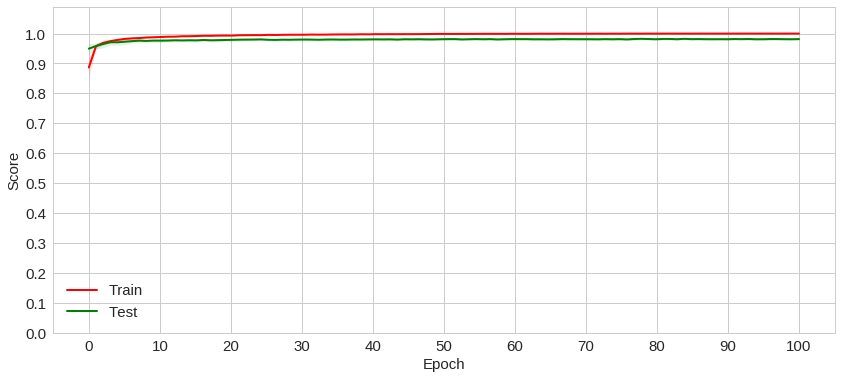

In [55]:
plot_mean_acc(tophist)

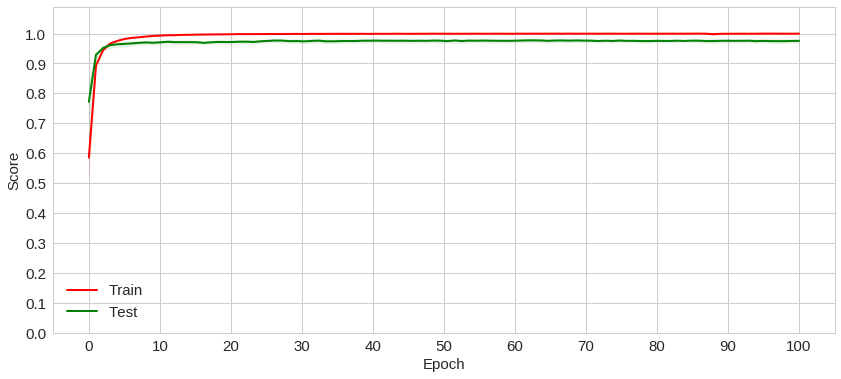

In [56]:
plot_mean_acc(hist)

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

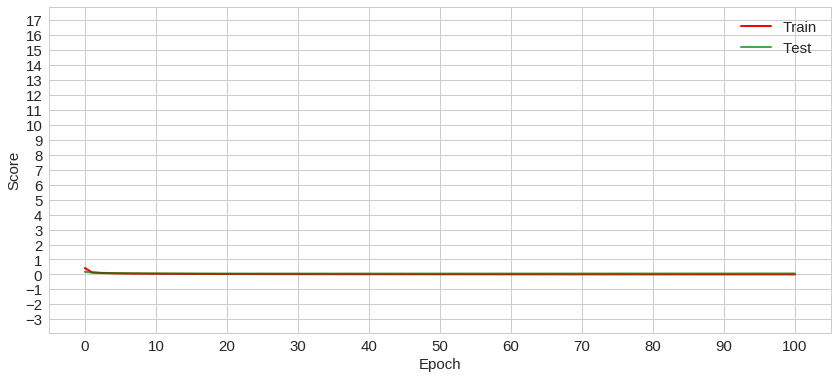

In [58]:
plot_mean_loss(tophist)

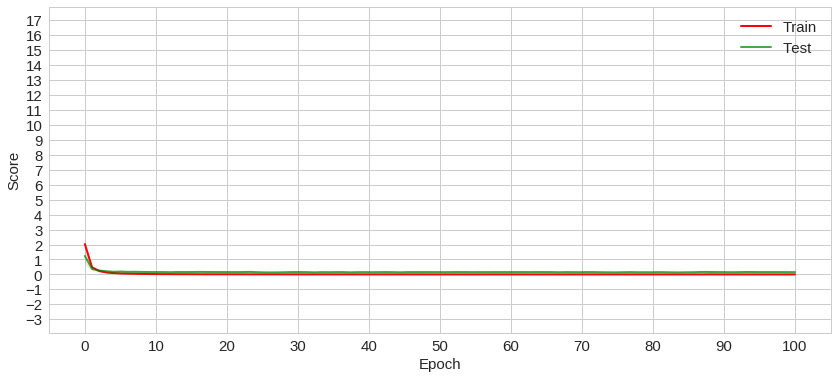

In [59]:
plot_mean_loss(hist)